# **Information**

1. Run the notebook on **Google Colab**

# **Download the dataset from Dropbox**

In [ ]:
!wget -O used_cars_2021.csv "https://www.dropbox.com/s/8j1pad6zjmu8alz/used_cars_data_2021.csv?dl=0"

--2023-04-30 19:03:53--  https://www.dropbox.com/s/8j1pad6zjmu8alz/used_cars_data_2021.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8j1pad6zjmu8alz/used_cars_data_2021.csv [following]
--2023-04-30 19:03:54--  https://www.dropbox.com/s/raw/8j1pad6zjmu8alz/used_cars_data_2021.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4e8727d33f73736cb2f995cbe9.dl.dropboxusercontent.com/cd/0/inline/B7KfRl9FJJ1R1reHeujM8bMpxWSJJjyH2qF2UX23xKtxNfxhgafKO61hktzxfQ1PLPN87k34q06hvCHQ-dTHsE6b8Gzwdy3tmVoF74aoCWA8fu2VDpNNfbgHGeAVssdjITzewW81eTYefYrLP7e_ev8flT6MGBJhjYtwNBaAabrlBw/file# [following]
--2023-04-30 19:03:54--  https://uc4e8727d33f73736cb2f995cbe9.dl.dropboxusercontent.com/cd/0/inline/B7KfRl9FJJ1R1reHeujM8bMpxWSJJjyH2qF2UX23xK

# **Install needed libraries**

In [ ]:
# Install any other libraries as and when needed 
!pip install category-encoders
!pip install -U "ray[default]"
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━

# **Import libraries**

In [ ]:
# Import all the necessary libraries here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

from category_encoders import TargetEncoder, BinaryEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, brier_score_loss, roc_auc_score, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error

from joblib import parallel_backend
from ray.util.joblib import register_ray
register_ray() 

In [ ]:
# Reference article: https://towardsdatascience.com/how-to-calculate-roc-auc-score-for-regression-models-c0be4fdf76bb
# Code slightly modified to run faster
# The score helps us understand how well the model ranks a bigger value higher than a smaller value
def regression_roc_auc_score(y_true, y_pred):
  """
  Computes Regression-ROC-AUC-score.
  
  Parameters:
  ----------
  y_true: array-like of shape (n_samples,). Binary or continuous target variable.
  y_pred: array-like of shape (n_samples,). Target scores.
  
  Returns:
  -------
  rroc: float. Regression-ROC-AUC-score.
  """
  
  import numpy as np
  import itertools
    
  y_true = np.array(y_true).reshape(-1, 1)
  y_pred = np.array(y_pred).reshape(-1, 1)

  n_ele = len(y_true)

  num_pairs = 0
  num_same_sign = 0

  for i in range(n_ele - 1):
    diff_true_pred = (y_true[i+1:] - y_true[i]) * (y_pred[i+1:] - y_pred[i])
    diff_pred = y_pred[i+1:] - y_pred[i]
    num_same_sign += (diff_true_pred > 0).sum()
    num_same_sign += (diff_pred == 0).sum()/2
    num_pairs += n_ele - 1 - i
    num_pairs -= ((y_true[i+1:] - y_true[i]) == 0).sum()
  
  return num_same_sign/num_pairs

# **Load the dataset**

In [ ]:
used_cars_df = pd.read_csv("used_cars_2021.csv")

<ipython-input-5-092be8eed5ea>:1: DtypeWarning: Columns (3,12,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  used_cars_df = pd.read_csv("used_cars_2021.csv")


In [ ]:
# Brief information about the data
used_cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176528 entries, 0 to 176527
Data columns (total 67 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               176528 non-null  int64  
 1   vin                      176528 non-null  object 
 2   back_legroom             138791 non-null  object 
 3   bed                      66 non-null      object 
 4   bed_height               7471 non-null    object 
 5   bed_length               7471 non-null    object 
 6   body_type                166727 non-null  object 
 7   cabin                    511 non-null     object 
 8   city                     176528 non-null  object 
 9   city_fuel_economy        114913 non-null  float64
 10  combine_fuel_economy     0 non-null       float64
 11  daysonmarket             176528 non-null  int64  
 12  dealer_zip               176528 non-null  object 
 13  description              167886 non-null  object 
 14  engi

In [ ]:
used_cars_df.head()

Unnamed: 0                vin back_legroom  bed bed_height bed_length  \
0         604  3C4NJDBB9MT516259      38.3 in  NaN        NaN        NaN   
1         612  3C4NJDBB5MT500768      38.3 in  NaN        NaN        NaN   
2         629  3C4NJDBBXMT507232      38.3 in  NaN        NaN        NaN   
3         642  3C4NJDBB0MT503304      38.3 in  NaN        NaN        NaN   
4         646  3C4NJDBB9MT516410      38.3 in  NaN        NaN        NaN   

         body_type cabin           city  city_fuel_economy  ...  transmission  \
0  SUV / Crossover   NaN  East Hartford               22.0  ...             A   
1  SUV / Crossover   NaN  East Hartford               22.0  ...             A   
2  SUV / Crossover   NaN  East Hartford               22.0  ...             A   
3  SUV / Crossover   NaN  East Hartford               22.0  ...             A   
4  SUV / Crossover   NaN  East Hartford               22.0  ...             A   

   transmission_display  trimId     trim_name vehicle_damage_category  \
0             Automatic  t93967  Altitude 4WD                     NaN   
1             Automatic  t93967  Altitude 4WD                     NaN   
2             Automatic  t93967  Altitude 4WD                     NaN   
3             Automatic  t93967  Altitude 4WD                     NaN   
4             Automatic  t93967  Altitude 4WD                     NaN   

   wheel_system wheel_system_display wheelbase  width  year  
0           4WD     Four-Wheel Drive  103.8 in  80 in  2021  
1           4WD     Four-Wheel Drive  103.8 in  80 in  2021  
2           4WD     Four-Wheel Drive  103.8 in  80 in  2021  
3           4WD     Four-Wheel Drive  103.8 in  80 in  2021  
4           4WD     Four-Wheel Drive  103.8 in  80 in  2021  

[5 rows x 67 columns]

In [ ]:
print(used_cars_df.columns)   # Column names in the dataset
print("\nShape of the dataframe:", used_cars_df.shape)

Index(['Unnamed: 0', 'vin', 'back_legroom', 'bed', 'bed_height', 'bed_length',
       'body_type', 'cabin', 'city', 'city_fuel_economy',
       'combine_fuel_economy', 'daysonmarket', 'dealer_zip', 'description',
       'engine_cylinders', 'engine_displacement', 'engine_type',
       'exterior_color', 'fleet', 'frame_damaged', 'franchise_dealer',
       'franchise_make', 'front_legroom', 'fuel_tank_volume', 'fuel_type',
       'has_accidents', 'height', 'highway_fuel_economy', 'horsepower',
       'interior_color', 'isCab', 'is_certified', 'is_cpo', 'is_new',
       'is_oemcpo', 'latitude', 'length', 'listed_date', 'listing_color',
       'listing_id', 'longitude', 'main_picture_url', 'major_options',
       'make_name', 'maximum_seating', 'mileage', 'model_name', 'owner_count',
       'power', 'price', 'salvage', 'savings_amount', 'seller_rating', 'sp_id',
       'sp_name', 'theft_title', 'torque', 'transmission',
       'transmission_display', 'trimId', 'trim_name',
       'vehicle_d

# **2. Cleaning the dataset**

## 2.1 Convert numerical features from string to float format

In [ ]:
# Convert some of the numerical features from str to float

# Numerical features: ['back_legroom' --> need to convert from str to int, 'front_legroom' --> need to convert from str to int,
# 'fuel_tank_volume' --> need to convert from str to int, 'height' --> need to convert from str to int,
# 'length' --> need to convert from str to int, 'maximum_seating' --> need to convert from str to int, 
# 'torque' --> remove the rpm, 'wheelbase' --> need to convert from str to int, 'width' --> need to convert from str to int]

convert_num_features = ['back_legroom', 'front_legroom', 'fuel_tank_volume', 'height', 'length',
                        'maximum_seating', 'torque', 'wheelbase', 'width']

for col in convert_num_features:
  used_cars_df[col] = used_cars_df[col].str.split(' ').str[0]
  used_cars_df[col] = pd.to_numeric(used_cars_df[col], errors = 'coerce')

## 2.2 Convert **major_options** feature

In [ ]:
# Convert major_options from list to number of major options
used_cars_df['major_options'] = used_cars_df['major_options'].str.count(',') + 1

## 2.3 Drop features with irrelevant information

In [ ]:
# drop the features which do not provide relavant information
drop_columns = []

# dropping the 'year' column because it is just for information and not a feature
drop_columns.append('year') 
# dropping the first two columns because it contains index and VIN of the rows which is just for information
drop_columns.append(used_cars_df.columns[0])
drop_columns.append(used_cars_df.columns[1])
# 'listed_date' feature can be dropped because we have information about the 'daysonmarket'
drop_columns.append('listed_date') 
# 'description' feature can be dropped because it mainly contains redundant information present in other features
drop_columns.append('description') 
# 'latitude' and 'longitude' features can be dropped because we already have 'city' information
drop_columns.append('latitude')
drop_columns.append('longitude')
# 'listing_id' can be dropped because that is just an information and not a feature
drop_columns.append('listing_id')
# 'main_picture_url' can be dropped
drop_columns.append('main_picture_url')
# 'sp_id' and 'sp_name' can be dropped because we have 'seller_rating'
drop_columns.append('sp_id')
drop_columns.append('sp_name')
# 'trimId' can be dropped because we have 'trim_name'
drop_columns.append('trimId')
# 'wheel_system' can be dropped because we have 'wheel_system_display'
drop_columns.append('wheel_system')
# 'dealer_zip' can be dropped because we have 'city' information
drop_columns.append('dealer_zip')
# 'transmission' can be removed because we have 'transmission_display' information
drop_columns.append('transmission')
# 'engine_type' and 'engine_cylinders' have the same exact information so the former can be dropped
drop_columns.append('engine_type')
# 'power' can be dropped because we have 'horsepower' information
drop_columns.append('power')
# 'exterior_color' can be dropped because we have more generic 'listing_color' information
drop_columns.append('exterior_color')

print("Number of irrelevant features:", len(drop_columns))
used_cars_df = used_cars_df.drop(drop_columns, axis = 1)

Number of irrelevant features: 18


In [ ]:
# 'savings_amount' had only one unique value after outlier handling.
# It is dropped at that stage

In [ ]:
# 'features' remaining after dropping the irrelevant features
used_cars_df.columns

Index(['back_legroom', 'bed', 'bed_height', 'bed_length', 'body_type', 'cabin',
       'city', 'city_fuel_economy', 'combine_fuel_economy', 'daysonmarket',
       'engine_cylinders', 'engine_displacement', 'fleet', 'frame_damaged',
       'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'fuel_type', 'has_accidents', 'height',
       'highway_fuel_economy', 'horsepower', 'interior_color', 'isCab',
       'is_certified', 'is_cpo', 'is_new', 'is_oemcpo', 'length',
       'listing_color', 'major_options', 'make_name', 'maximum_seating',
       'mileage', 'model_name', 'owner_count', 'price', 'salvage',
       'savings_amount', 'seller_rating', 'theft_title', 'torque',
       'transmission_display', 'trim_name', 'vehicle_damage_category',
       'wheel_system_display', 'wheelbase', 'width'],
      dtype='object')

## 2.4 Drop records/features with missing values

Number of records with some value missing:  176528
Number of features with some value missing:  39
Number of features with more than 30% values missing:  19 



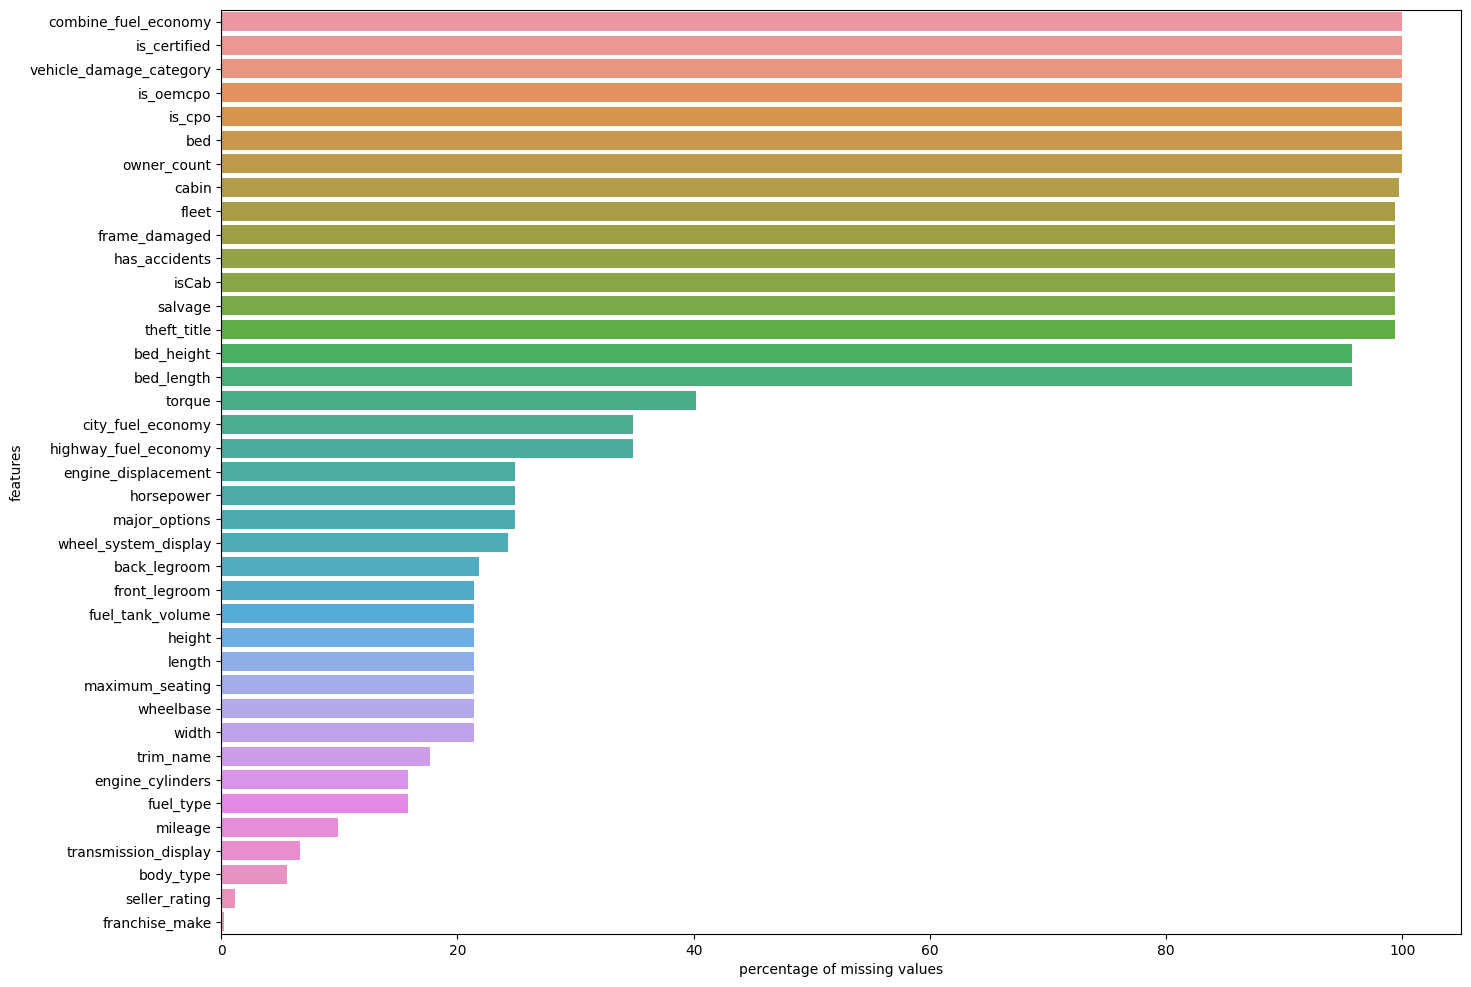

In [ ]:
# Number of records with atleast one missing feature value
print("Number of records with some value missing: ", used_cars_df.isnull().any(axis=1).sum())
# All the rows have some missing value, so cannot drop rows

cols_missing_values = {}      # columns with some value missing
cols_missing_30percent = []   # columns with more than 30% values missing

# Percentage of missing values in each column
for col in used_cars_df:
  if used_cars_df[col].isna().sum() * 100 / used_cars_df.shape[0] >= 30:
    cols_missing_30percent.append(col)
  
  if used_cars_df[col].isna().sum() * 100 / used_cars_df.shape[0] > 0:
    cols_missing_values[col] = used_cars_df[col].isna().sum() * 100 / used_cars_df.shape[0]

# Number of features with some value missing
print("Number of features with some value missing: ", len(cols_missing_values))
cols_missing_values = dict(sorted(cols_missing_values.items(), key=lambda x: x[1], reverse=True))

# for col in cols_missing_values.keys():
#   print(col.ljust(30), round(cols_missing_values[col], 2))

plt.figure(figsize = (16, 12))
sns.barplot(y = list(cols_missing_values.keys()), x = list(cols_missing_values.values()), orient = "h")
plt.xlabel('percentage of missing values')
plt.ylabel('features')
# plt.savefig('missing_values.png', format='png', dpi=600)

# Number of features with more than 30% values missing. They can be dropped  
print("Number of features with more than 30% values missing: ", len(cols_missing_30percent), "\n")

used_cars_df = used_cars_df.drop(cols_missing_30percent, axis = 1)

In [ ]:
# features 'remaining' after dropping the features with missing values
print(used_cars_df.columns)
print("\nShape of the dataframe:", used_cars_df.shape)

Index(['back_legroom', 'body_type', 'city', 'daysonmarket', 'engine_cylinders',
       'engine_displacement', 'franchise_dealer', 'franchise_make',
       'front_legroom', 'fuel_tank_volume', 'fuel_type', 'height',
       'horsepower', 'interior_color', 'is_new', 'length', 'listing_color',
       'major_options', 'make_name', 'maximum_seating', 'mileage',
       'model_name', 'price', 'savings_amount', 'seller_rating',
       'transmission_display', 'trim_name', 'wheel_system_display',
       'wheelbase', 'width'],
      dtype='object')

Shape of the dataframe: (176528, 30)


# **3. Data preprocessing**

## 3.1 Fill the missing feature values

In [ ]:
# Display the features with less than 30% missing values
for col in cols_missing_values.keys():
  if cols_missing_values[col] < 30:
    print(col.ljust(30), round(cols_missing_values[col], 2))

engine_displacement            24.86
horsepower                     24.86
major_options                  24.85
wheel_system_display           24.3
back_legroom                   21.85
front_legroom                  21.4
fuel_tank_volume               21.39
height                         21.39
length                         21.39
maximum_seating                21.39
wheelbase                      21.39
width                          21.39
trim_name                      17.7
engine_cylinders               15.83
fuel_type                      15.81
mileage                        9.88
transmission_display           6.7
body_type                      5.55
seller_rating                  1.2
franchise_make                 0.19


In [ ]:
# Less than 25% of the data has missing values, so basic imputations will suffice

# Impute the categorical features using 'mode'
categorical_features = ['wheel_system_display', 'trim_name', 'engine_cylinders', 
                        'fuel_type', 'transmission_display', 'body_type', 'franchise_make']
for col in categorical_features:
  used_cars_df[col] = used_cars_df[col].fillna(used_cars_df[col].mode()[0])


# Impute the numerical features using 'median'
numerical_features = ['seller_rating', 'engine_displacement', 'horsepower', 'back_legroom', 'front_legroom',
                        'fuel_tank_volume', 'height', 'length', 'maximum_seating', 'wheelbase', 'width']
for col in numerical_features:
  used_cars_df[col] = used_cars_df[col].fillna(used_cars_df[col].median())

# 'mileage' default values are '0', so fill the missing values as '0'
used_cars_df['mileage'] = used_cars_df['mileage'].fillna(0)

# 'major_options' missing values can be considered as having no 'major_options', so fill the missing values as '0'
used_cars_df['major_options'] = used_cars_df['major_options'].fillna(0.0)

## 3.2 Outlier handling

Number of rows in the dataset:  176528
Number of rows in the dataset after removing 'mileage' outliers:  172575


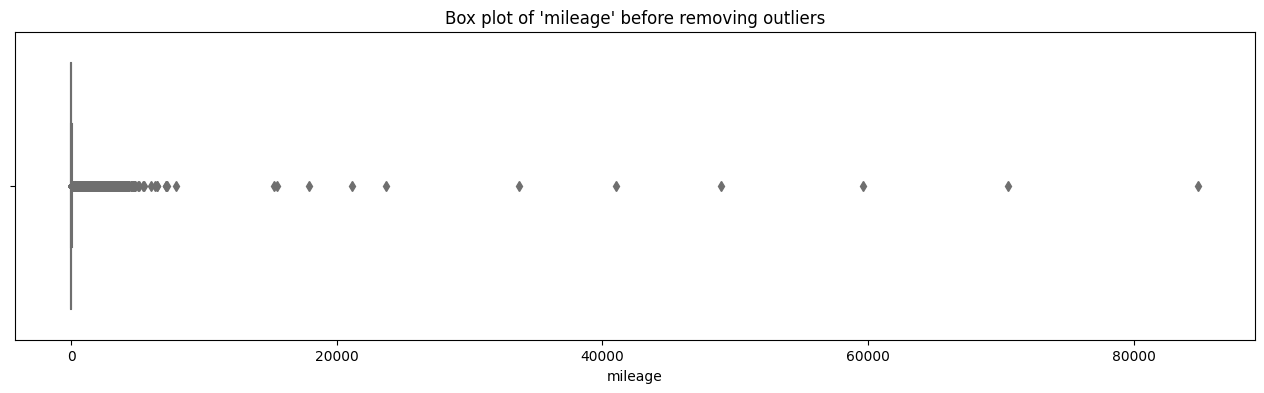

In [ ]:
# Remove the rows with target 'price' values as outliers
fig, axs = plt.subplots(1, 1, figsize = (16, 4))


print("Number of rows in the dataset: ", used_cars_df.shape[0])
# box subplot for the 'mileage'
sns.boxplot(ax = axs, x = 'mileage', data = used_cars_df, color = 'skyblue', palette = None);
mileages = used_cars_df["mileage"].to_numpy()
axs.set_title("Box plot of 'mileage' before removing outliers")
# Only 2.2% of the records are dropped, so this is ok to do

# plt.savefig("before_outliers.png", format='png', dpi=600)

q1 = np.percentile(mileages, 25)
q3 = np.percentile(mileages, 75)
upper_limit = q3 + 1.5 * (q3 - q1)
lower_limit = q1 - 1.5 * (q3 - q1)

used_cars_df = used_cars_df.drop(used_cars_df[used_cars_df['mileage'] < lower_limit].index)
used_cars_df = used_cars_df.drop(used_cars_df[used_cars_df['mileage'] > upper_limit].index)
print("Number of rows in the dataset after removing 'mileage' outliers: ", used_cars_df.shape[0])

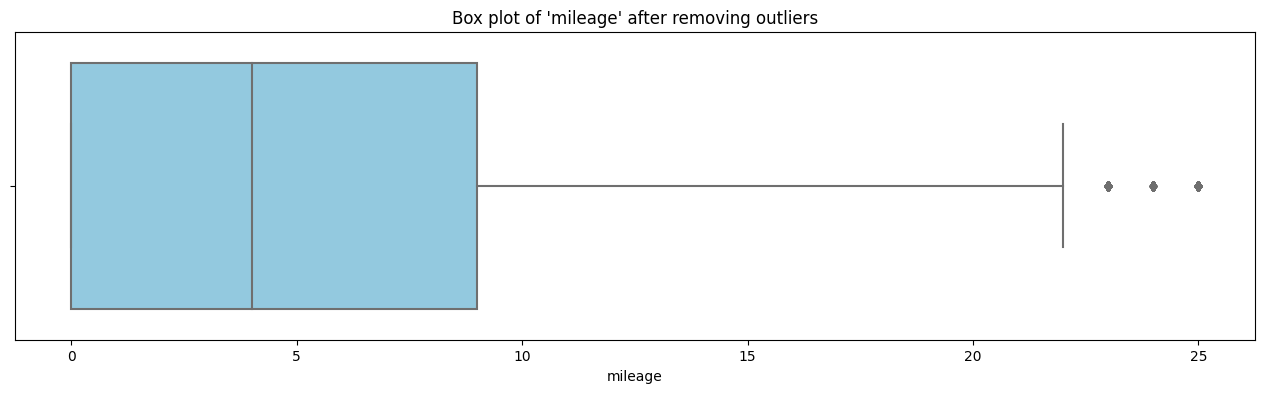

In [ ]:
fig, axs = plt.subplots(1, 1, figsize = (16, 4))

sns.boxplot(ax = axs, x = 'mileage', data = used_cars_df, color = 'skyblue', palette = None);
axs.set_title("Box plot of 'mileage' after removing outliers");
# plt.savefig("after_outliers.png", format='png', dpi=600)

In [ ]:
# unique values in 'savings_amount'
print("Unique values in 'savings_amount' feature: ", used_cars_df['savings_amount'].nunique())
# there is only 1 unique value in 'savings_amount', so the feature can be dropped
used_cars_df = used_cars_df.drop('savings_amount', axis = 1)

Unique values in 'savings_amount' feature:  1


## 3.3 Splitting the features and target variable

In [ ]:
# Separate features and target variable
used_cars_price = used_cars_df[["price"]].copy()
used_cars_features = used_cars_df.copy().drop("price", axis = 1)

used_cars_features.head()

back_legroom        body_type           city  daysonmarket  \
0          38.3  SUV / Crossover  East Hartford             7   
1          38.3  SUV / Crossover  East Hartford            24   
2          38.3  SUV / Crossover  East Hartford            20   
3          38.3  SUV / Crossover  East Hartford            12   
4          38.3  SUV / Crossover  East Hartford             7   

  engine_cylinders  engine_displacement  franchise_dealer franchise_make  \
0               I4               2400.0              True           Jeep   
1               I4               2400.0              True           Jeep   
2               I4               2400.0              True           Jeep   
3               I4               2400.0              True           Jeep   
4               I4               2400.0              True           Jeep   

   front_legroom  fuel_tank_volume  ... make_name  maximum_seating  mileage  \
0           41.8              13.5  ...      Jeep              5.0      0.0   
1           41.8              13.5  ...      Jeep              5.0      0.0   
2           41.8              13.5  ...      Jeep              5.0      0.0   
3           41.8              13.5  ...      Jeep              5.0      0.0   
4           41.8              13.5  ...      Jeep              5.0      0.0   

  model_name  seller_rating  transmission_display     trim_name  \
0    Compass       4.377778             Automatic  Altitude 4WD   
1    Compass       4.377778             Automatic  Altitude 4WD   
2    Compass       4.377778             Automatic  Altitude 4WD   
3    Compass       4.377778             Automatic  Altitude 4WD   
4    Compass       4.377778             Automatic  Altitude 4WD   

   wheel_system_display wheelbase  width  
0      Four-Wheel Drive     103.8   80.0  
1      Four-Wheel Drive     103.8   80.0  
2      Four-Wheel Drive     103.8   80.0  
3      Four-Wheel Drive     103.8   80.0  
4      Four-Wheel Drive     103.8   80.0  

[5 rows x 28 columns]

# **4. Data Visualization and Insights**

## 4.0 Features and target variable information

In [ ]:
# Categorical features: ['body_type', 'city', 'engine_cylinders', 'exterior_color', 'franchise_make', 'fuel_type',
# 'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission_display',
# 'trim_name', 'wheel_system_display'] -- 13

# Numerical features: ['back_legroom', 'engine_displacement', 'daysonmarket', 'front_legroom',
# 'fuel_tank_volume', 'height', 'horsepower', 'major_options', 'length', 'maximum_seating', 'mileage',
# 'seller_rating', 'wheelbase', 'width'] -- 14

# Boolean features: ['franchise_dealer', 'is_new'] -- 2
 
# 'price' is the target feature -- 1

## 4.1 Histograms of numerical features

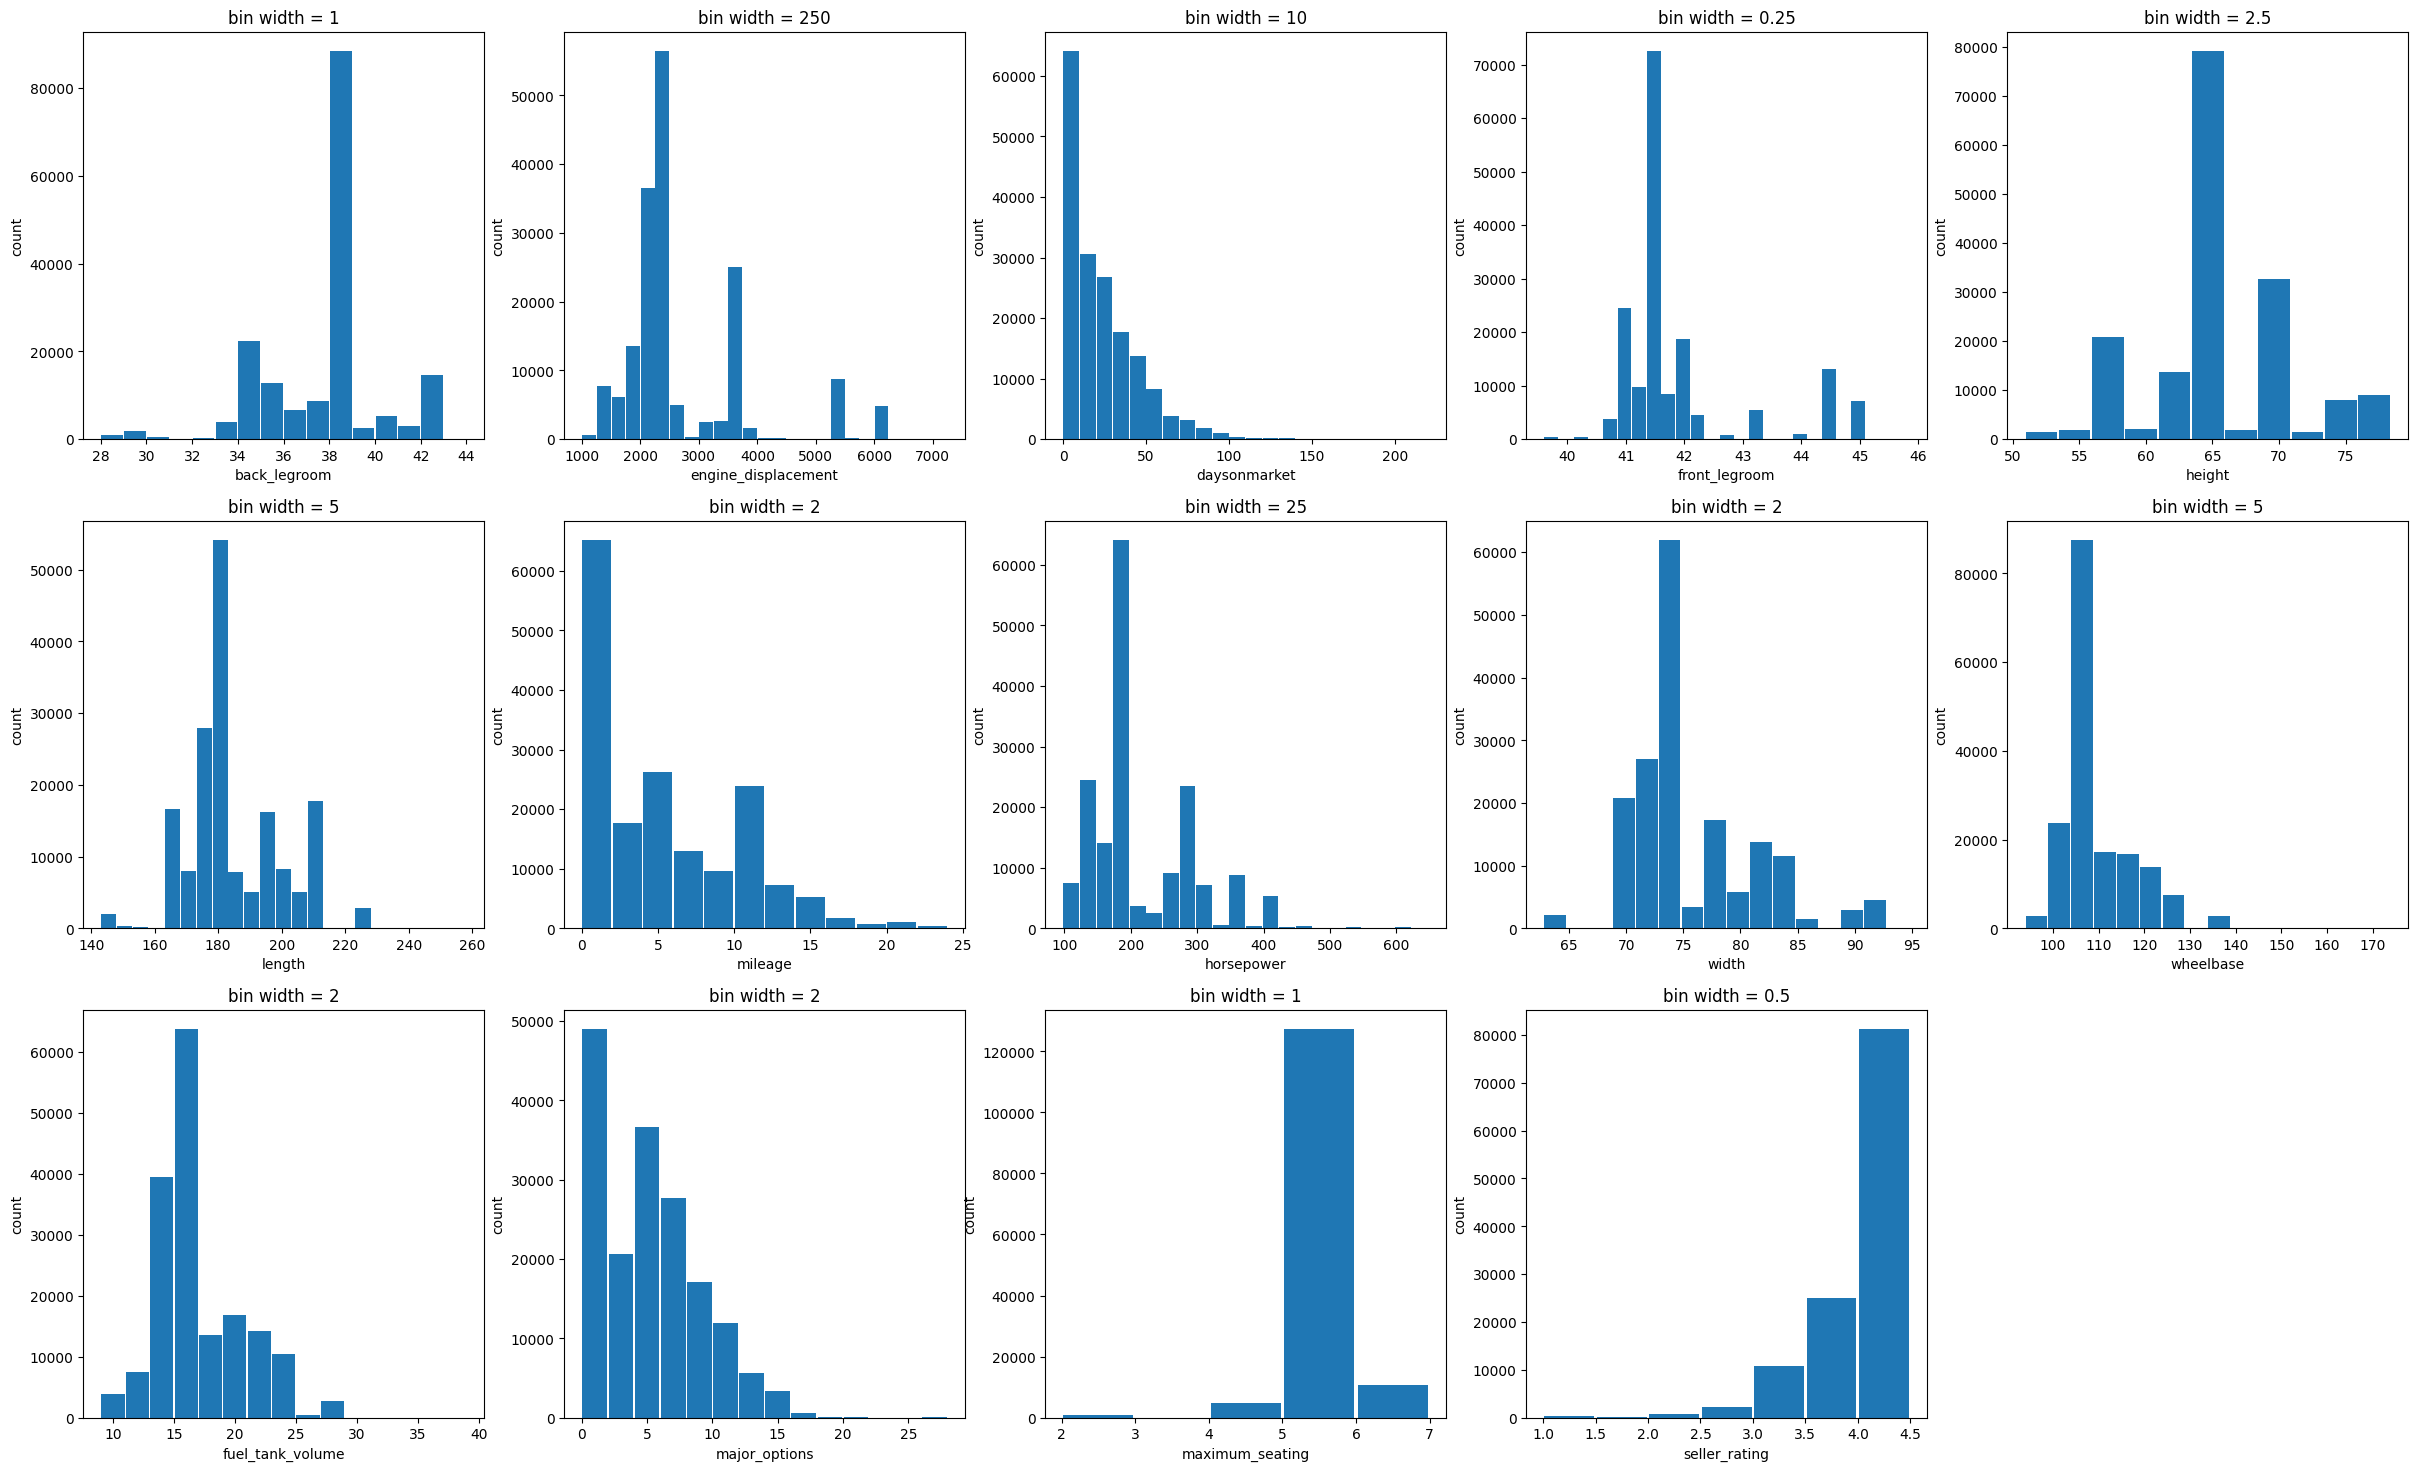

In [ ]:
fig, axs = plt.subplots(3, 5, figsize = (30, 18))
#fig.suptitle("Histogram plots")

# Numerical features: ['back_legroom', 'engine_displacement', 'daysonmarket', 'front_legroom',
# 'fuel_tank_volume', 'height', 'horsepower', 'major_options', 'length', 'maximum_seating', 'mileage',
# 'seller_rating', 'wheelbase', 'width']

axs[-1, -1].axis("off")

values = used_cars_features["back_legroom"].to_numpy()
axs[0, 0].hist(values, bins = np.arange(np.min(values), np.max(values), 1), rwidth = 0.95)
axs[0, 0].set(xlabel = "back_legroom", ylabel = "count")
axs[0, 0].set_title("bin width = 1")

values = used_cars_features["engine_displacement"].to_numpy()
axs[0, 1].hist(values, bins = np.arange(np.min(values), np.max(values), 250), rwidth = 0.95)
axs[0, 1].set(xlabel = "engine_displacement", ylabel = "count")
axs[0, 1].set_title("bin width = 250")

values = used_cars_features["daysonmarket"].to_numpy()
axs[0, 2].hist(values, bins = np.arange(np.min(values), np.max(values), 10), rwidth = 0.95)
axs[0, 2].set(xlabel = "daysonmarket", ylabel = "count")
axs[0, 2].set_title("bin width = 10")

# values = np.log(values + 1)
# axs[-1, -1].hist(values, bins = np.arange(np.min(values), np.max(values), 0.25), rwidth = 0.95)
# axs[-1, -1].set(xlabel = "daysonmarket", ylabel = "count")
# axs[-1, -1].set_title(f"bin width = 0.25")

values = used_cars_features["front_legroom"].to_numpy()
axs[0, 3].hist(values, bins = np.arange(np.min(values), np.max(values), 0.25), rwidth = 0.95)
axs[0, 3].set(xlabel = "front_legroom", ylabel = "count")
axs[0, 3].set_title("bin width = 0.25")

values = used_cars_features["height"].to_numpy()
axs[0, 4].hist(values, bins = np.arange(np.min(values), np.max(values), 2.5), rwidth = 0.95)
axs[0, 4].set(xlabel = "height", ylabel = "count")
axs[0, 4].set_title("bin width = 2.5")

values = used_cars_features["length"].to_numpy()
axs[1, 0].hist(values, bins = np.arange(np.min(values), np.max(values), 5), rwidth = 0.95)
axs[1, 0].set(xlabel = "length", ylabel = "count")
axs[1, 0].set_title("bin width = 5")

values = used_cars_features["mileage"].to_numpy()
axs[1, 1].hist(values, bins = np.arange(np.min(values), np.max(values), 2), rwidth = 0.95)
axs[1, 1].set(xlabel = "mileage", ylabel = "count")
axs[1, 1].set_title("bin width = 2")

values = used_cars_features["horsepower"].to_numpy()
axs[1, 2].hist(values, bins = np.arange(np.min(values), np.max(values), 25), rwidth = 0.95)
axs[1, 2].set(xlabel = "horsepower", ylabel = "count")
axs[1, 2].set_title("bin width = 25")

values = used_cars_features["width"].to_numpy()
axs[1, 3].hist(values, bins = np.arange(np.min(values), np.max(values), 2), rwidth = 0.95)
axs[1, 3].set(xlabel = "width", ylabel = "count")
axs[1, 3].set_title("bin width = 2")

values = used_cars_features["wheelbase"].to_numpy()
axs[1, 4].hist(values, bins = np.arange(np.min(values), np.max(values), 5), rwidth = 0.95)
axs[1, 4].set(xlabel = "wheelbase", ylabel = "count")
axs[1, 4].set_title("bin width = 5")

values = used_cars_features["fuel_tank_volume"].to_numpy()
axs[2, 0].hist(values, bins = np.arange(np.min(values), np.max(values), 2), rwidth = 0.95)
axs[2, 0].set(xlabel = "fuel_tank_volume", ylabel = "count")
axs[2, 0].set_title("bin width = 2")

values = used_cars_features["major_options"].to_numpy()
axs[2, 1].hist(values, bins = np.arange(np.min(values), np.max(values), 2), rwidth = 0.95)
axs[2, 1].set(xlabel = "major_options", ylabel = "count")
axs[2, 1].set_title("bin width = 2")

values = used_cars_features["maximum_seating"].to_numpy()
axs[2, 2].hist(values, bins = np.arange(np.min(values), np.max(values), 1), rwidth = 0.95)
axs[2, 2].set(xlabel = "maximum_seating", ylabel = "count")
axs[2, 2].set_title("bin width = 1")

values = used_cars_features["seller_rating"].to_numpy()
axs[2, 3].hist(values, bins = np.arange(np.min(values), np.max(values), 0.5), rwidth = 0.95)
axs[2, 3].set(xlabel = "seller_rating", ylabel = "count")
axs[2, 3].set_title("bin width = 0.5");

# plt.savefig('hist_plots.png', format='png', dpi=800)

## 4.2 Side by side bar plots of categorical features

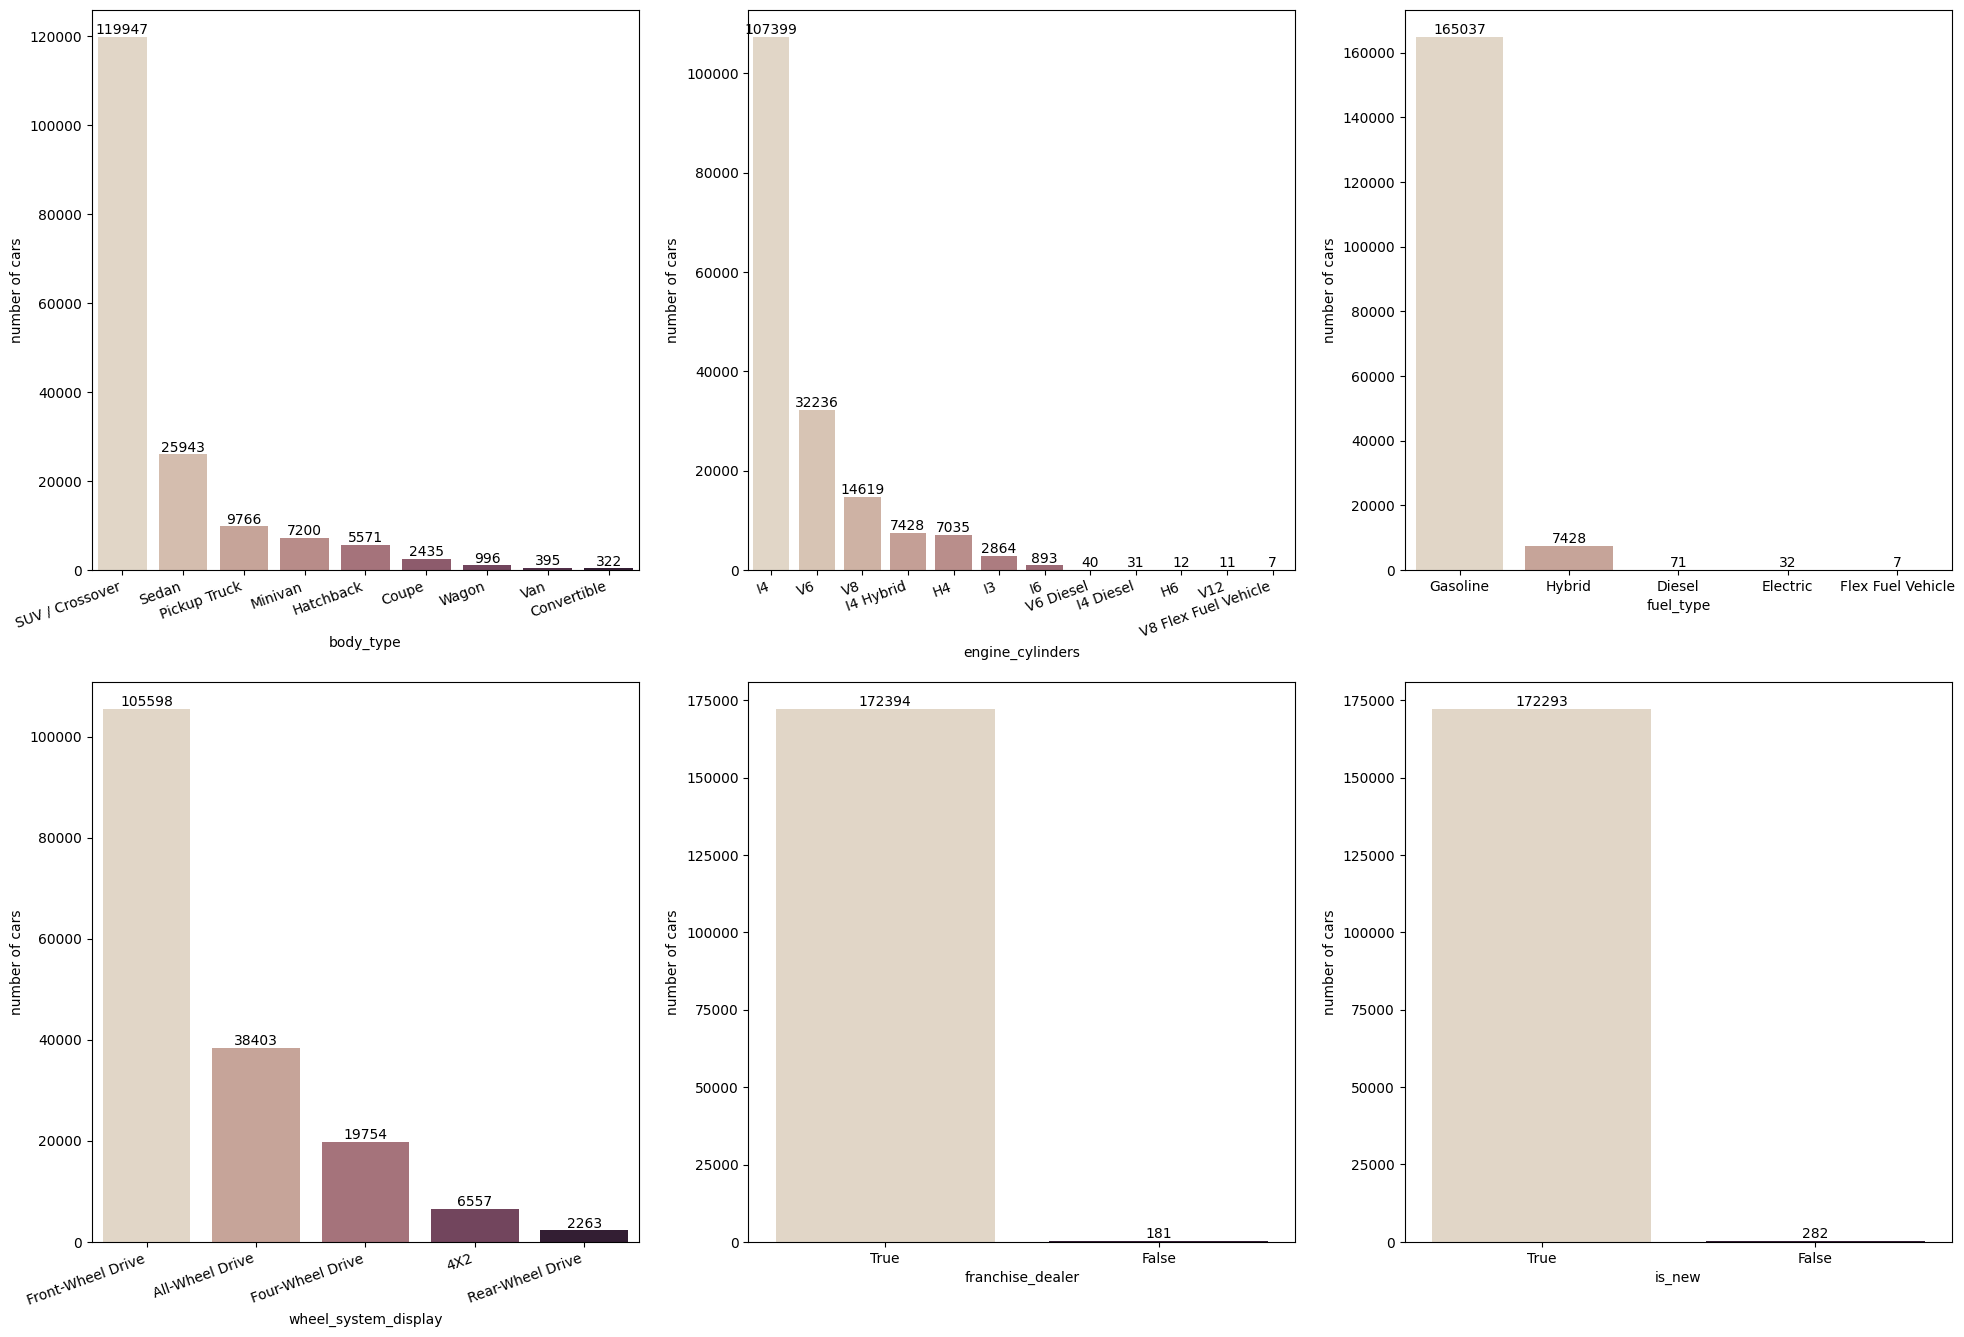

In [ ]:
# Categorical features: ['body_type', 'city', 'engine_cylinders', 'exterior_color', 'franchise_make', 'fuel_type',
# 'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission_display',
# 'trim_name', 'wheel_system_display'] -- 13

# Boolean features: ['franchise_dealer', 'is_new'] -- 2

cat_features = ['body_type', 'city', 'engine_cylinders', 'exterior_color', 'franchise_make', 'fuel_type',
  'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission_display',
  'trim_name', 'wheel_system_display']

# for col in cat_features:
#   print(col, used_cars_features[col].nunique())

fig, axs = plt.subplots(2, 3, figsize = (24, 16))
#fig.suptitle("Side-by-Side bar plots")

sns.countplot(ax = axs[0, 0], x = "body_type", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["body_type"].value_counts().index)
axs[0, 0].bar_label(axs[0, 0].containers[0])
axs[0, 0].set(xlabel = "body_type", ylabel = "number of cars")
axs[0, 0].set_xticks(axs[0, 0].get_xticks(), axs[0, 0].get_xticklabels(), rotation=20, ha='right')

sns.countplot(ax = axs[0, 1], x = "engine_cylinders", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["engine_cylinders"].value_counts().index)
axs[0, 1].bar_label(axs[0, 1].containers[0])
axs[0, 1].set(xlabel = "engine_cylinders", ylabel = "number of cars")
axs[0, 1].set_xticks(axs[0, 1].get_xticks(), axs[0, 1].get_xticklabels(), rotation=20, ha='right')

sns.countplot(ax = axs[0, 2], x = "fuel_type", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["fuel_type"].value_counts().index)
axs[0, 2].bar_label(axs[0, 2].containers[0])
axs[0, 2].set(xlabel = "fuel_type", ylabel = "number of cars")

sns.countplot(ax = axs[1, 0], x = "wheel_system_display", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["wheel_system_display"].value_counts().index)
axs[1, 0].bar_label(axs[1, 0].containers[0])
axs[1, 0].set(xlabel = "wheel_system_display", ylabel = "number of cars")
axs[1, 0].set_xticks(axs[1, 0].get_xticks(), axs[1, 0].get_xticklabels(), rotation=20, ha='right')

sns.countplot(ax = axs[1, 1], x = "franchise_dealer", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["franchise_dealer"].value_counts().index)
axs[1, 1].bar_label(axs[1, 1].containers[0])
axs[1, 1].set(xlabel = "franchise_dealer", ylabel = "number of cars")

sns.countplot(ax = axs[1, 2], x = "is_new", palette = "ch:.25", data = used_cars_features,\
              order = used_cars_features["is_new"].value_counts().index)
axs[1, 2].bar_label(axs[1, 2].containers[0])
axs[1, 2].set(xlabel = "is_new", ylabel = "number of cars");

# plt.savefig('side_by_side_plots.png', format='png', dpi=800)

## 4.3 Distribution of the target variable **price**

In [ ]:
# Brief information about the target 'price'
used_cars_price['price'].describe()

count    1.725750e+05
mean     3.757153e+04
std      1.880954e+04
min      1.010800e+04
25%      2.514000e+04
50%      3.219300e+04
75%      4.462500e+04
max      1.116711e+06
Name: price, dtype: float64

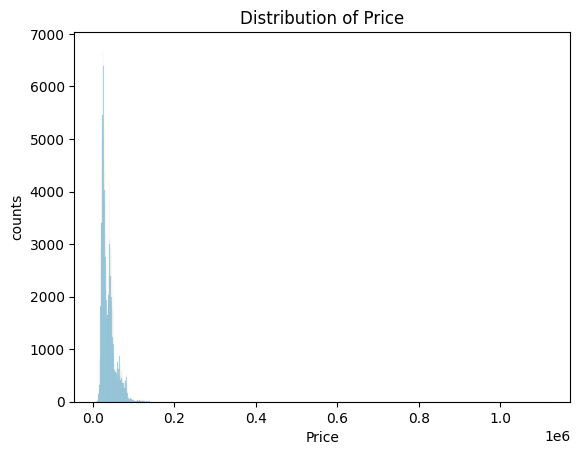

In [ ]:
price_data = used_cars_price['price']

# plot the distribution of the target variable 'price'
sns.histplot(price_data, kde=False, color='skyblue', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('counts')
plt.title('Distribution of Price')
plt.show()

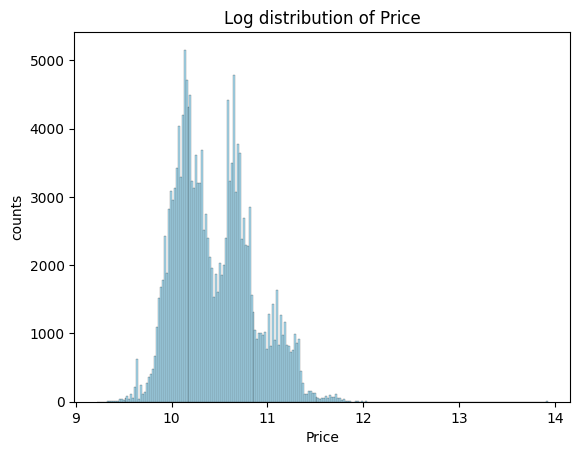

In [ ]:
price_data = used_cars_price['price']

# plot the distribution of the target variable 'price'
sns.histplot(np.log(price_data), kde=False, color='skyblue', alpha=0.7)
plt.xlabel('Price')
plt.ylabel('counts')
plt.title('Log distribution of Price')
plt.show()

## 4.4 Scatter plots of numerical features

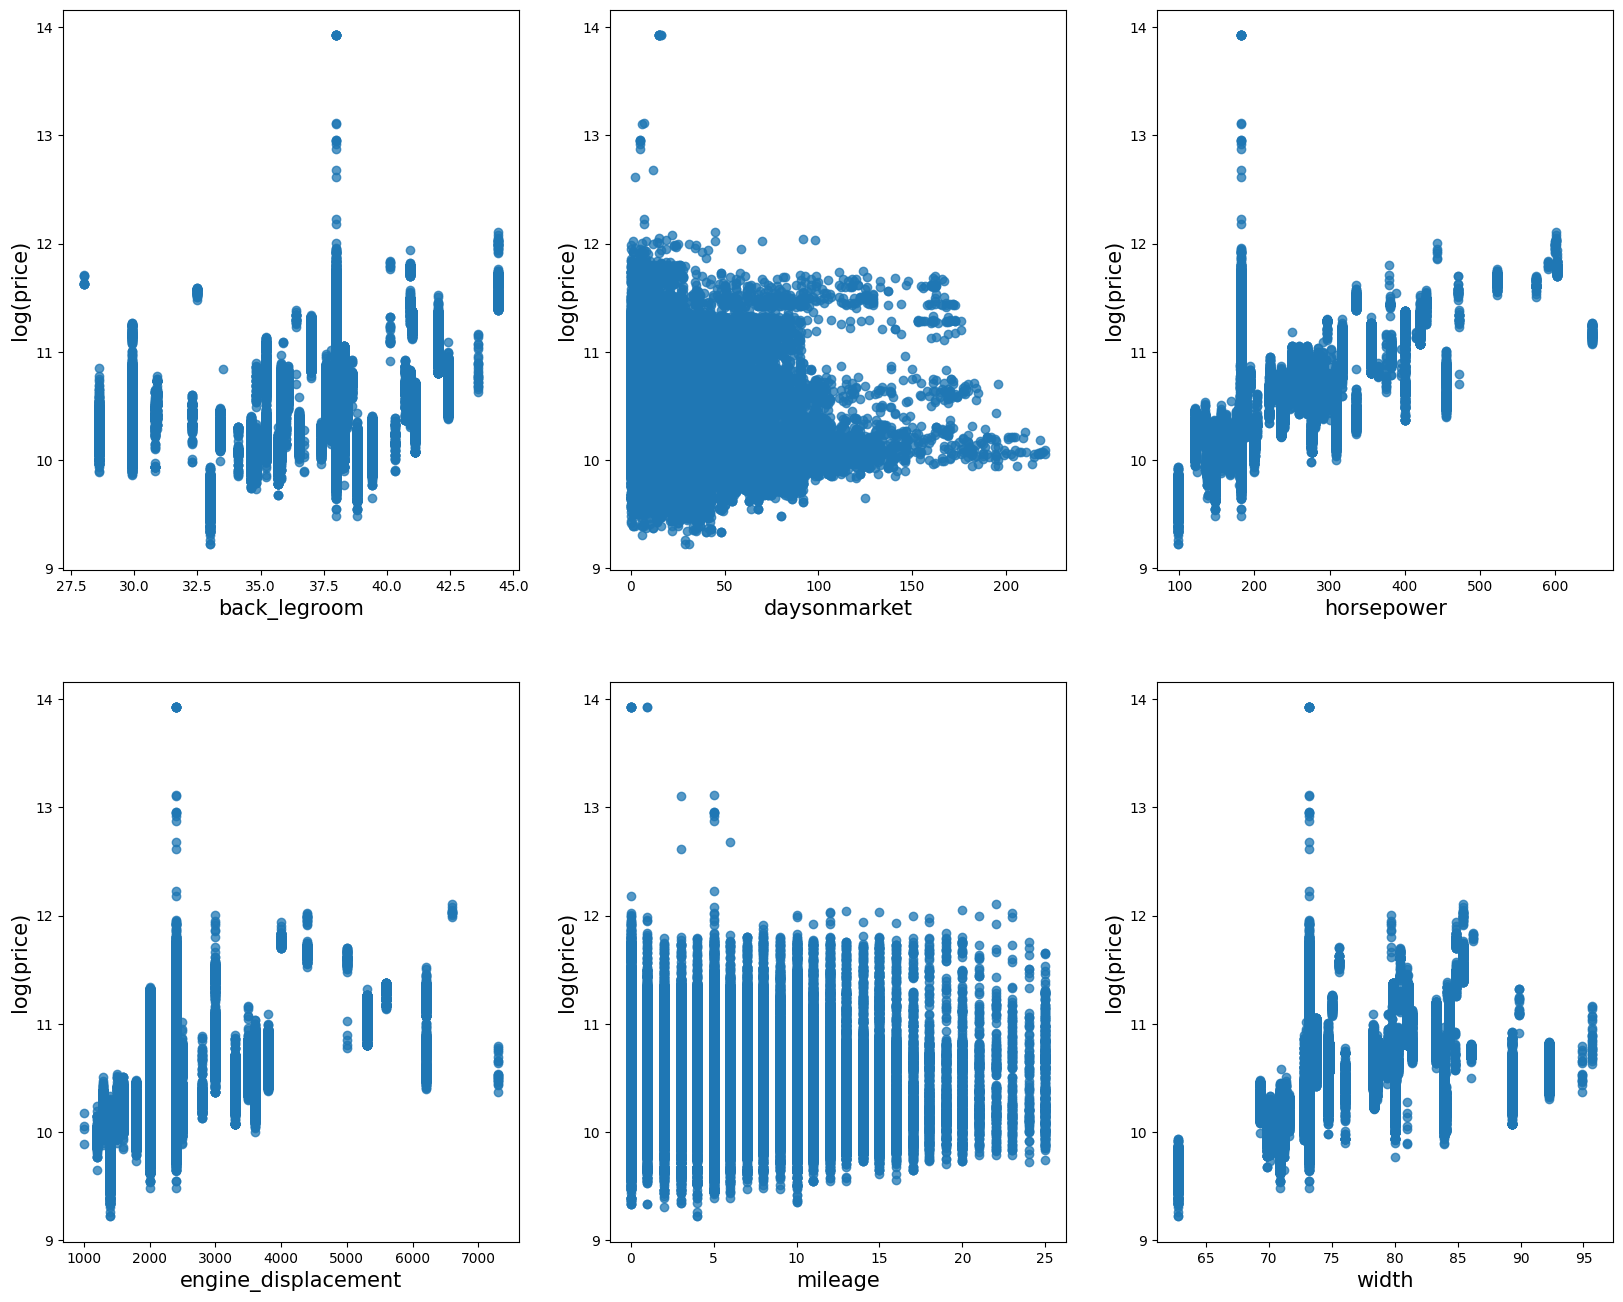

In [ ]:
# Numerical features: ['back_legroom', 'engine_displacement', 'daysonmarket', 'front_legroom',
# 'fuel_tank_volume', 'height', 'horsepower', 'major_options', 'length', 'maximum_seating', 'mileage',
# 'seller_rating', 'wheelbase', 'width']

fig, axs = plt.subplots(2, 3, figsize = (20, 16))

# scatter subplot for the 'citympg' feature
axs[0, 0].scatter(used_cars_features["back_legroom"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[0, 0].set_xlabel(xlabel = "back_legroom", fontsize = 15)
axs[0, 0].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[0, 1].scatter(used_cars_features["daysonmarket"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[0, 1].set_xlabel(xlabel = "daysonmarket", fontsize = 15)
axs[0, 1].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[0, 2].scatter(used_cars_features["horsepower"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[0, 2].set_xlabel(xlabel = "horsepower", fontsize = 15)
axs[0, 2].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[1, 0].scatter(used_cars_features["engine_displacement"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[1, 0].set_xlabel(xlabel = "engine_displacement", fontsize = 15)
axs[1, 0].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[1, 1].scatter(used_cars_features["mileage"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[1, 1].set_xlabel(xlabel = "mileage", fontsize = 15)
axs[1, 1].set_ylabel(ylabel = "log(price)", fontsize = 15)

axs[1, 2].scatter(used_cars_features["width"].to_numpy(), np.log(used_cars_price.to_numpy()), alpha = 0.75)
axs[1, 2].set_xlabel(xlabel = "width", fontsize = 15)
axs[1, 2].set_ylabel(ylabel = "log(price)", fontsize = 15);

# plt.savefig('scatter_plots.png', format='png', dpi=600)

## 4.5 Box plots of categorical features

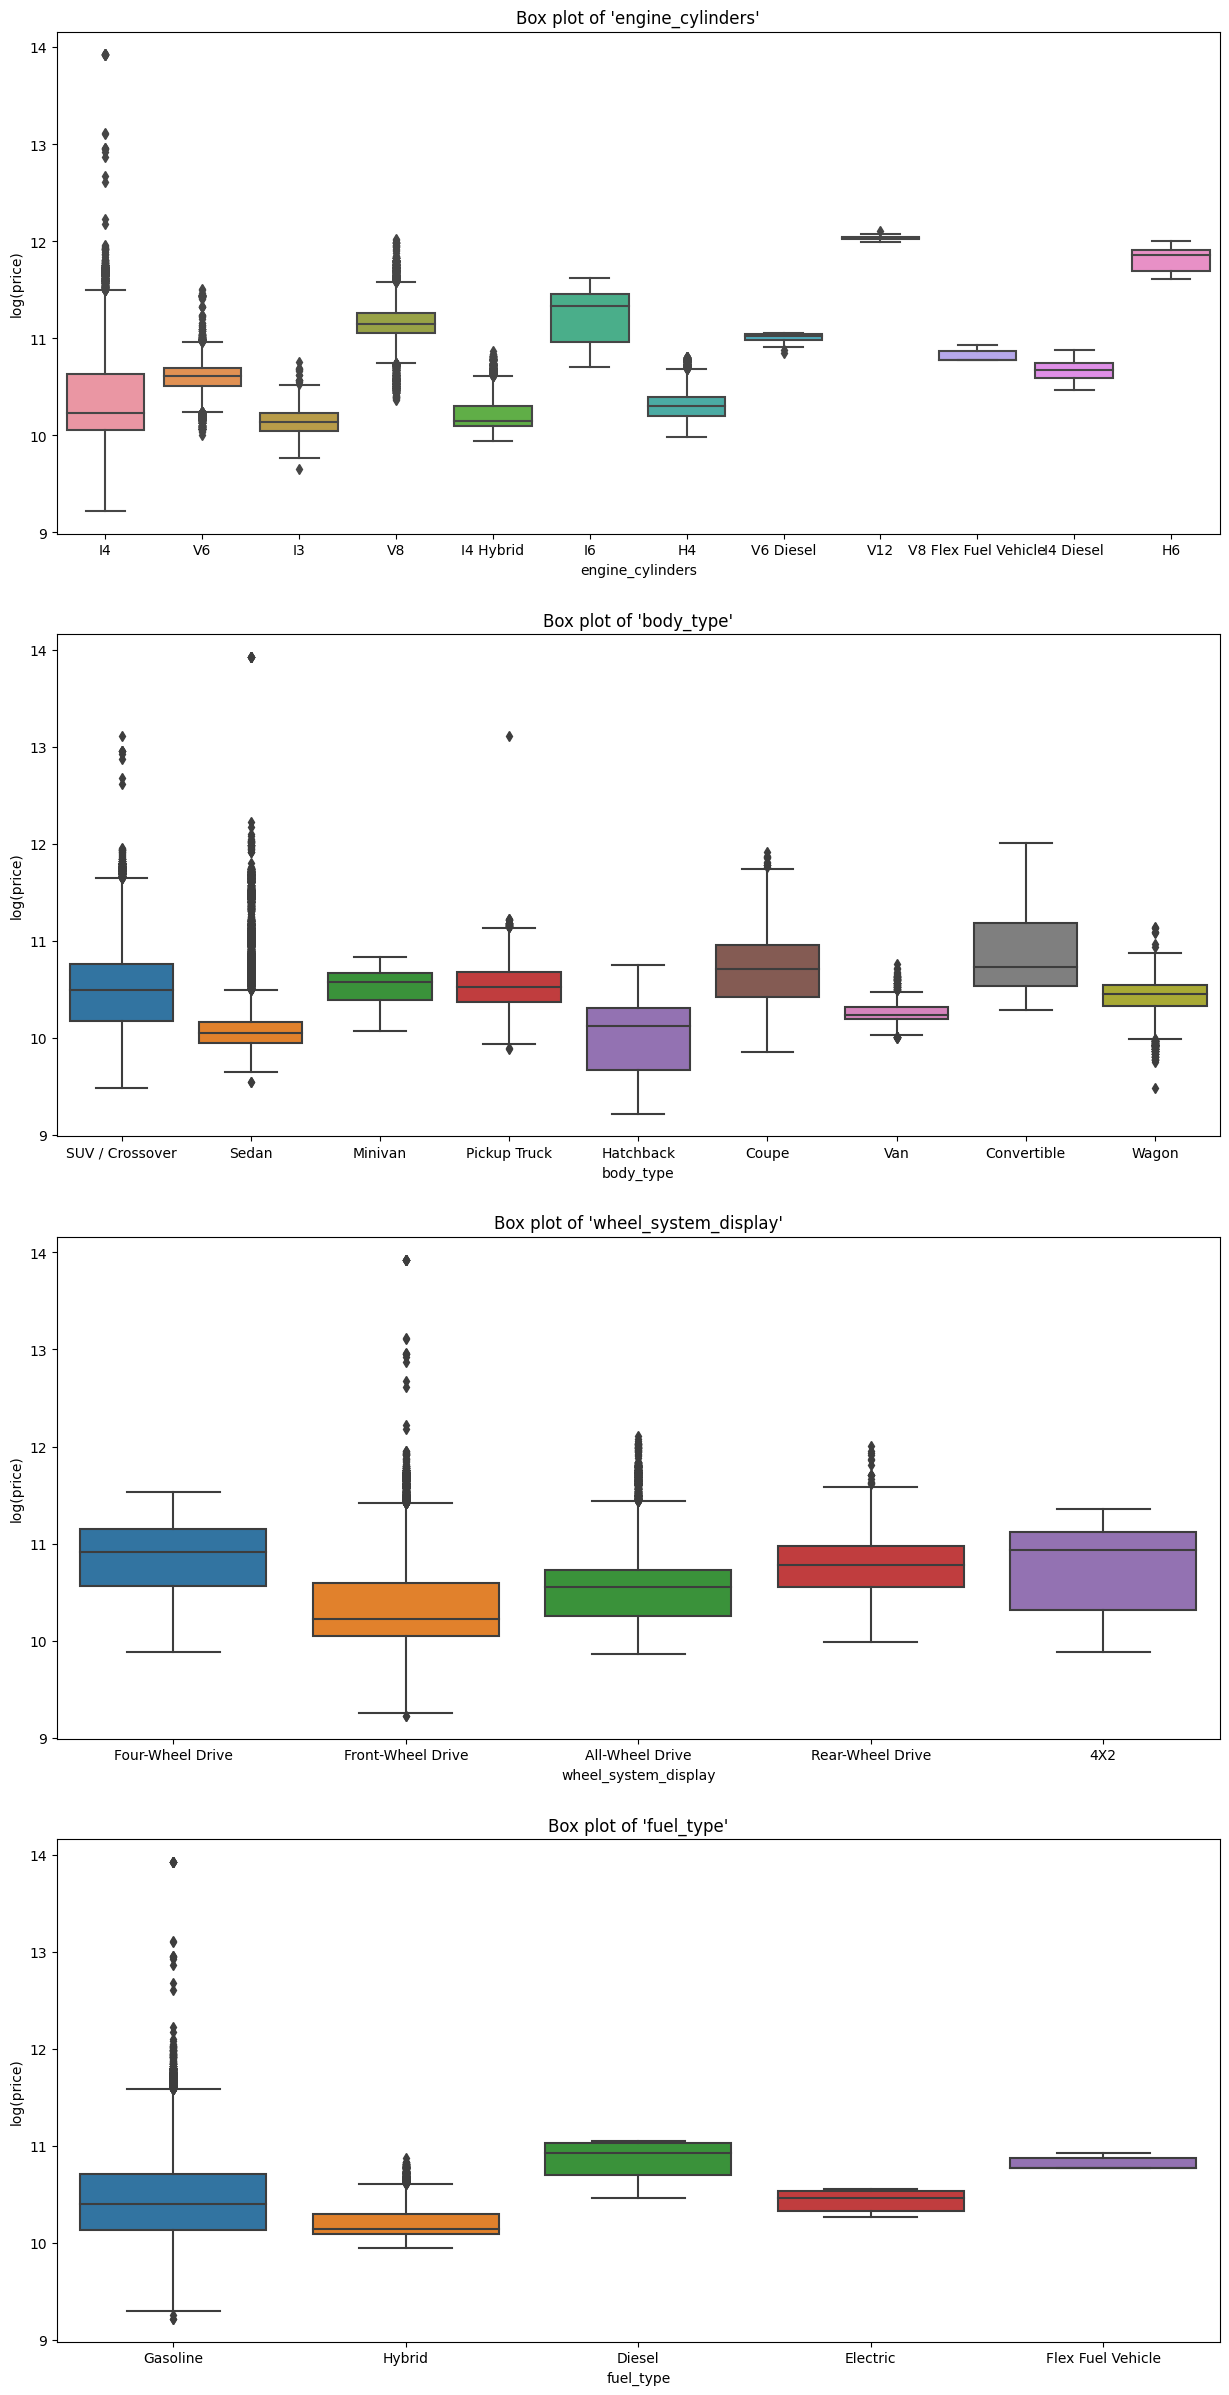

In [ ]:
fig, axs = plt.subplots(4, 1, figsize = (15, 30))

# boxplot for engine_cylinders
sns.boxplot(x = used_cars_features['engine_cylinders'], y = np.log(used_cars_price['price']), ax = axs[0])
axs[0].set_title("Box plot of 'engine_cylinders'")
axs[0].set_xlabel('engine_cylinders')
axs[0].set_ylabel('log(price)')

# boxplot for body_type
sns.boxplot(x = used_cars_features['body_type'], y = np.log(used_cars_price['price']), ax = axs[1])
axs[1].set_title("Box plot of 'body_type'")
axs[1].set_xlabel('body_type')
axs[1].set_ylabel('log(price)')

# boxplot for wheel_system_display
sns.boxplot(x = used_cars_features['wheel_system_display'], y = np.log(used_cars_price['price']), ax = axs[2])
axs[2].set_title("Box plot of 'wheel_system_display'")
axs[2].set_xlabel('wheel_system_display')
axs[2].set_ylabel('log(price)')

# boxplot for fuel_type
sns.boxplot(x = used_cars_features['fuel_type'], y = np.log(used_cars_price['price']), ax = axs[3])
axs[3].set_title("Box plot of 'fuel_type'")
axs[3].set_xlabel('fuel_type')
axs[3].set_ylabel('log(price)')

plt.show()

## 4.6 Box plots of numerical features

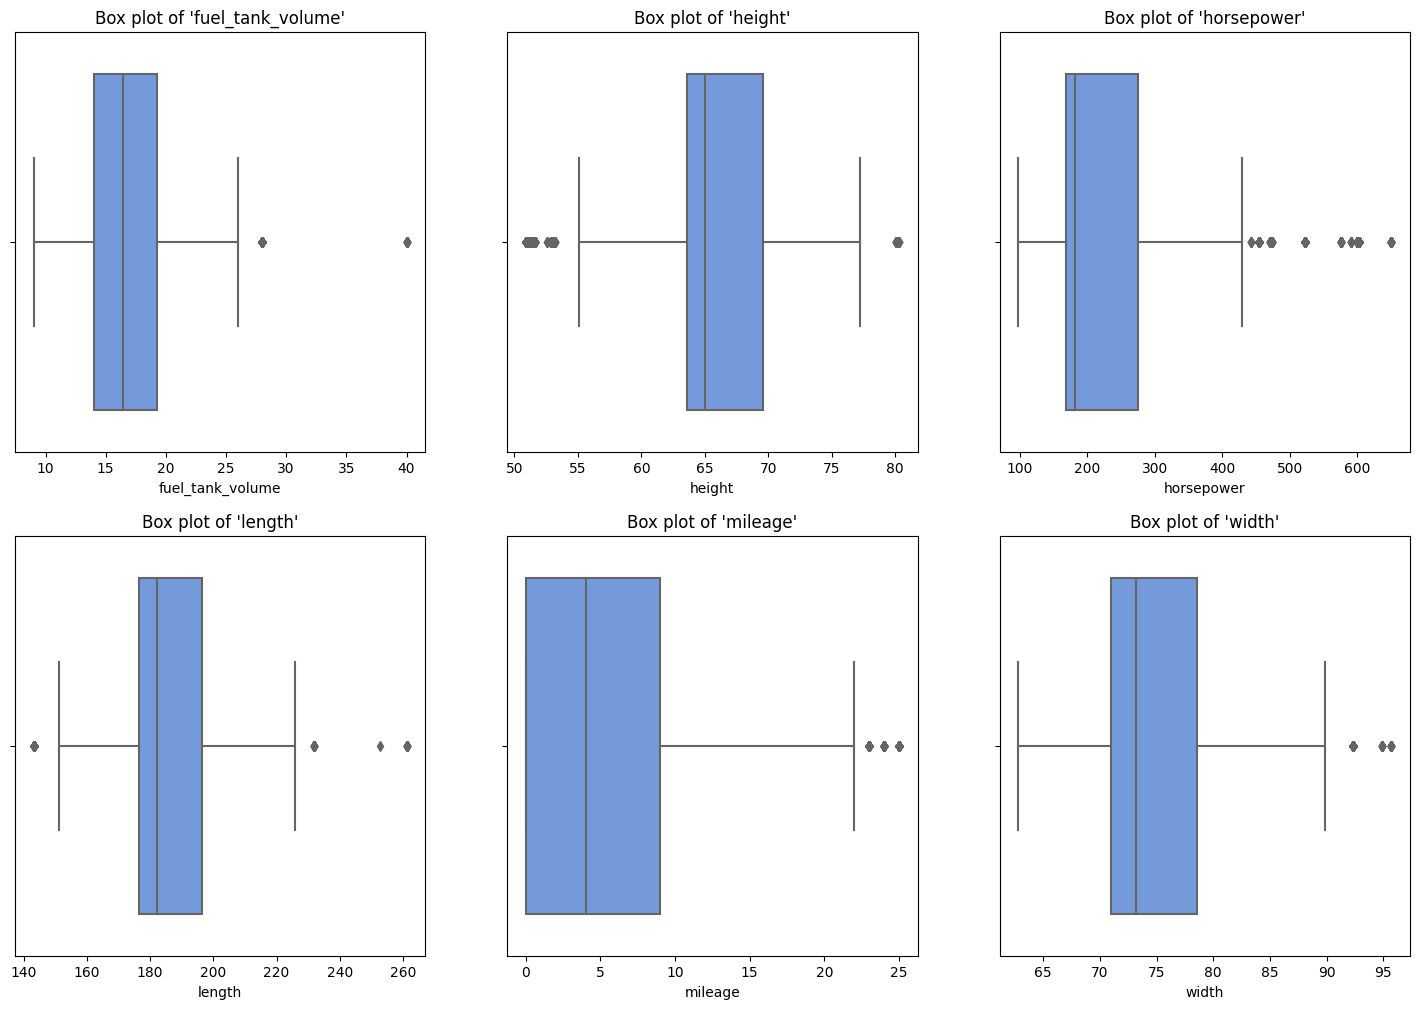

In [ ]:
fig, axs = plt.subplots(2, 3, figsize = (18, 12))

numerical_features =  ['fuel_tank_volume', 'height', 'horsepower', 'length', 'mileage', 'width']

for idx, feature in enumerate(numerical_features):
  row = idx//3
  col = idx%3
  # box subplot for the 'price'
  sns.boxplot(ax = axs[row, col], x = feature, data = used_cars_features, color = 'cornflowerblue', palette = None);
  axs[row, col].set_title(f"Box plot of '{feature}'")

## 4.7 Prepare train, validation and test datasets

In [ ]:
X = used_cars_features.copy()
y = used_cars_price['price'].copy().to_numpy().reshape(-1, 1)

feature_names = list(X.columns)

q1 = np.percentile(y, 25)
q3 = np.percentile(y, 75)
upper_limit = q3 + 1.5 * (q3 - q1)
lower_limit = q1 - 1.5 * (q3 - q1)

# Use this encoding to split the outliers uniformly across dev and test datasets!!!
y_binary = np.where(y <= upper_limit, 0, 1)

# 60% train, 20% validation, and 20% test dataset
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y_binary)

# Use this encoding to split the outliers uniformly across train and val datasets!!!
y_binary_dev = np.where(y_dev <= upper_limit, 0, 1)
dev_indices = np.arange(X_dev.shape[0])

X_train, X_val, y_train, y_val, train_indices, val_indices = train_test_split(X_dev, y_dev, dev_indices, 
                                                                              test_size = 0.25, random_state = 42, stratify = y_binary_dev)

print("Shape of train dataset: ", X_train.shape)
print("Shape of validation dataset: ", X_val.shape)
print("Shape of test dataset: ", X_test.shape)

# log transformation of the target 'price' to reduce the skewness
y_train = np.log(y_train)
y_val = np.log(y_val)
y_test = np.log(y_test)

y_dev = np.log(y_dev)

Shape of train dataset:  (103545, 28)
Shape of validation dataset:  (34515, 28)
Shape of test dataset:  (34515, 28)


## 4.8 Encoding the categorical features

In [ ]:
# Encoding the categorical variables
# Categorical features: ['body_type', 'city', 'engine_cylinders', 'exterior_color', 'franchise_make', 'fuel_type',
# 'interior_color', 'listing_color', 'make_name', 'model_name', 'transmission_display',
# 'trim_name', 'wheel_system_display'] -- 13

# Boolean features: ['franchise_dealer', 'is_new'] -- 2
used_cars_features["franchise_dealer"] = used_cars_features["franchise_dealer"].astype(int)
used_cars_features["is_new"] = used_cars_features["is_new"].astype(int)

ohe_features = ["body_type", "wheel_system_display"]
ord_features = ["engine_cylinders", "fuel_type"]

te_features = [
    "city",
    "listing_color",
    "interior_color",
    "make_name",
    "franchise_make",
    "transmission_display",
]

# these features when 'target' encoded show high coefficient of determination with 'price' to be predicted
# this is not an ideal scenario and so these features are encoded using Binary encoding
# Binary encoding is similar to one-hot encoding but with reduced dimensionality
binary_enc_features = ["trim_name", "model_name"]

rem_features = ['body_type', 'engine_cylinders', 'fuel_type', 'wheel_system_display']

# Importance assigned based on usually observed sale prices
ordinal_enc = OrdinalEncoder(categories = [[ "Gasoline", "Diesel", "Flex Fuel Vehicle", "Hybrid", "Electric"]])
X_train["ord_fuel_type"] = ordinal_enc.fit_transform(X_train["fuel_type"].to_numpy().reshape(-1, 1))
X_train = X_train.drop("fuel_type", axis = 1)
X_val["ord_fuel_type"] = ordinal_enc.transform(X_val["fuel_type"].to_numpy().reshape(-1, 1))
X_val = X_val.drop("fuel_type", axis = 1)
X_test["ord_fuel_type"] = ordinal_enc.transform(X_test["fuel_type"].to_numpy().reshape(-1, 1))
X_test = X_test.drop("fuel_type", axis = 1)
X_dev["ord_fuel_type"] = ordinal_enc.transform(X_dev["fuel_type"].to_numpy().reshape(-1, 1))
X_dev = X_dev.drop("fuel_type", axis = 1)

# H6, V12 are additional categories
ordinal_enc = OrdinalEncoder(categories = [['I3', 'H4', 'I4', 'I4 Diesel', 'H6', 'I4 Hybrid', 'I6', 
                                            'V6', 'V6 Diesel', 'V8', 'V8 Flex Fuel Vehicle', 'V12']])
X_train["ord_engine_cylinders"] = ordinal_enc.fit_transform(X_train["engine_cylinders"].to_numpy().reshape(-1, 1))
X_train = X_train.drop("engine_cylinders", axis = 1)
X_val["ord_engine_cylinders"] = ordinal_enc.transform(X_val["engine_cylinders"].to_numpy().reshape(-1, 1))
X_val = X_val.drop("engine_cylinders", axis = 1)
X_test["ord_engine_cylinders"] = ordinal_enc.transform(X_test["engine_cylinders"].to_numpy().reshape(-1, 1))
X_test = X_test.drop("engine_cylinders", axis = 1)
X_dev["ord_engine_cylinders"] = ordinal_enc.transform(X_dev["engine_cylinders"].to_numpy().reshape(-1, 1))
X_dev = X_dev.drop("engine_cylinders", axis = 1)

X_train = pd.get_dummies(X_train, columns = ohe_features)
X_val = pd.get_dummies(X_val, columns = ohe_features)
X_test = pd.get_dummies(X_test, columns = ohe_features)
X_dev = pd.get_dummies(X_dev, columns = ohe_features)

for feat in te_features:
  te = TargetEncoder(cols = [feat], handle_missing = 'value', handle_unknown = 'value').fit(X_train, y_train)
  X_train = te.transform(X_train)
  X_val = te.transform(X_val)
  X_test = te.transform(X_test)
  X_dev = te.transform(X_dev)

binary = BinaryEncoder(cols = binary_enc_features, return_df = True, handle_missing = 'value', handle_unknown = 'value')
X_train = binary.fit_transform(X_train)
X_val = binary.transform(X_val)
X_test = binary.transform(X_test)
X_dev = binary.transform(X_dev)

X_train.head()

back_legroom       city  daysonmarket  engine_displacement  \
171976          34.8  10.375320             3               1800.0   
24327           38.0  10.359323            15               2400.0   
161987          34.8  10.363398           106               1800.0   
140298          38.2  10.180128            31               2400.0   
6661            42.0  10.800095            40               6200.0   

        franchise_dealer  franchise_make  front_legroom  fuel_tank_volume  \
171976              True       10.124638           42.0              13.2   
24327               True       11.016923           41.5              16.4   
161987              True       10.124638           42.0              13.2   
140298              True       10.258880           41.5              16.4   
6661                True       10.553244           44.5              24.0   

        height  horsepower  ...  body_type_Pickup Truck  \
171976    56.5       139.0  ...                       0   
24327     65.0       182.0  ...                       0   
161987    56.5       139.0  ...                       0   
140298    65.0       181.0  ...                       0   
6661      75.9       420.0  ...                       0   

        body_type_SUV / Crossover  body_type_Sedan  body_type_Van  \
171976                          0                1              0   
24327                           1                0              0   
161987                          0                1              0   
140298                          1                0              0   
6661                            1                0              0   

        body_type_Wagon  wheel_system_display_4X2  \
171976                0                         0   
24327                 0                         0   
161987                0                         0   
140298                0                         0   
6661                  0                         0   

        wheel_system_display_All-Wheel Drive  \
171976                                     0   
24327                                      0   
161987                                     0   
140298                                     0   
6661                                       0   

        wheel_system_display_Four-Wheel Drive  \
171976                                      0   
24327                                       0   
161987                                      0   
140298                                      0   
6661                                        1   

        wheel_system_display_Front-Wheel Drive  \
171976                                       1   
24327                                        1   
161987                                       1   
140298                                       1   
6661                                         0   

        wheel_system_display_Rear-Wheel Drive  
171976                                      0  
24327                                       0  
161987                                      0  
140298                                      0  
6661                                        0  

[5 rows x 55 columns]

In [ ]:
# Plots to understand the issues with target encoding of certain features
# fig, axs = plt.subplots(5, 2, figsize = (16, 30))

# for idx, val in enumerate(te_features):
#     i = idx//2
#     j = idx%2
    
#     axs[i][j].scatter(X_train[val], y_train)
#     axs[i][j].set(xlabel = f"target encoded '{val}'", ylabel = "'price'")
#     axs[i][j].set_title(f"R2 score = {round(r2_score(y_train, X_train[val]), 4)}")

In [ ]:
# features in the dataset after encoding
X_train.columns

Index(['back_legroom', 'city', 'daysonmarket', 'engine_displacement',
       'franchise_dealer', 'franchise_make', 'front_legroom',
       'fuel_tank_volume', 'height', 'horsepower', 'interior_color', 'is_new',
       'length', 'listing_color', 'major_options', 'make_name',
       'maximum_seating', 'mileage', 'model_name_0', 'model_name_1',
       'model_name_2', 'model_name_3', 'model_name_4', 'model_name_5',
       'model_name_6', 'model_name_7', 'seller_rating', 'transmission_display',
       'trim_name_0', 'trim_name_1', 'trim_name_2', 'trim_name_3',
       'trim_name_4', 'trim_name_5', 'trim_name_6', 'trim_name_7',
       'trim_name_8', 'wheelbase', 'width', 'ord_fuel_type',
       'ord_engine_cylinders', 'body_type_Convertible', 'body_type_Coupe',
       'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck',
       'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van',
       'body_type_Wagon', 'wheel_system_display_4X2',
       'wheel_system_display_All

## 4.9 Correlation matrix

Features to be dropped:  ['make_name', 'wheelbase']


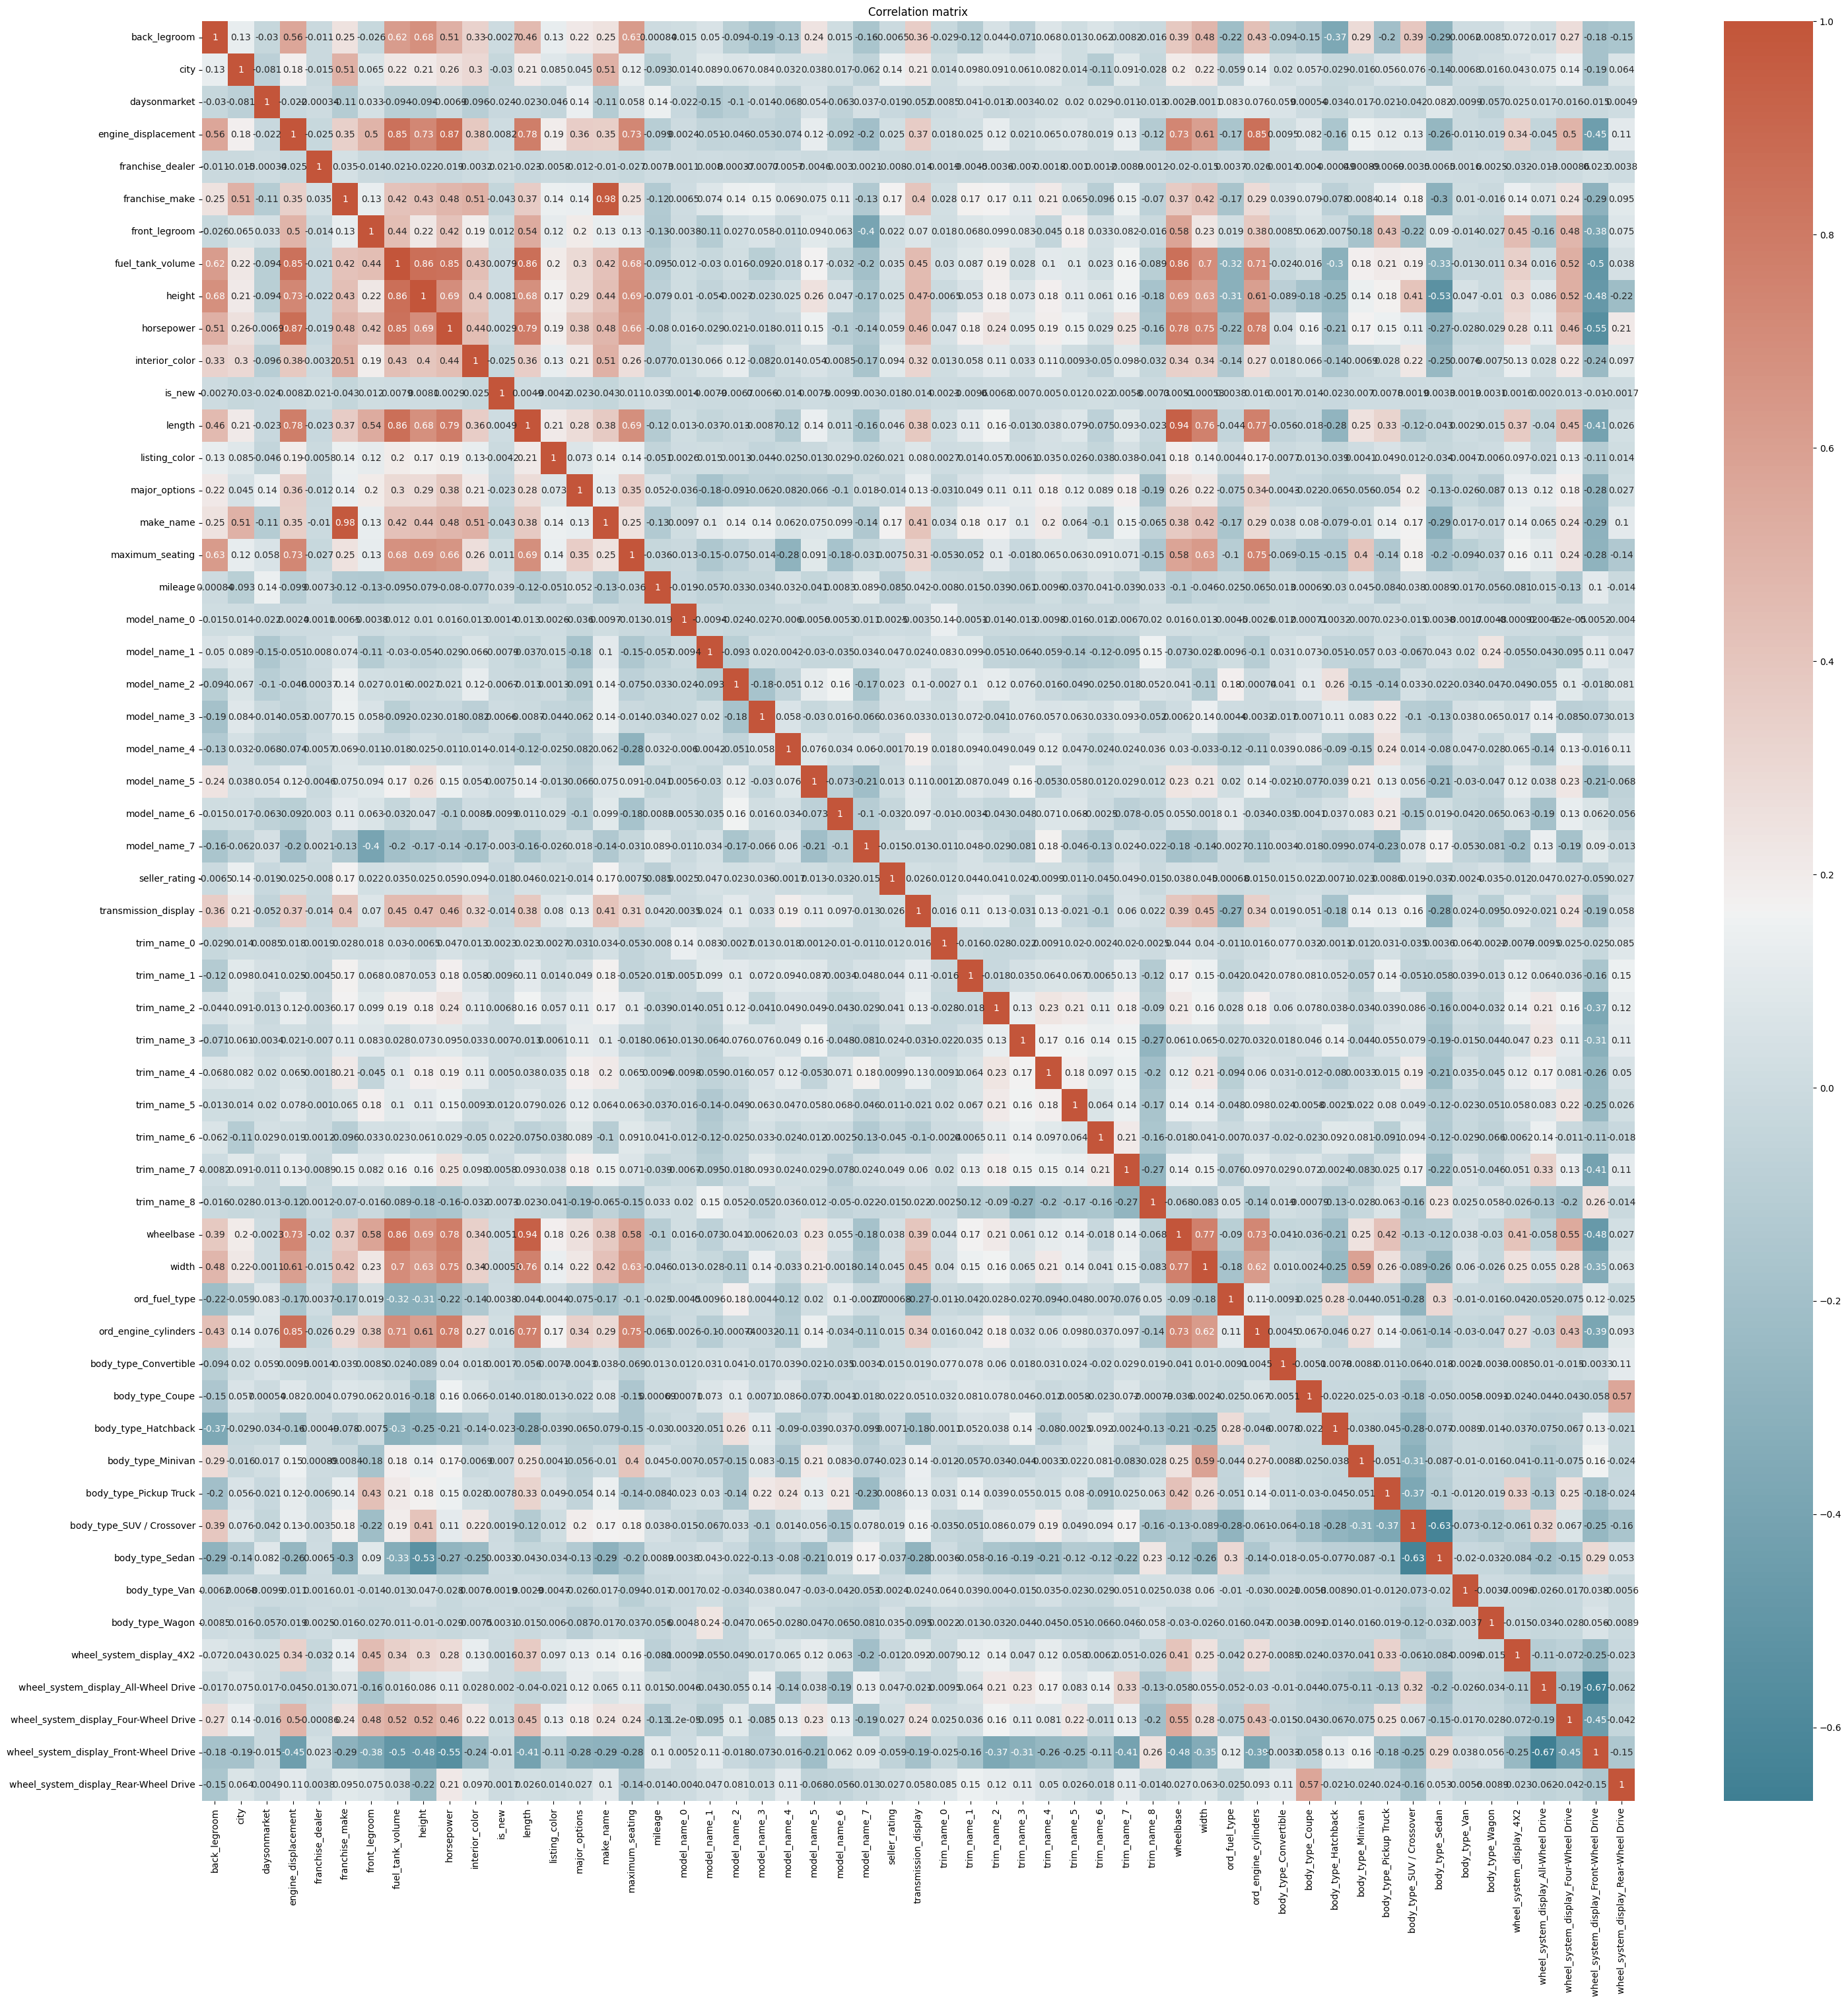

In [ ]:
# compute the correlation matrix
corr_matrix = X_train.corr()

plt.figure(figsize = (35, 35))
sns.heatmap(corr_matrix, cmap = sns.diverging_palette(220, 20, as_cmap=True), annot = True)
plt.title("Correlation matrix");
# plt.savefig('corr_matrix.png', format='png', dpi=600)

# compute the absolute correlation matrix
corr_matrix_abs = X_train.corr().abs()

# select upper triangle of the matrix
upper = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k = 1).astype(bool))

# select one of the features with high correlation 
to_drop = [column for column in upper.columns if any(upper[column] >= 0.9)]

print("Features to be dropped: ", to_drop)

# drop these features 
X_train.drop(to_drop, axis = 1, inplace=True)
X_val.drop(to_drop, axis = 1, inplace=True)
X_test.drop(to_drop, axis = 1, inplace=True)
X_dev.drop(to_drop, axis = 1, inplace=True)

## 4.10 Prepare the dataset

In [ ]:
# Scale the features in the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)      # Fit and transform scalar on train dataset
X_val_scaled = scaler.transform(X_val)              # Transform validation dataset
X_test_scaled = scaler.transform(X_test)            # Transform test dataset

X_dev_scaled = scaler.transform(X_dev)              # Transform dev dataset

In [ ]:
feature_names = list(X_train.columns)

In [ ]:
# Inverse the log transformation for computing the error metrics
y_dev_orig = np.exp(y_dev)
y_test_orig = np.exp(y_test)

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [0] * X_dev_scaled.shape[0]
for idx in train_indices:
  split_index[idx] = -1

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# Use PredefinedSplit in GridSearchCV (always uses the same validation dataset as test set in this search)

# **5. Models and Prediction**

## 5.1 Baseline model: Linear regression

In [ ]:
X_train_linear = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_val_linear = np.hstack([np.ones((X_val_scaled.shape[0], 1)), X_val_scaled])
X_test_linear = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

X_dev_linear = np.hstack([np.ones((X_dev_scaled.shape[0], 1)), X_dev_scaled])

In [ ]:
class LinearRegressionCustom():
    '''
    Linear regression model with L2-regularization (i.e. ridge regression).

    Attributes
    ----------
    alpha: regularization parameter
    w: (n x 1) weight vector
    '''
    
    def __init__(self, alpha = 0):
        self.alpha = alpha
        self.w = None

    def train(self, X, y):
        '''Trains model using ridge regression closed-form solution 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        None
        '''
        ### Your code here
        if type(y) is not np.ndarray:
            y = y.to_numpy()
        
        xT_x = (X.T) @ X
        I = np.identity(xT_x.shape[0])
        
        self.w = np.linalg.solve(xT_x + self.alpha * I, (X.T) @ y)       
        return
        
    def predict(self, X):
        '''Predicts on X using trained model.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) prediction vector
        '''
        ### Your code here
        y_pred = X @ self.w
        return y_pred  

In [ ]:
# Create and fit the model on dev dataset
lr_model = LinearRegressionCustom(alpha = 0)
lr_model.train(X_dev_linear, y_dev)

y_pred_dev_log = lr_model.predict(X_dev_linear)
y_pred_test_log = lr_model.predict(X_test_linear)

y_pred_dev = np.exp(y_pred_dev_log)
y_pred_test = np.exp(y_pred_test_log)

linear_r2_score_dev = r2_score(y_dev, y_pred_dev_log)
linear_r2_score_test = r2_score(y_test, y_pred_test_log)

linear_rmse_test = mean_squared_error(y_test_orig, y_pred_test, squared = False)
linear_mae_test = mean_absolute_error(y_test_orig, y_pred_test)
linear_mape_test = mean_absolute_percentage_error(y_test_orig, y_pred_test)
linear_rmsle_test = mean_squared_log_error(y_test_orig, y_pred_test, squared = False)

print("Linear Regression R2 score on the dev dataset: ", round(linear_r2_score_dev, 4))
print("Linear Regression R2 score on the test dataset: ", round(linear_r2_score_test, 4))

print("Linear Regression RMSE loss on the test dataset: ", round(linear_rmse_test, 4))
print("Linear Regression MAE loss on the test dataset: ", round(linear_mae_test, 4))
print("Linear Regression MAPE loss on the test dataset: ", round(linear_mape_test, 4))
print("Linear Regression RMSLE loss on the test dataset: ", round(linear_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_lr_roc_score = regression_roc_auc_score(y_test_orig, y_pred_test)
print("Linear Regression ranking ability (regression ROC): ", round(test_lr_roc_score, 4))

Linear Regression R2 score on the dev dataset:  0.8171
Linear Regression R2 score on the test dataset:  0.8085
Linear Regression RMSE loss on the test dataset:  14435.3147
Linear Regression MAE loss on the test dataset:  5278.0817
Linear Regression MAPE loss on the test dataset:  0.1305
Linear Regression RMSLE loss on the test dataset:  0.1759
Linear Regression ranking ability (regression ROC):  0.8596


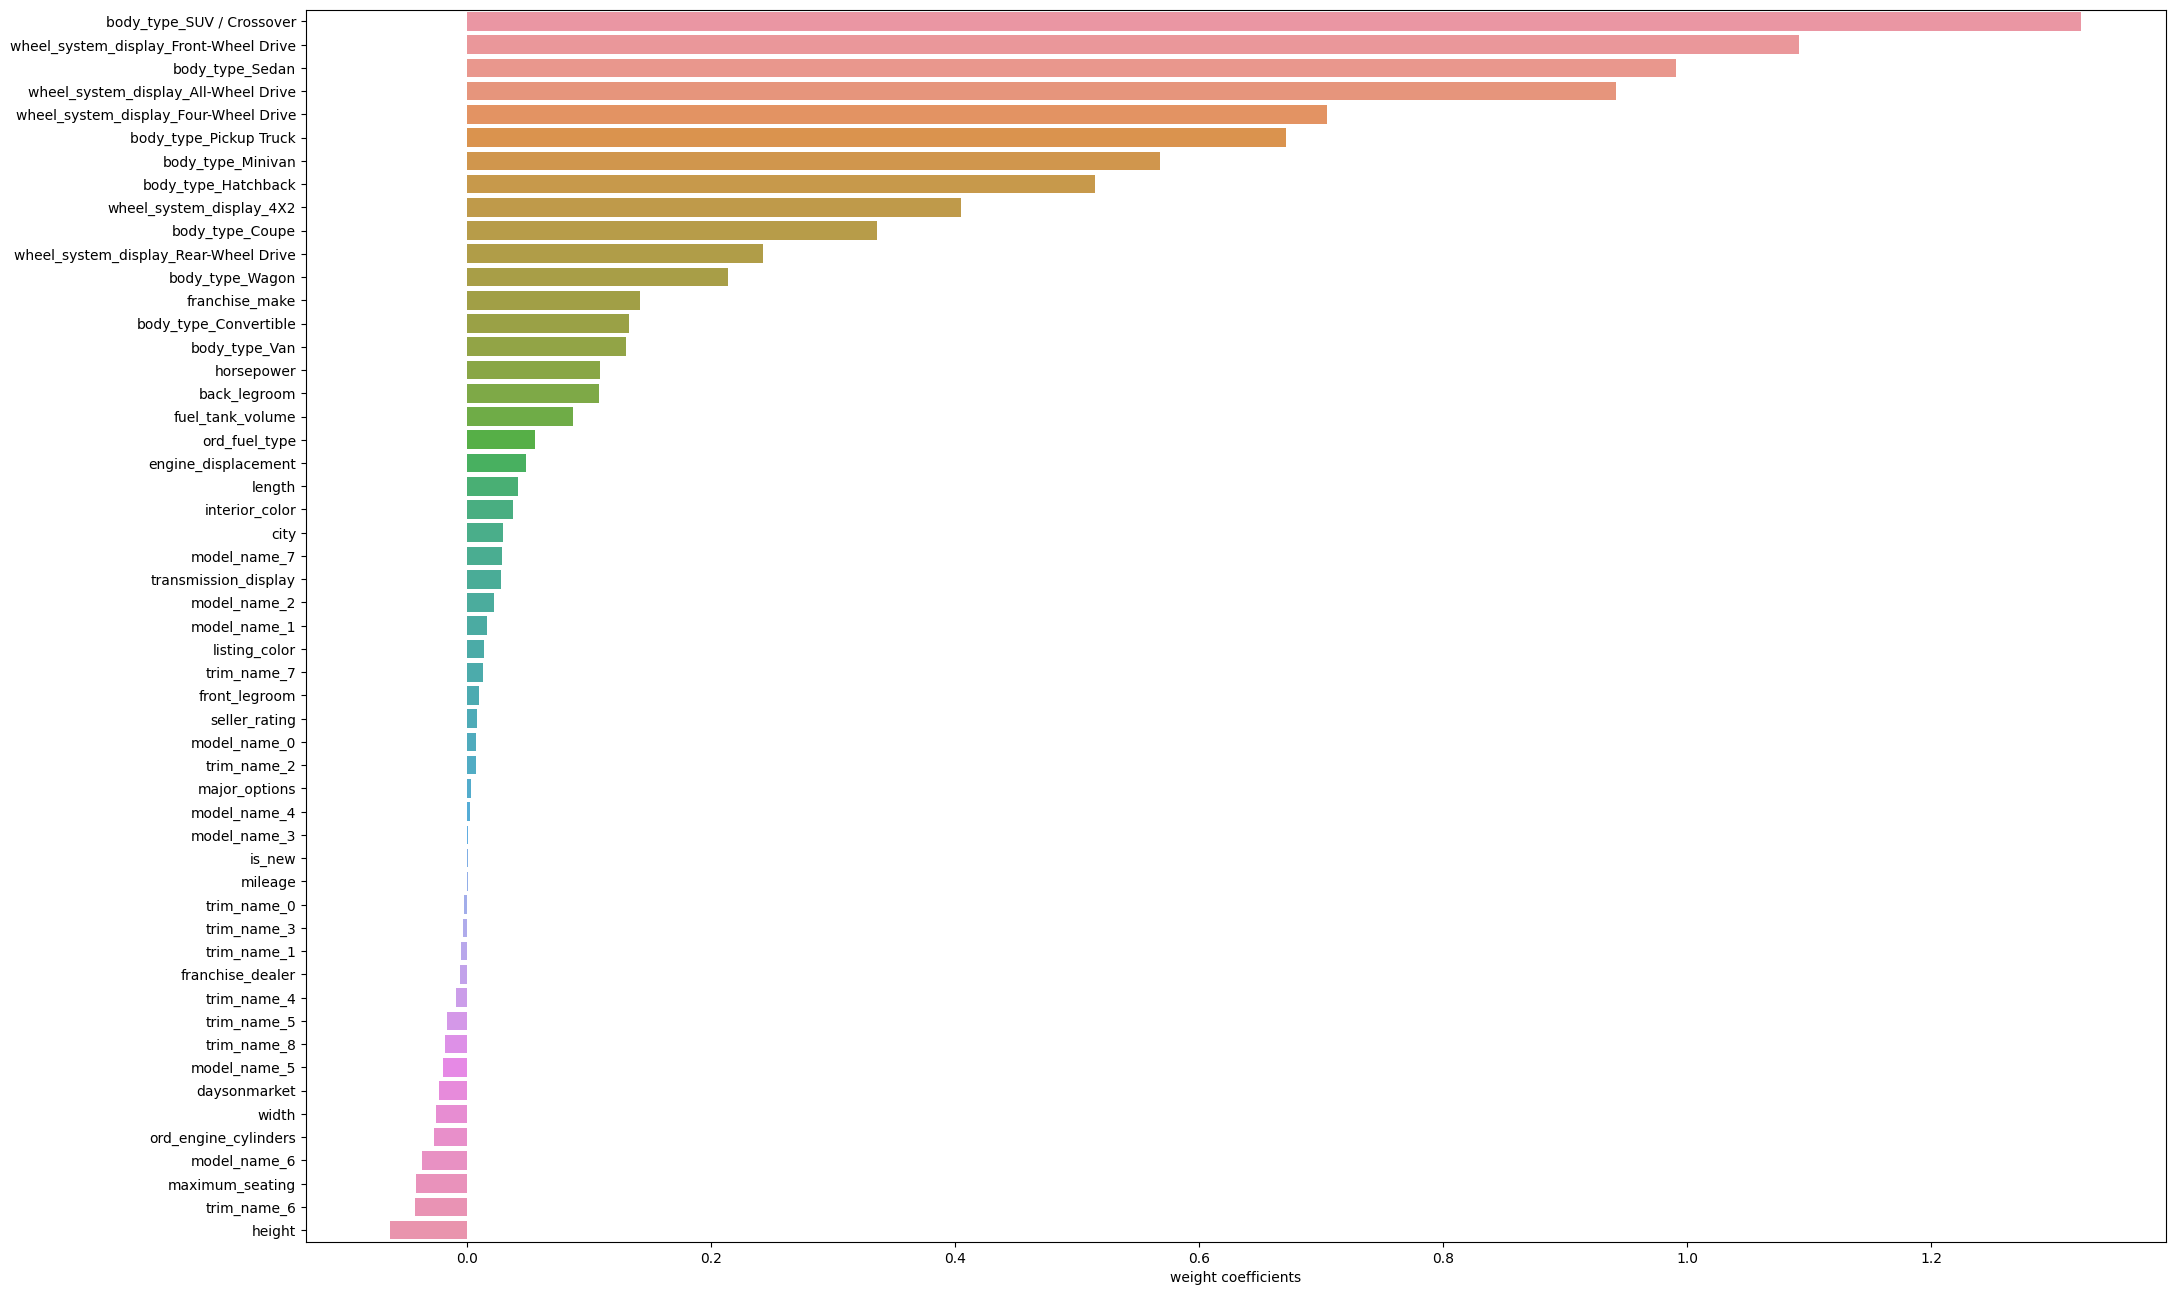

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (24, 16))

# 1st column represents the bias term (not needed here)
feat_imps = zip(feature_names, lr_model.w[1:, 0])
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');
# plt.savefig('linear_reg.png', format='png', dpi = 800)

Text(0.5, 1.0, 'Distribution of Linear residuals')

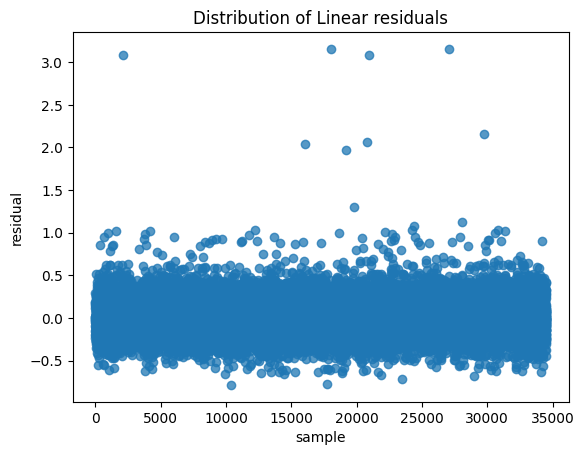

In [ ]:
# plot the distribution of errors/residuals
plt.scatter(np.arange(len(y_test)), (y_test - y_pred_test_log), alpha = 0.75)
plt.xlabel('sample')
plt.ylabel('residual')
plt.title('Distribution of Linear residuals')
# plt.show()
# plt.savefig('dist_residuals.png', format='png', dpi = 800)

## 5.2 Ridge regression

### 5.2.1 Default Ridge regression

In [ ]:
# Create and fit the default model on dev dataset
ridge_model = LinearRegressionCustom(alpha = 1.0)
ridge_model.train(X_dev_linear, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = ridge_model.predict(X_dev_linear)
y_test_pred_log = ridge_model.predict(X_test_linear)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_ridge_r2_score = r2_score(y_dev, y_dev_pred_log)
test_ridge_r2_score = r2_score(y_test, y_test_pred_log)

ridge_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
ridge_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
ridge_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
ridge_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Ridge Regression R2 score on the dev dataset: ", round(dev_ridge_r2_score, 4))
print("Ridge Regression R2 score on the test dataset: ", round(test_ridge_r2_score, 4))

print("Ridge Regression RMSE loss on the test dataset: ", round(ridge_rmse_test, 4))
print("Ridge Regression MAE loss on the test dataset: ", round(ridge_mae_test, 4))
print("Ridge Regression MAPE loss on the test dataset: ", round(ridge_mape_test, 4))
print("Ridge Regression RMSLE loss on the test dataset: ", round(ridge_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_lr_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Ridge Regression ranking ability (regression ROC): ", round(test_lr_roc_score, 4))

Ridge Regression R2 score on the dev dataset:  0.8171
Ridge Regression R2 score on the test dataset:  0.8085
Ridge Regression RMSE loss on the test dataset:  14435.4264
Ridge Regression MAE loss on the test dataset:  5277.8624
Ridge Regression MAPE loss on the test dataset:  0.1305
Ridge Regression RMSLE loss on the test dataset:  0.1759
Ridge Regression ranking ability (regression ROC):  0.8596


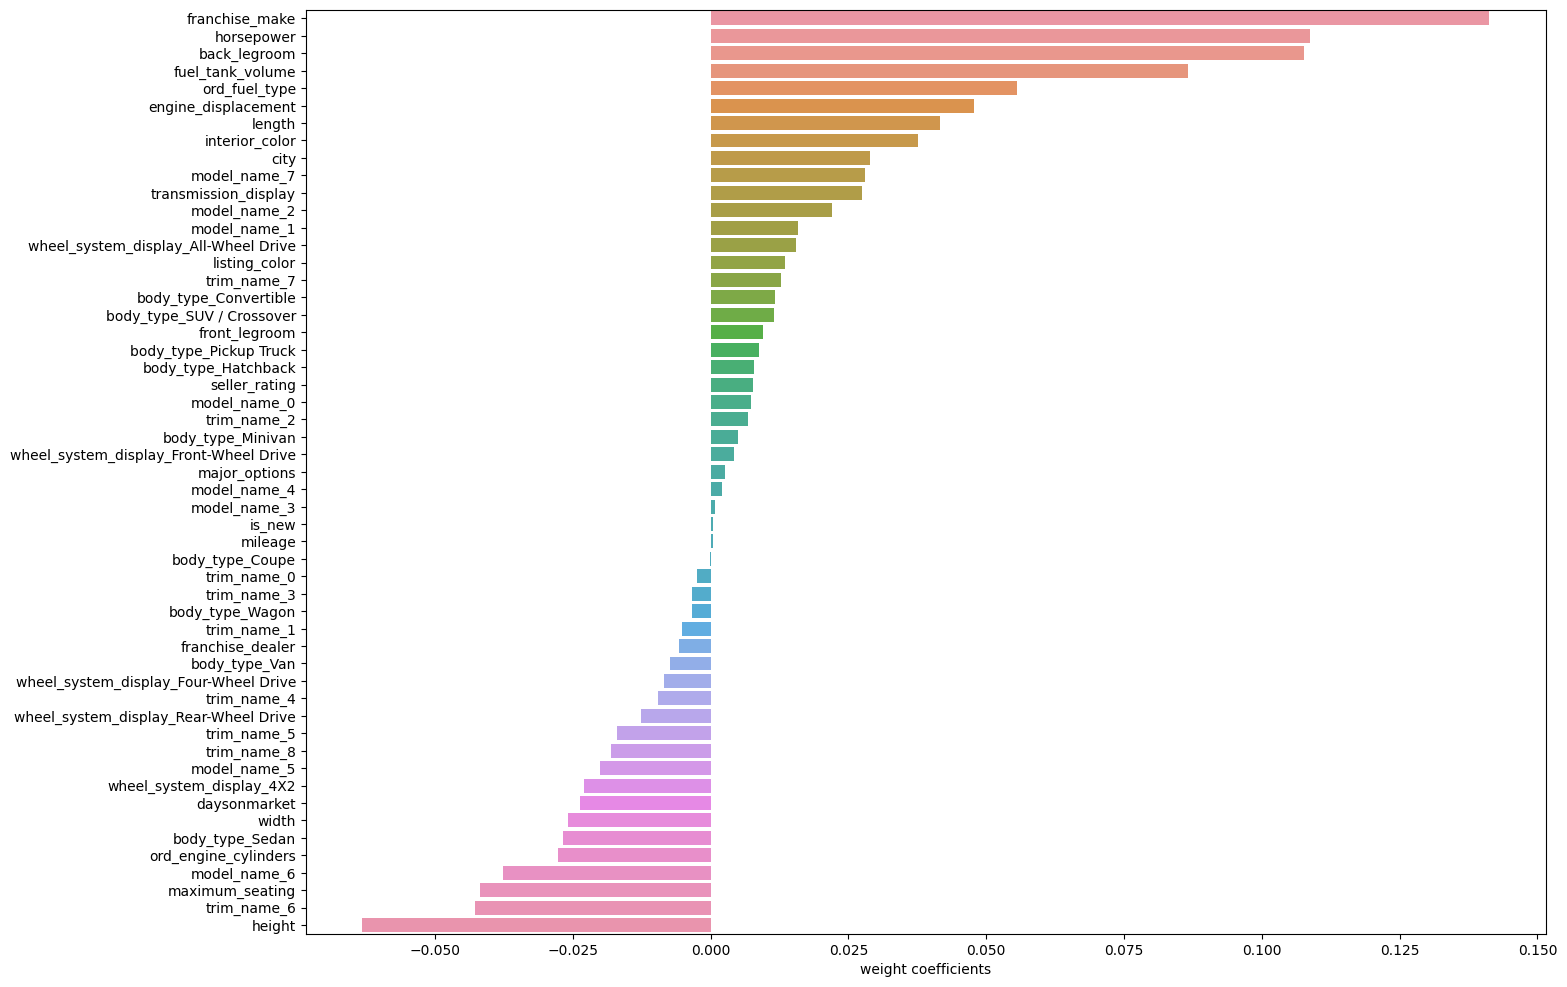

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (16, 12))

# 1st column represents the bias term (not needed here)
feat_imps = zip(feature_names, ridge_model.w[1:, 0])
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

### 5.2.2 Ridge regression with Grid Search

Alpha value with best validation performance:  13.2009
Ridge Regression R2 score on the dev dataset:  0.8171
Ridge Regression R2 score on the test dataset:  0.8084
Ridge Regression RMSE loss on the test dataset:  14436.843
Ridge Regression MAE loss on the test dataset:  5275.2721
Ridge Regression MAPE loss on the test dataset:  0.1303
Ridge Regression RMSLE loss on the test dataset:  0.1759
Ridge Regression ranking ability (regression ROC):  0.8596


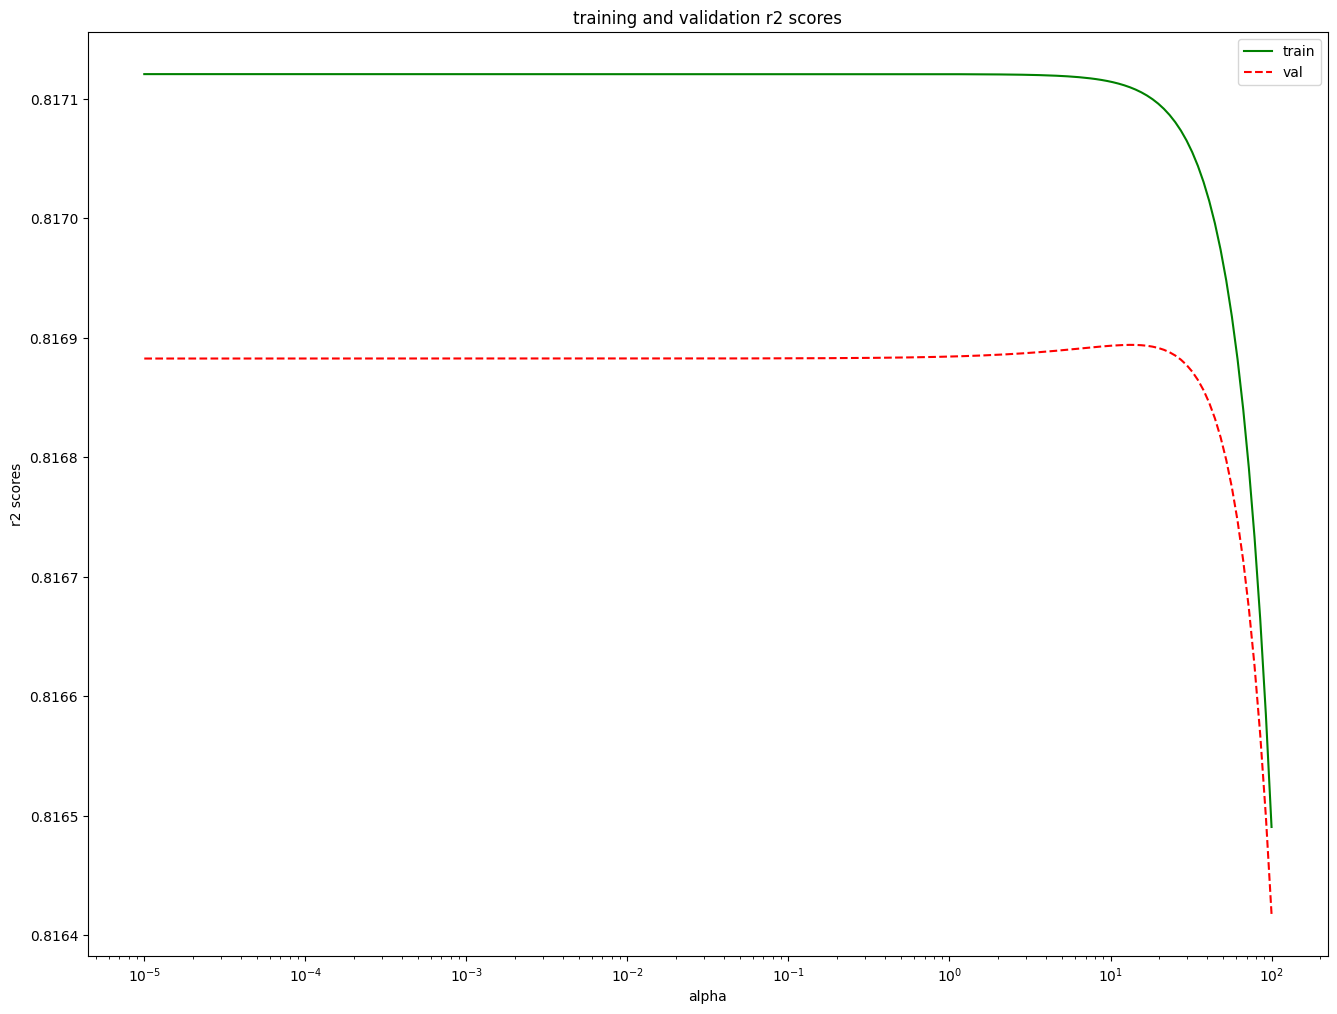

In [ ]:
# Create and fit the model on train dataset
best_val_score = 0
best_alpha = 1

r2score_train = []
r2score_val = []
alphas = np.logspace(-5, 2, num = 200)

for alpha_val in alphas:
  ridge_model = LinearRegressionCustom(alpha = alpha_val)
  ridge_model.train(X_train_linear, y_train)
  
  y_train_pred_log = ridge_model.predict(X_train_linear)
  y_val_pred_log = ridge_model.predict(X_val_linear)

  train_score = r2_score(y_train, y_train_pred_log)
  val_score = r2_score(y_val, y_val_pred_log)
    
  r2score_train.append(train_score)
  r2score_val.append(val_score)
  
  if best_val_score < val_score:
    best_val_score = val_score
    best_alpha = alpha_val

plt.figure(figsize = (16, 12))
plt.plot(alphas, r2score_train, 'g-', label = 'train')
plt.plot(alphas, r2score_val, 'r--', label = 'val')
plt.legend(loc="upper right")
plt.title('training and validation r2 scores')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('r2 scores');    

print("Alpha value with best validation performance: ", round(best_alpha, 4))
# Use this alpha value and train the best model on dev dataset
ridge_model = LinearRegressionCustom(alpha = best_alpha)
ridge_model.train(X_dev_linear, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = ridge_model.predict(X_dev_linear)
y_test_pred_log = ridge_model.predict(X_test_linear)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_ridge_r2_score = r2_score(y_dev, y_dev_pred_log)
test_ridge_r2_score = r2_score(y_test, y_test_pred_log)

ridge_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
ridge_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
ridge_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
ridge_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Ridge Regression R2 score on the dev dataset: ", round(dev_ridge_r2_score, 4))
print("Ridge Regression R2 score on the test dataset: ", round(test_ridge_r2_score, 4))

print("Ridge Regression RMSE loss on the test dataset: ", round(ridge_rmse_test, 4))
print("Ridge Regression MAE loss on the test dataset: ", round(ridge_mae_test, 4))
print("Ridge Regression MAPE loss on the test dataset: ", round(ridge_mape_test, 4))
print("Ridge Regression RMSLE loss on the test dataset: ", round(ridge_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_lr_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Ridge Regression ranking ability (regression ROC): ", round(test_lr_roc_score, 4))

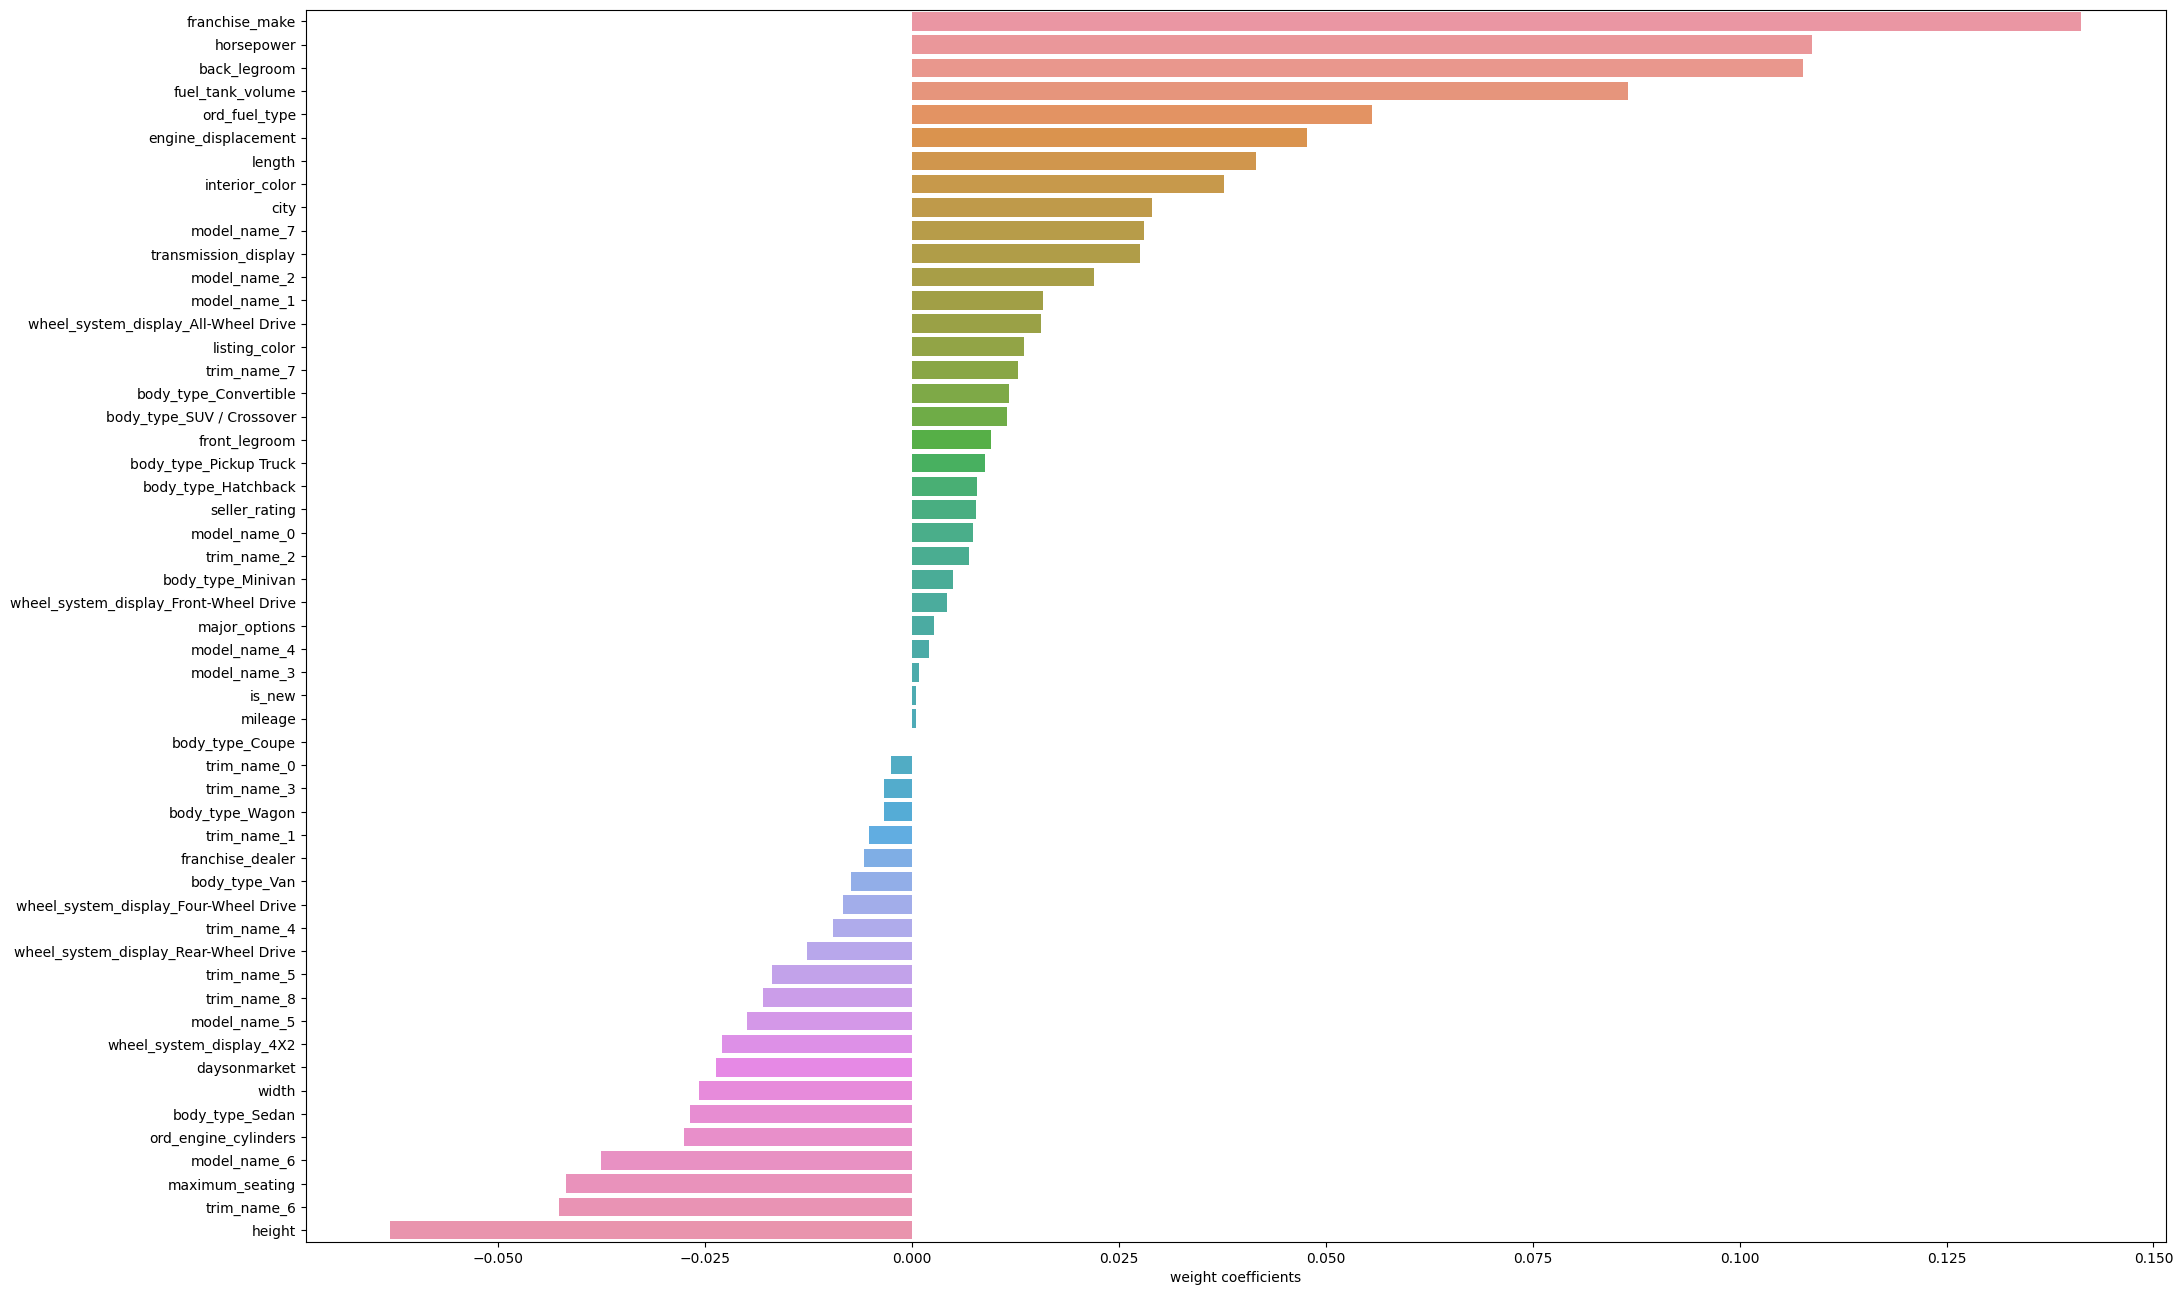

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (24, 16))

# 1st column represents the bias term (not needed here)
feat_imps = zip(feature_names, ridge_model.w[1:, 0])
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');
# plt.savefig('ridge_reg.png', format='png', dpi = 800)

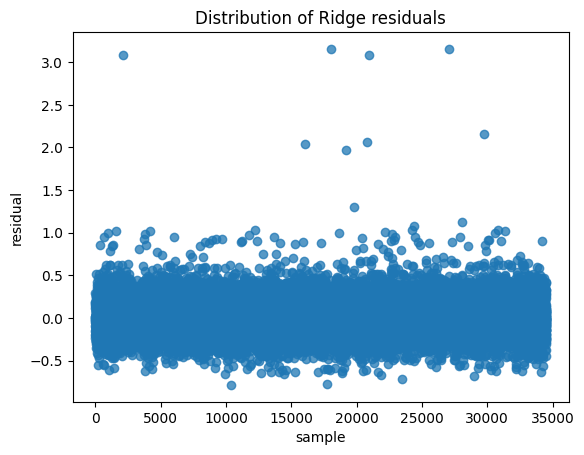

In [ ]:
# plot the distribution of errors/residuals
plt.scatter(np.arange(len(y_test)), (y_test - y_pred_test_log), alpha = 0.75)
plt.xlabel('sample')
plt.ylabel('residual')
plt.title('Distribution of Ridge residuals')
plt.show()

## 5.3 Elastic Net Regression






### 5.3.1 Default Elastic Net regression

In [ ]:
elastic_net = ElasticNet()

# fit the model
elastic_net.fit(X_dev_scaled, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = elastic_net.predict(X_dev_scaled)
y_test_pred_log = elastic_net.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_eln_r2_score = r2_score(y_dev, y_dev_pred_log)
test_eln_r2_score = r2_score(y_test, y_test_pred_log)

eln_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
eln_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
eln_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
eln_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Elastic net Regression R2 score on the dev dataset: ", round(dev_eln_r2_score, 4))
print("Elastic net Regression R2 score on the test dataset: ", round(test_eln_r2_score, 4))

print("Elastic net Regression RMSE loss on the test dataset: ", round(eln_rmse_test, 4))
print("Elastic net Regression MAE loss on the test dataset: ", round(eln_mae_test, 4))
print("Elastic net Regression MAPE loss on the test dataset: ", round(eln_mape_test, 4))
print("Elastic net Regression RMSLE loss on the test dataset: ", round(eln_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_en_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Elastic net Regression ranking ability (regression ROC): ", round(test_en_roc_score, 4))

Elastic net Regression R2 score on the dev dataset:  0.0
Elastic net Regression R2 score on the test dataset:  -0.0001
Elastic net Regression RMSE loss on the test dataset:  21084.9667
Elastic net Regression MAE loss on the test dataset:  12730.0606
Elastic net Regression MAPE loss on the test dataset:  0.3366
Elastic net Regression RMSLE loss on the test dataset:  0.4019
Elastic net Regression ranking ability (regression ROC):  0.5001


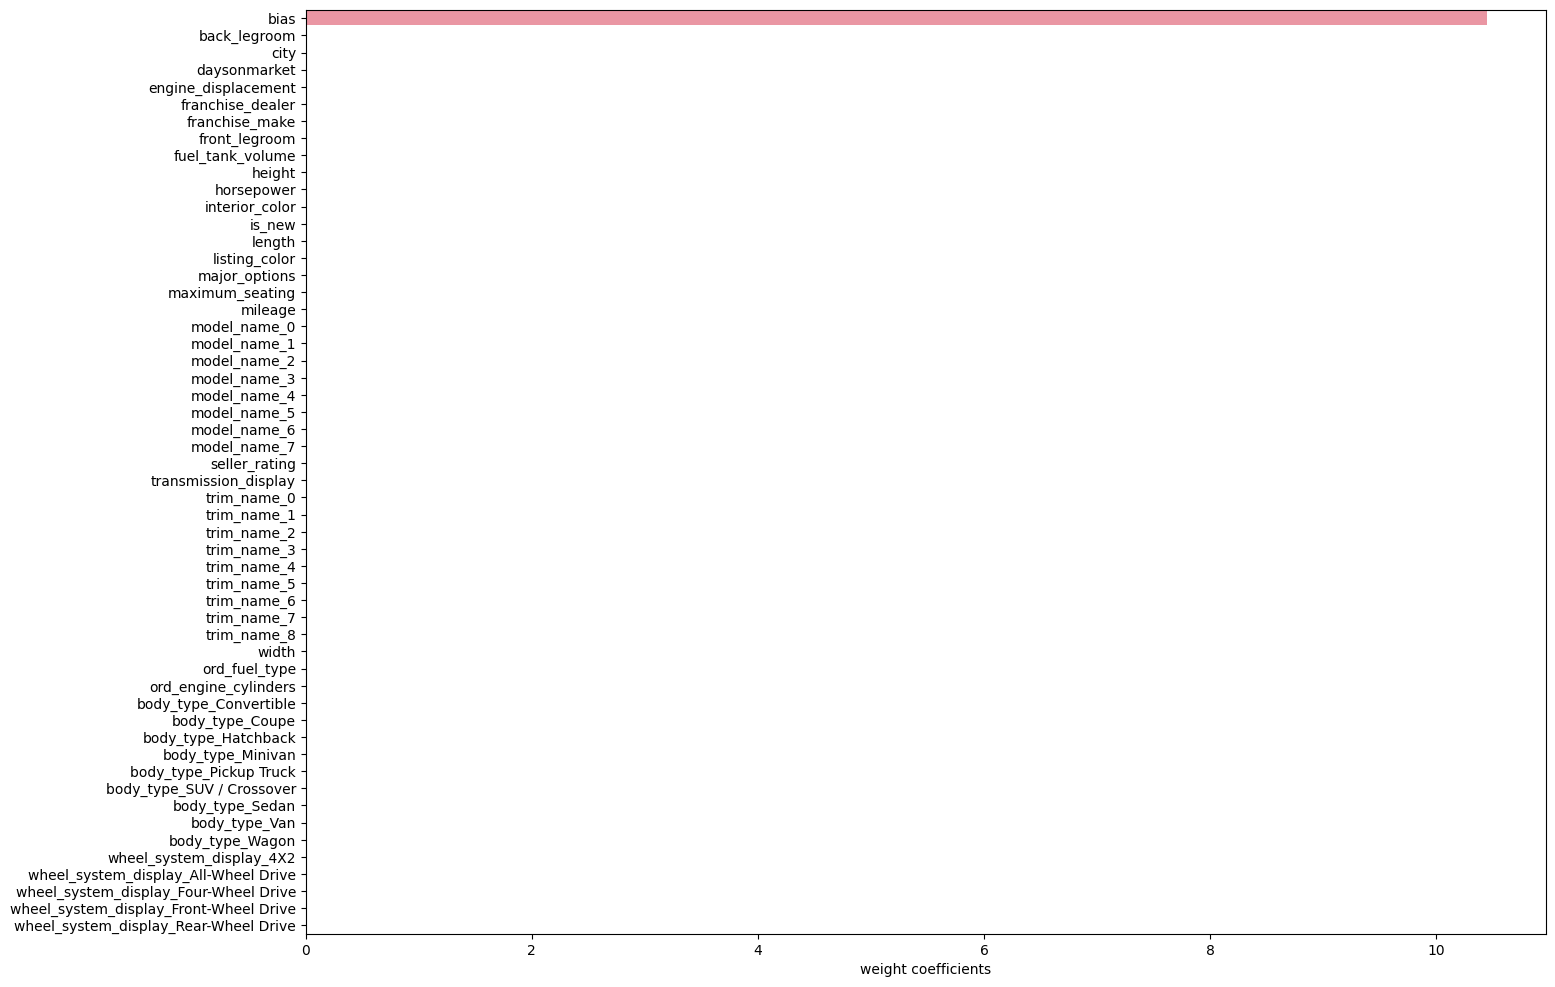

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (16, 12))

feat_imps = zip(feature_names + ["bias"], list(elastic_net.coef_) + list(elastic_net.intercept_))
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

### 5.3.2 Elastic Net regression with Grid Search

In [ ]:
# hyperparameter tuning
import warnings
warnings.simplefilter("ignore")

best_score = -float('inf')
best_hyperparameters = None

param_grid = {
    'alpha': np.logspace(-5, 2, num = 10),
    'l1_ratio': np.logspace(-2, 0, num = 10)
}

best_eln_regressor = GridSearchCV(estimator = ElasticNet(), cv = pds, param_grid = param_grid, 
                   scoring = 'r2', n_jobs = -1)

# Fit with all data
best_eln_regressor.fit(X_dev_scaled, y_dev)

# Best hyperparameters
print("Best hyperparameters: ", best_eln_regressor.best_params_)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = best_eln_regressor.predict(X_dev_scaled)
y_test_pred_log = best_eln_regressor.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_eln_r2_score = r2_score(y_dev, y_dev_pred_log)
test_eln_r2_score = r2_score(y_test, y_test_pred_log)

eln_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
eln_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
eln_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
eln_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Elastic net Regression R2 score on the dev dataset: ", round(dev_eln_r2_score, 4))
print("Elastic net Regression R2 score on the test dataset: ", round(test_eln_r2_score, 4))

print("Elastic net Regression RMSE loss on the test dataset: ", round(eln_rmse_test, 4))
print("Elastic net Regression MAE loss on the test dataset: ", round(eln_mae_test, 4))
print("Elastic net Regression MAPE loss on the test dataset: ", round(eln_mape_test, 4))
print("Elastic net Regression RMSLE loss on the test dataset: ", round(eln_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_en_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Elastic net Regression ranking ability (regression ROC): ", round(test_en_roc_score, 4))

Best hyperparameters:  {'alpha': 1e-05, 'l1_ratio': 0.01}
Elastic net Regression R2 score on the dev dataset:  0.8171
Elastic net Regression R2 score on the test dataset:  0.8085
Elastic net Regression RMSE loss on the test dataset:  14435.287
Elastic net Regression MAE loss on the test dataset:  5278.0602
Elastic net Regression MAPE loss on the test dataset:  0.1305
Elastic net Regression RMSLE loss on the test dataset:  0.1759
Elastic net Regression ranking ability (regression ROC):  0.8596


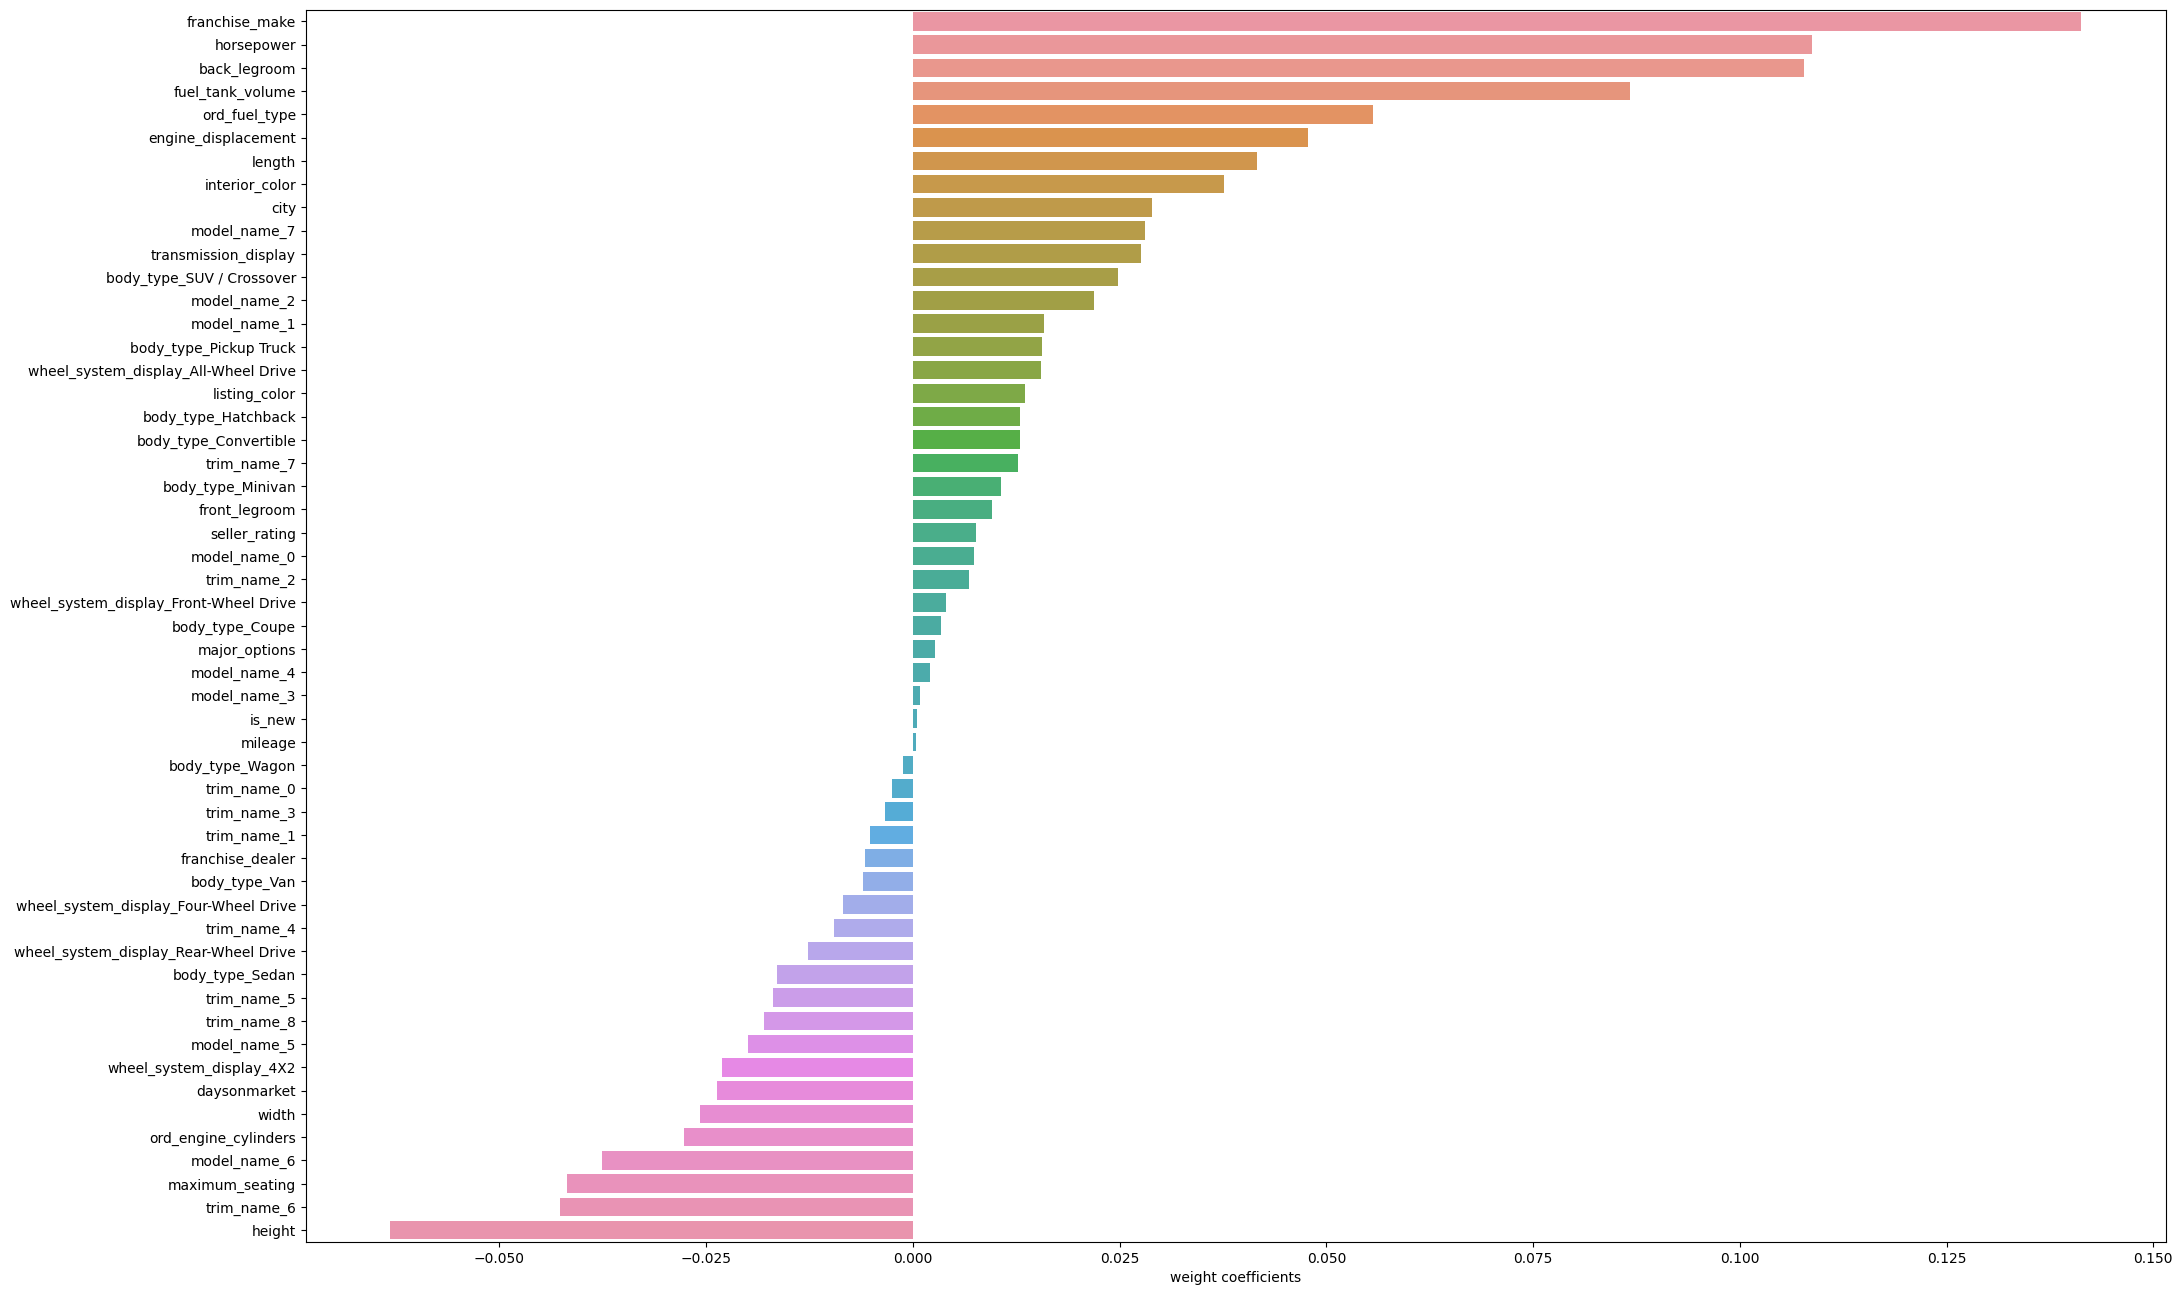

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (24, 16))

feat_imps = zip(feature_names, best_eln_regressor.best_estimator_.coef_)
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

# plt.savefig('elastic_net_weights.png', format='png', dpi = 800)

## 5.4 Decision tree

### 5.4.1 Default Decision tree

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(X_dev_scaled, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = dtr.predict(X_dev_scaled)
y_test_pred_log = dtr.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_eln_r2_score = r2_score(y_dev, y_dev_pred_log)
test_eln_r2_score = r2_score(y_test, y_test_pred_log)

dtr_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
dtr_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
dtr_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
dtr_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Decison Tree R2 score on the dev dataset: ", round(dev_eln_r2_score, 4))
print("Decison Tree R2 score on the test dataset: ", round(test_eln_r2_score, 4))

print("Decison Tree RMSE loss on the test dataset: ", round(dtr_rmse_test, 4))
print("Decison Tree MAE loss on the test dataset: ", round(dtr_mae_test, 4))
print("Decison Tree MAPE loss on the test dataset: ", round(dtr_mape_test, 4))
print("Decison Tree RMSLE loss on the test dataset: ", round(dtr_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_dtr_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Decison Tree ranking ability (regression ROC): ", round(test_dtr_roc_score, 4))

Decison Tree R2 score on the dev dataset:  0.999
Decison Tree R2 score on the test dataset:  0.97
Decison Tree RMSE loss on the test dataset:  5215.8968
Decison Tree MAE loss on the test dataset:  1468.1163
Decison Tree MAPE loss on the test dataset:  0.0354
Decison Tree RMSLE loss on the test dataset:  0.0697
Decison Tree ranking ability (regression ROC):  0.9573


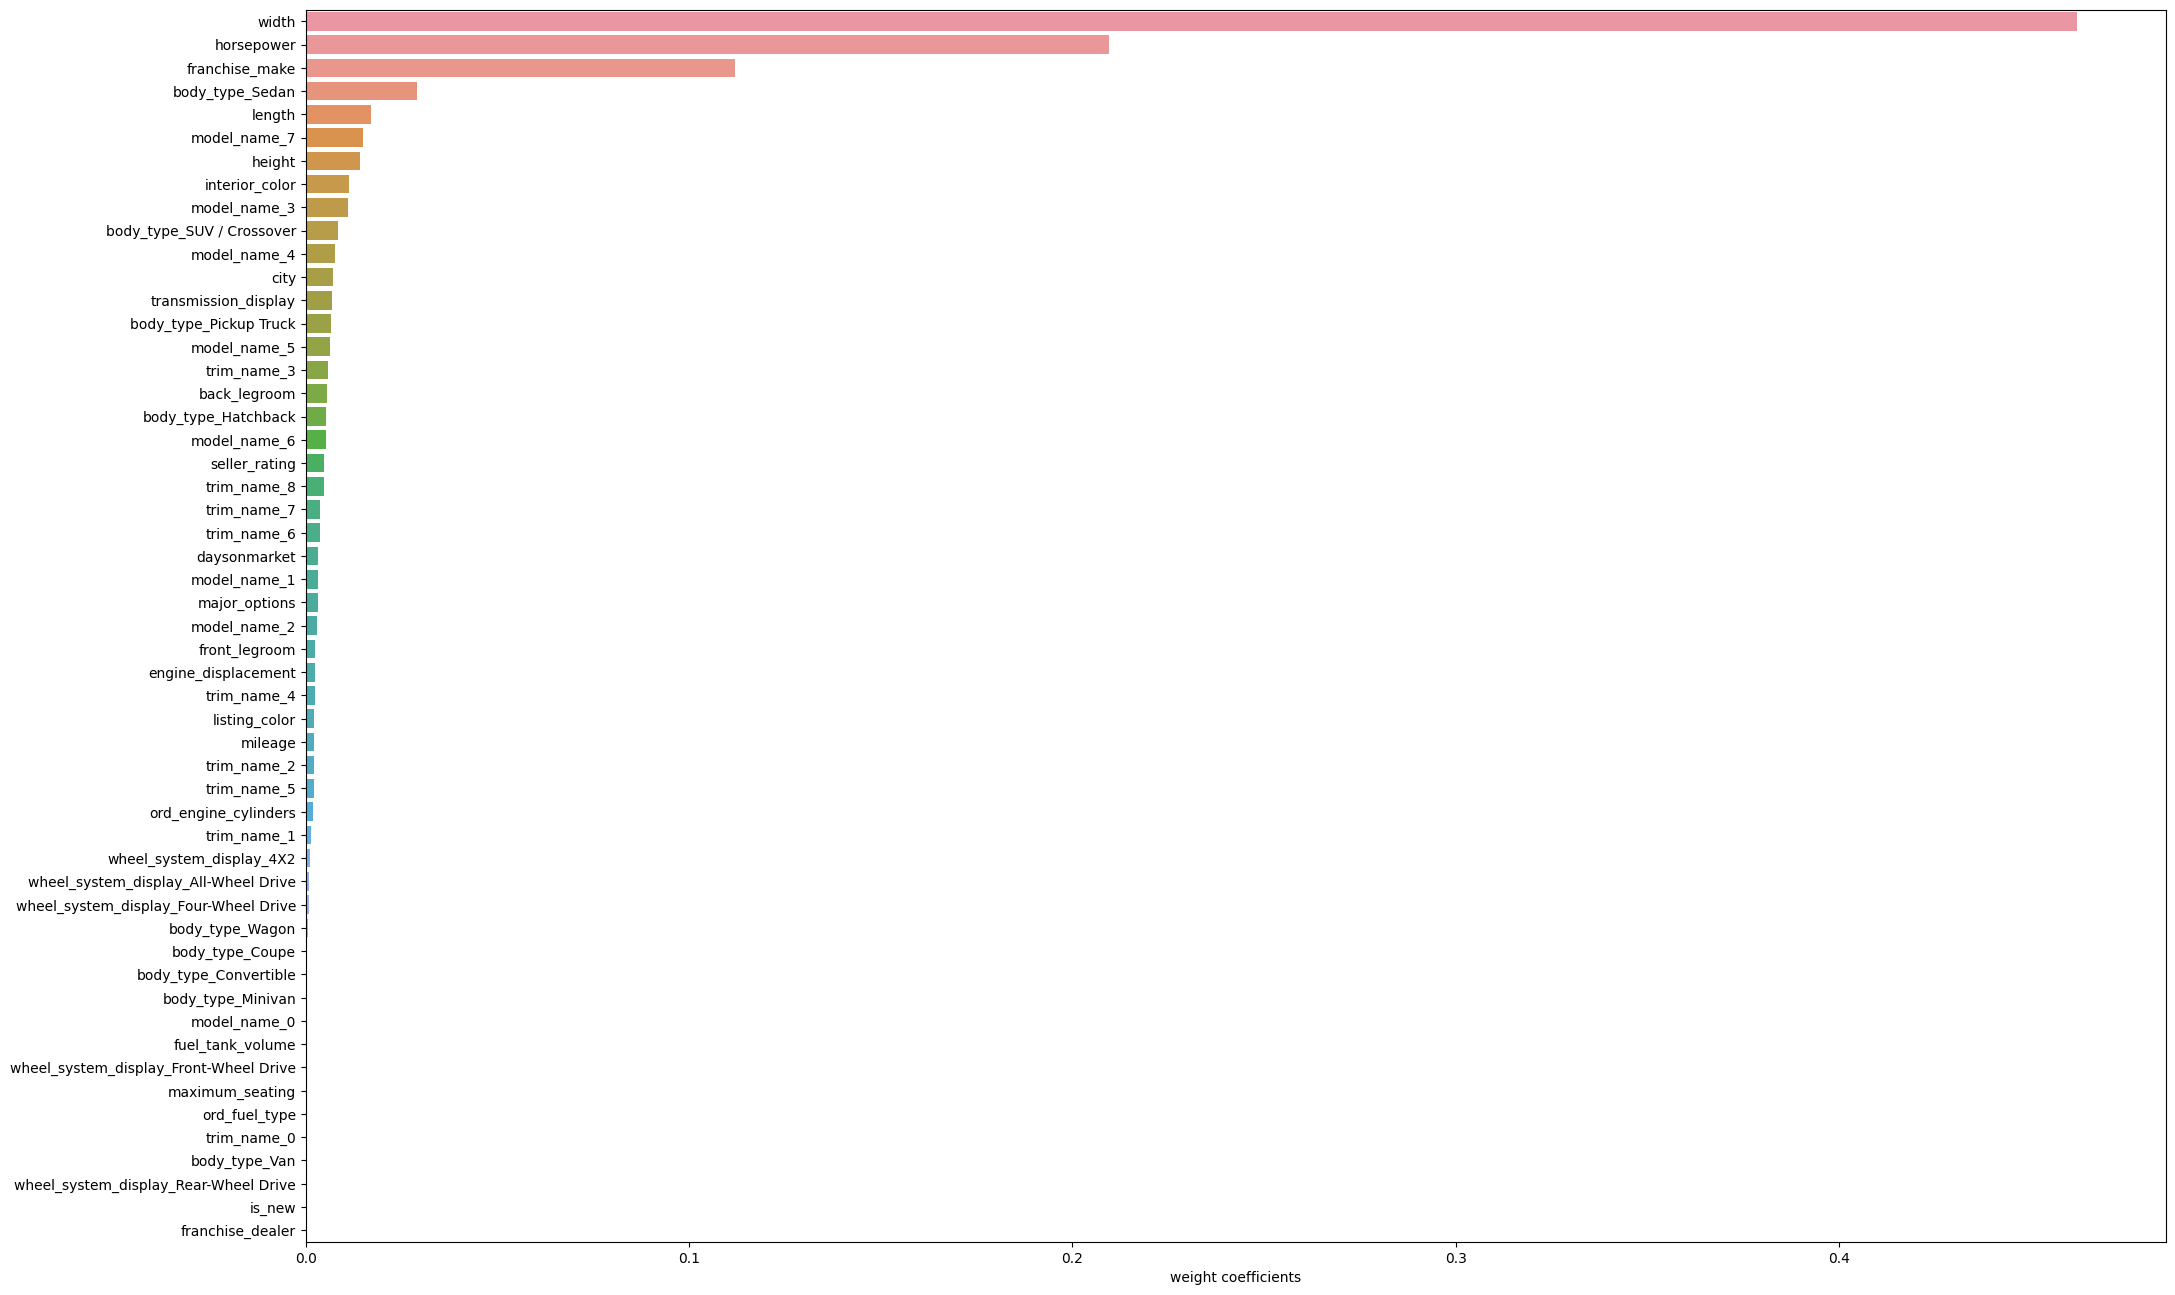

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (24, 16))

feat_imps = zip(feature_names, dtr.feature_importances_)
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

# plt.savefig('default_dtr.png', format = 'png', dpi = 800)

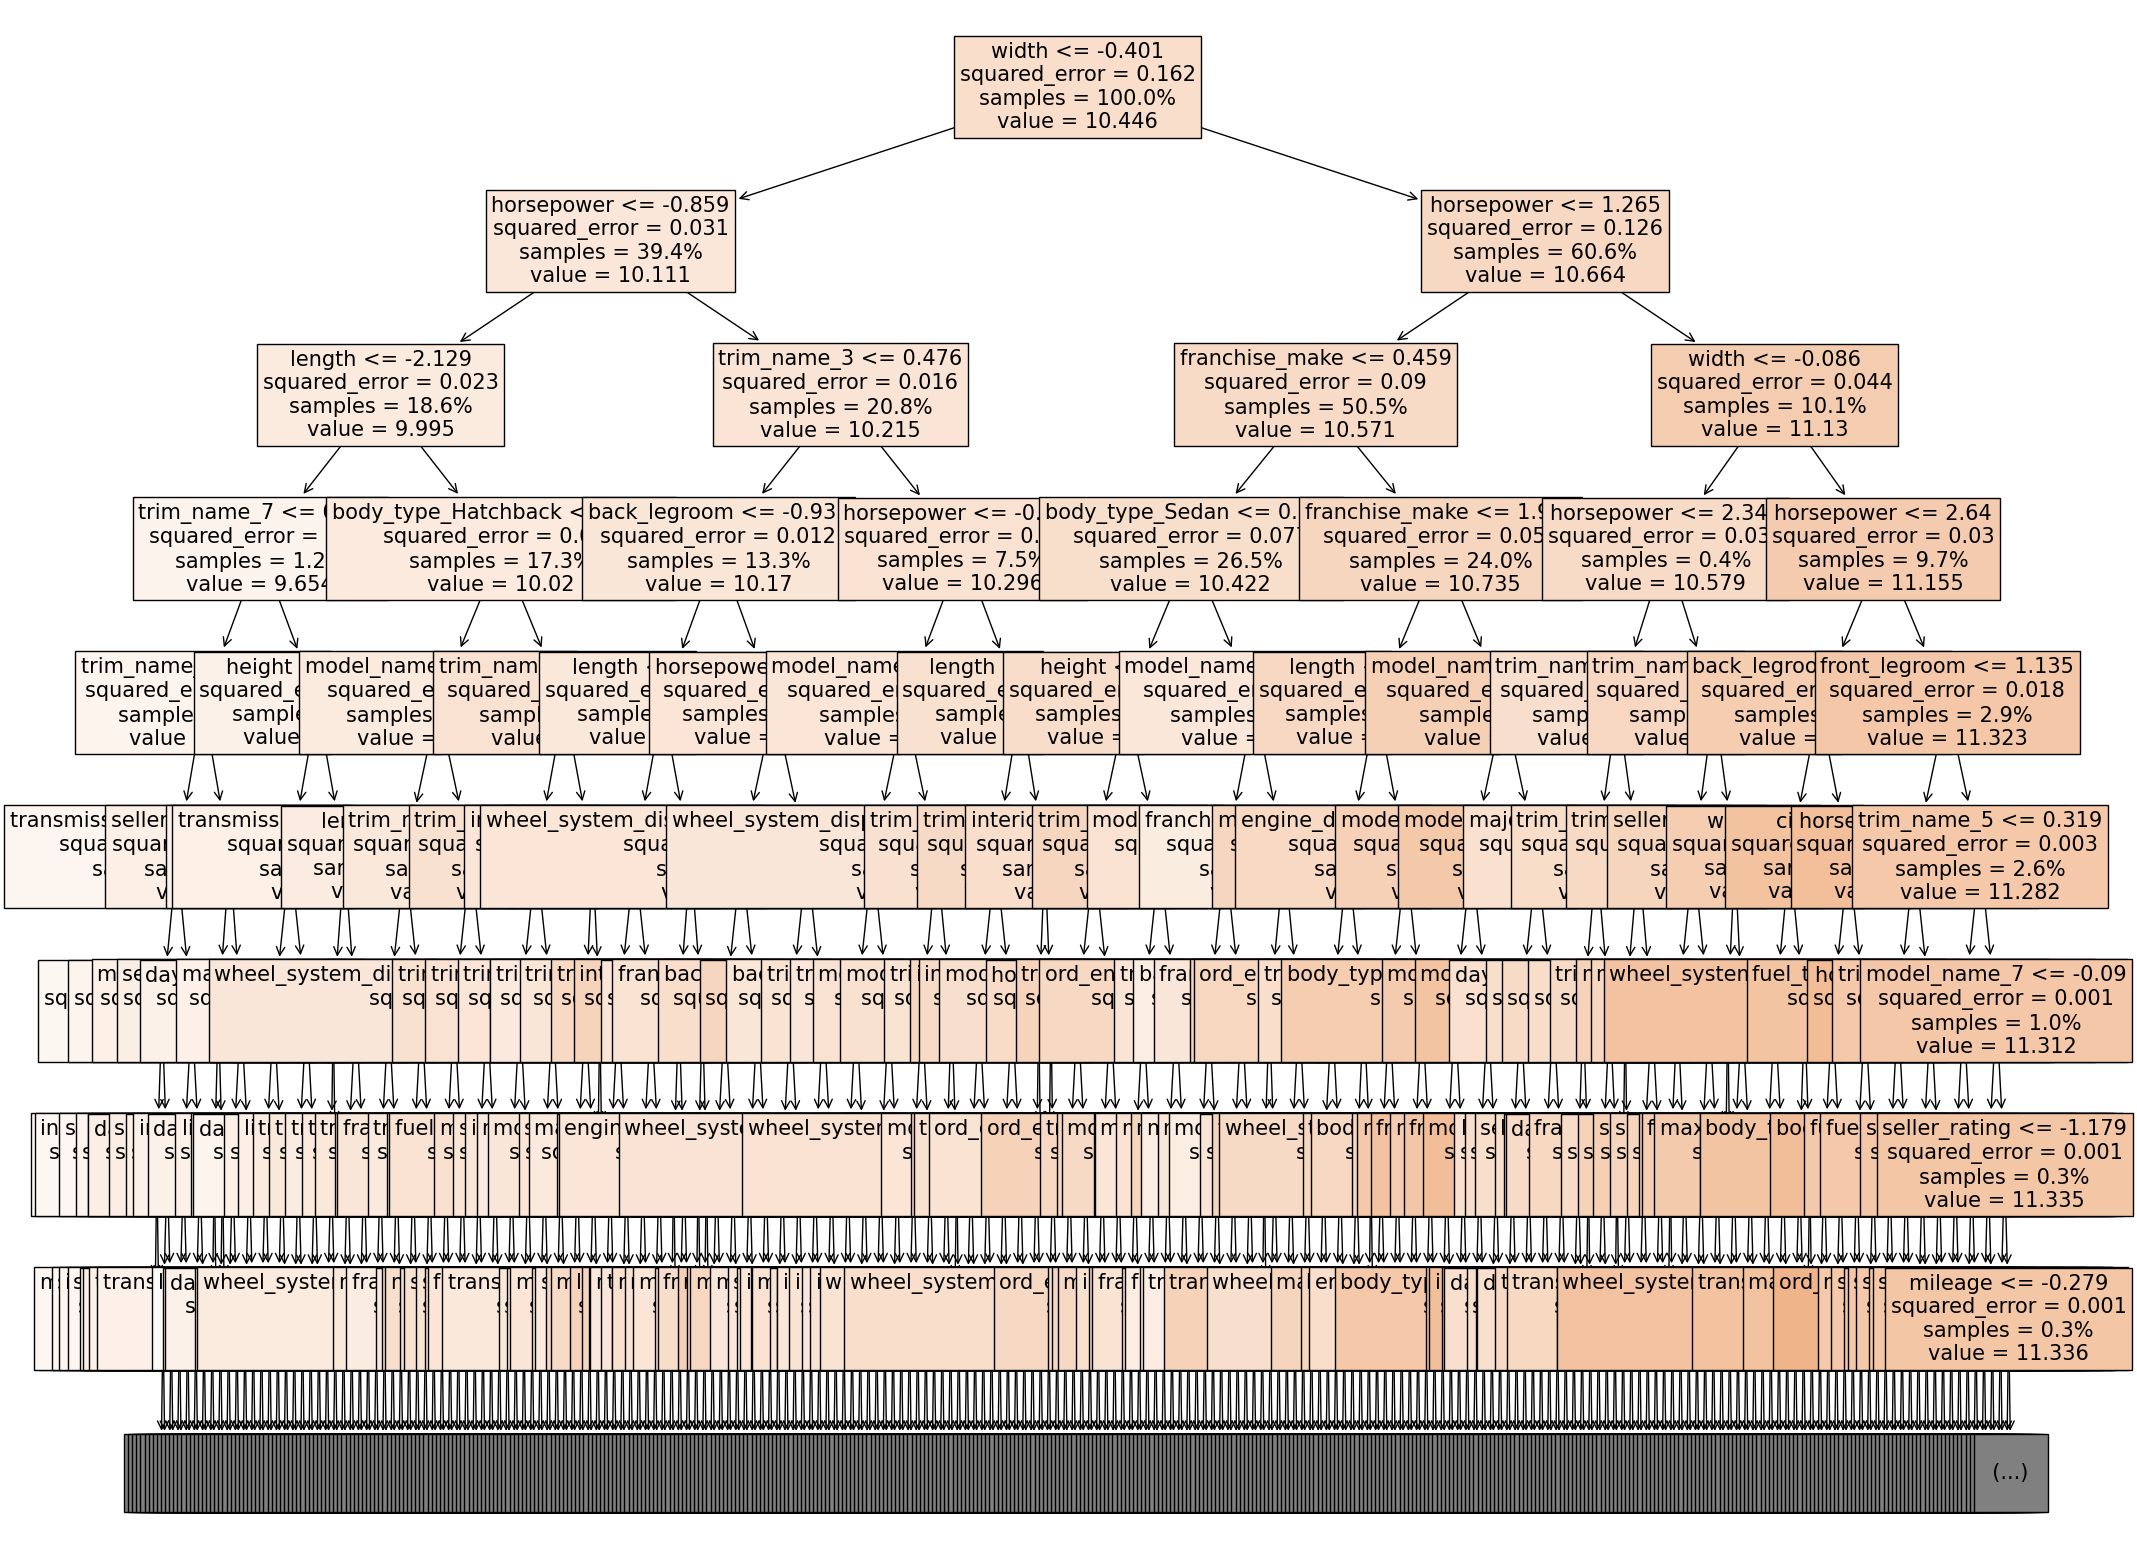

In [ ]:
## YOUR CODE HERE
fig = plt.figure(figsize = (24, 20))
_ = tree.plot_tree(dtr, filled=True, feature_names = feature_names,\
                   proportion = True, max_depth = 8, fontsize = 15)
plt.show()

### 5.4.2 Decision tree with Grid Search

In [ ]:
# tune the hyperparameters
param_grid = {
    "max_depth": [6, 15, 24, 32, 45],
    "max_leaf_nodes" : np.arange(100, 20000, step = 1000),
    "max_features" : np.arange(0, 50, step = 5)
}

best_dtr_regressor = GridSearchCV(estimator = DecisionTreeRegressor(), cv = pds, param_grid = param_grid, 
                   scoring = 'r2', n_jobs = -1)

# Fit with all data
best_dtr_regressor.fit(X_dev_scaled, y_dev)

# Best hyperparameters
print("Best hyperparameters: ", best_dtr_regressor.best_params_)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = best_dtr_regressor.predict(X_dev_scaled)
y_test_pred_log = best_dtr_regressor.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_eln_r2_score = r2_score(y_dev, y_dev_pred_log)
test_eln_r2_score = r2_score(y_test, y_test_pred_log)

dtr_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
dtr_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
dtr_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
dtr_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Decison Tree R2 score on the dev dataset: ", round(dev_eln_r2_score, 4))
print("Decison Tree R2 score on the test dataset: ", round(test_eln_r2_score, 4))

print("Decison Tree RMSE loss on the test dataset: ", round(dtr_rmse_test, 4))
print("Decison Tree MAE loss on the test dataset: ", round(dtr_mae_test, 4))
print("Decison Tree MAPE loss on the test dataset: ", round(dtr_mape_test, 4))
print("Decison Tree RMSLE loss on the test dataset: ", round(dtr_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_dtr_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Decison Tree ranking ability (regression ROC): ", round(test_dtr_roc_score, 4))

Best hyperparameters:  {'max_depth': 45, 'max_features': 35, 'max_leaf_nodes': 2100}
Decison Tree R2 score on the dev dataset:  0.9837
Decison Tree R2 score on the test dataset:  0.9707
Decison Tree RMSE loss on the test dataset:  9332.5945
Decison Tree MAE loss on the test dataset:  1664.6728
Decison Tree MAPE loss on the test dataset:  0.0412
Decison Tree RMSLE loss on the test dataset:  0.0688
Decison Tree ranking ability (regression ROC):  0.9535


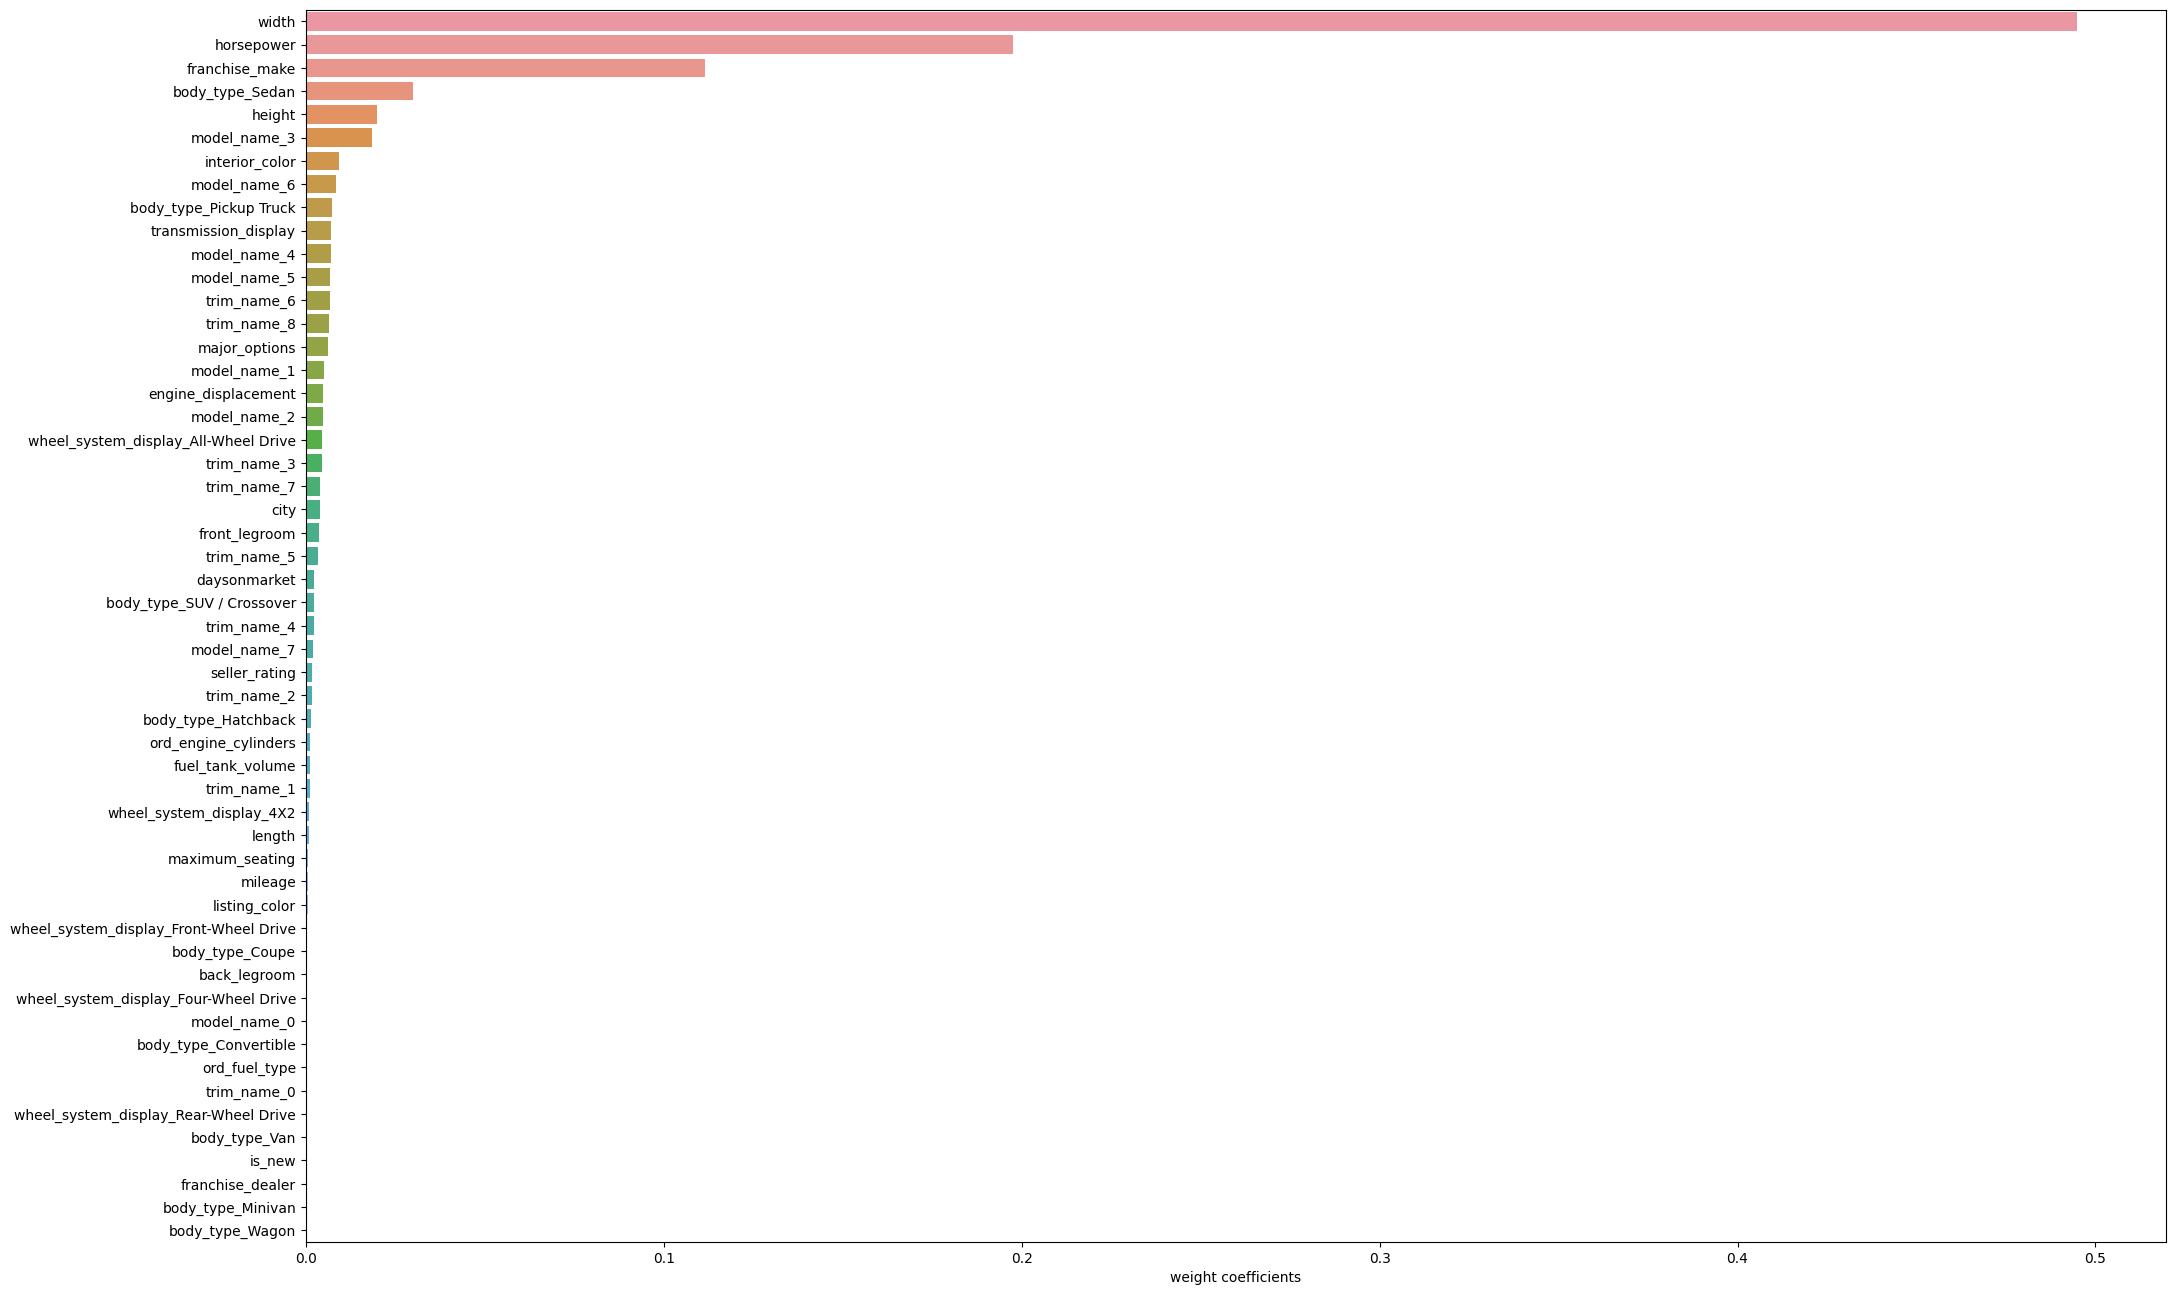

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (24, 16))

feat_imps = zip(feature_names, best_dtr_regressor.best_estimator_.feature_importances_)
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

# plt.savefig('elastic_net_weights.png', format='png', dpi = 800)

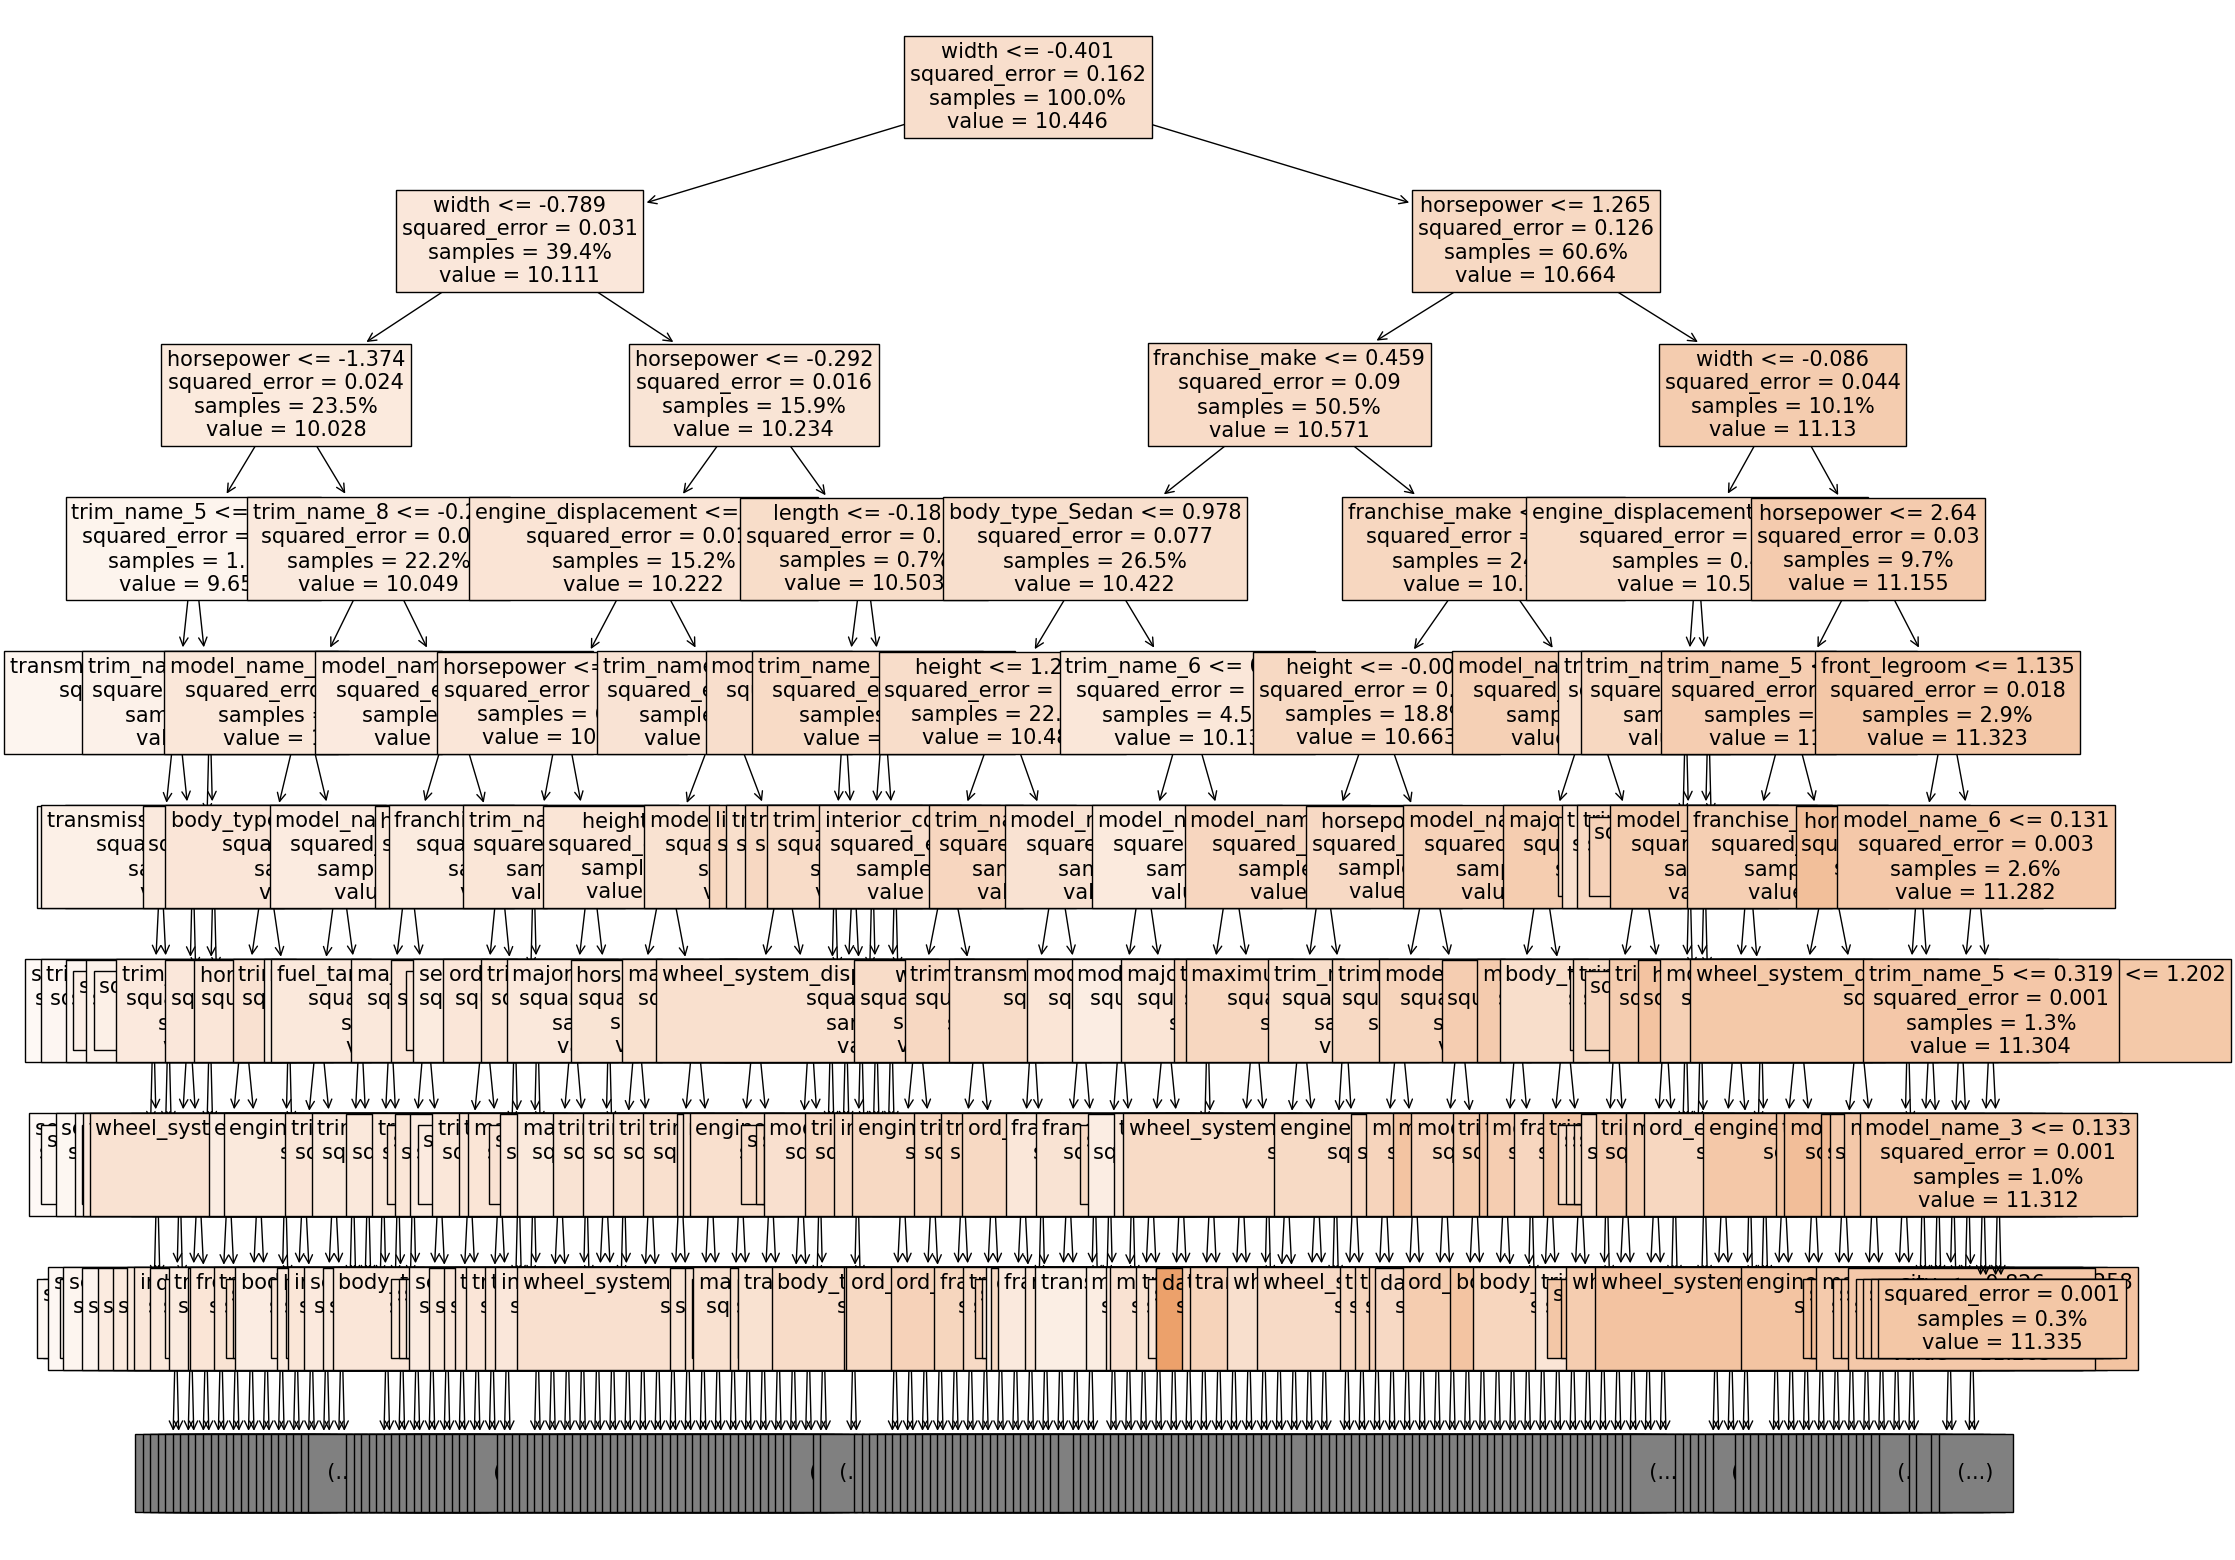

In [ ]:
## YOUR CODE HERE
fig = plt.figure(figsize = (24, 20))
_ = tree.plot_tree(best_dtr_regressor.best_estimator_, filled=True, feature_names = feature_names,\
                   proportion = True, max_depth = 8, fontsize = 15)
plt.show()

## 5.5 & 5.6 Ensemble Methods

### 5.5 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

#Fit random forest with default parameters
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_dev_scaled, y_dev.ravel())

# Compute the R2 score for dev and test datasets
y_dev_pred_log = rf_model.predict(X_dev_scaled)
y_test_pred_log = rf_model.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_rf_r2_score = r2_score(y_dev, y_dev_pred_log)
test_rf_r2_score = r2_score(y_test, y_test_pred_log)

In [ ]:
#compute and print evaluation metrics
rf_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
rf_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
rf_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
rf_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("RF Regression R2 score on the dev dataset: ", round(dev_rf_r2_score, 4))
print("RF Regression R2 score on the test dataset: ", round(test_rf_r2_score, 4))

print("RF Regression RMSE loss on the test dataset: ", round(rf_rmse_test, 4))
print("RF Regression MAE loss on the test dataset: ", round(rf_mae_test, 4))
print("RF Regression MAPE loss on the test dataset: ", round(rf_mape_test, 4))
print("RF Regression RMSLE loss on the test dataset: ", round(rf_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_rf_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("RF Regression ranking ability (regression ROC): ", round(test_rf_roc_score, 4))

RF Regression R2 score on the dev dataset:  0.9969
RF Regression R2 score on the test dataset:  0.9806
RF Regression RMSE loss on the test dataset:  9273.4695
RF Regression MAE loss on the test dataset:  1323.021
RF Regression MAPE loss on the test dataset:  0.0296
RF Regression RMSLE loss on the test dataset:  0.0559
RF Regression ranking ability (regression ROC):  0.9653


#### Hyperparameter tuning

In [ ]:
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
random.seed(42)
# define the hyperparameters and their ranges to search over
hyperparameters = {
    'n_estimators': [50, 100, 250, 500],
    'max_features': [0.5, 0.75, 1.0, 'sqrt', 'log2'],
    'max_depth': [30, 35, 40, 45, None],
}

# initialize the best hyperparameters and their validation score
best_params = None
best_val_score = float('-inf')

# create an empty list to store the hyperparameters and their validation scores
results = []

# perform randomized hyperparameter search
for i in range(5):
    # choose random hyperparameters
    params = {
        'n_estimators': random.choice(hyperparameters['n_estimators']),
        'max_depth': random.choice(hyperparameters['max_depth']),
        'max_features': random.choice(hyperparameters['max_features'])
    }
    
    # create the random forest regressor model with the chosen hyperparameters
    model = RandomForestRegressor(random_state=42, **params)
    
    # fit the model to the training data
    model.fit(X_train_scaled, y_train)
    
    # evaluate the model on the validation set
    y_pred_val = model.predict(X_val_scaled)
    val_score = r2_score(y_val, y_pred_val)
    y_pred_train = model.predict(X_train_scaled)
    train_score = r2_score(y_train, y_pred_train)
    
    # store the hyperparameters and their validation score
    params['train_r2_score'] = train_score
    params['val_r2_score'] = val_score
    results.append(params)

    if val_score > best_val_score:
        best_params = params
        best_val_score = val_score
    
# create a dataframe from the list of results
random_search_results = pd.DataFrame(results)

print(random_search_results)
best_params.pop('train_r2_score')
best_params.pop('val_r2_score')
print('Best hyperparameters:', best_params)
print('Validation R^2 score:', best_val_score)


/var/folders/6l/d525srpn1tl8c1jw2pxxkr3m0000gn/T/ipykernel_6543/2182165135.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled, y_train)
/var/folders/6l/d525srpn1tl8c1jw2pxxkr3m0000gn/T/ipykernel_6543/2182165135.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled, y_train)
/var/folders/6l/d525srpn1tl8c1jw2pxxkr3m0000gn/T/ipykernel_6543/2182165135.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled, y_train)
/var/folders/6l/d525srpn1tl8c1jw2pxxkr3m0000gn/T/ipykernel_6543/2182165135.py:32: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

   n_estimators  max_depth  max_features  train_r2_score  val_r2_score
0            50       30.0          1.00        0.996973      0.981353
1           100       35.0          0.75        0.997195      0.982127
2            50        NaN          0.50        0.997117      0.982077
3           500       30.0          0.50        0.997208      0.982403
4            50       35.0          0.75        0.997124      0.982071
Best hyperparameters: {'n_estimators': 500, 'max_depth': 30, 'max_features': 0.5}
Validation R^2 score: 0.9824029272252616


In [ ]:
random_search_results.sort_values(by='val_r2_score', ascending=False)

n_estimators  max_depth  max_features  train_r2_score  val_r2_score
3           500       30.0          0.50        0.997208      0.982403
1           100       35.0          0.75        0.997195      0.982127
2            50        NaN          0.50        0.997117      0.982077
4            50       35.0          0.75        0.997124      0.982071
0            50       30.0          1.00        0.996973      0.981353

In [ ]:
pd.DataFrame.from_dict(best_params, orient='index', columns=['Best Hyperparameters'])

Best Hyperparameters
n_estimators                 500.0
max_depth                     30.0
max_features                   0.5

In [ ]:
# best_rf_model = RandomForestRegressor(random_state=42, **best_params)
best_rf_model = RandomForestRegressor(random_state=42, n_estimators=500, max_features=0.5, max_depth=30)
best_rf_model.fit(X_dev_scaled, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = best_rf_model.predict(X_dev_scaled)
y_test_pred_log = best_rf_model.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_best_rf_r2_score = r2_score(y_dev, y_dev_pred_log)
test_best_rf_r2_score = r2_score(y_test, y_test_pred_log)

best_rf_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
best_rf_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
best_rf_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
best_rf_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

# print("best_rf Regression R2 score on the dev dataset: ", round(dev_best_rf_r2_score, 4))
print("best_rf Regression R2 score on the test dataset: ", round(test_best_rf_r2_score, 4))
print("best_rf Regression RMSE loss on the test dataset: ", round(best_rf_rmse_test, 4))
print("best_rf Regression MAE loss on the test dataset: ", round(best_rf_mae_test, 4))
print("best_rf Regression MAPE loss on the test dataset: ", round(best_rf_mape_test, 4))
print("best_rf Regression RMSLE loss on the test dataset: ", round(best_rf_rmsle_test, 4))

/var/folders/6l/d525srpn1tl8c1jw2pxxkr3m0000gn/T/ipykernel_7587/1055216638.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_rf_model.fit(X_dev_scaled, y_dev)


best_rf Regression R2 score on the test dataset:  0.9816
best_rf Regression RMSE loss on the test dataset:  9521.1668
best_rf Regression MAE loss on the test dataset:  1305.8864
best_rf Regression MAPE loss on the test dataset:  0.0293
best_rf Regression RMSLE loss on the test dataset:  0.0545


In [ ]:
test_rf_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("RF Regression ranking ability (regression ROC): ", round(test_rf_roc_score, 4))

RF Regression ranking ability (regression ROC):  0.9659


Text(0, 0.5, 'Feature Importance')

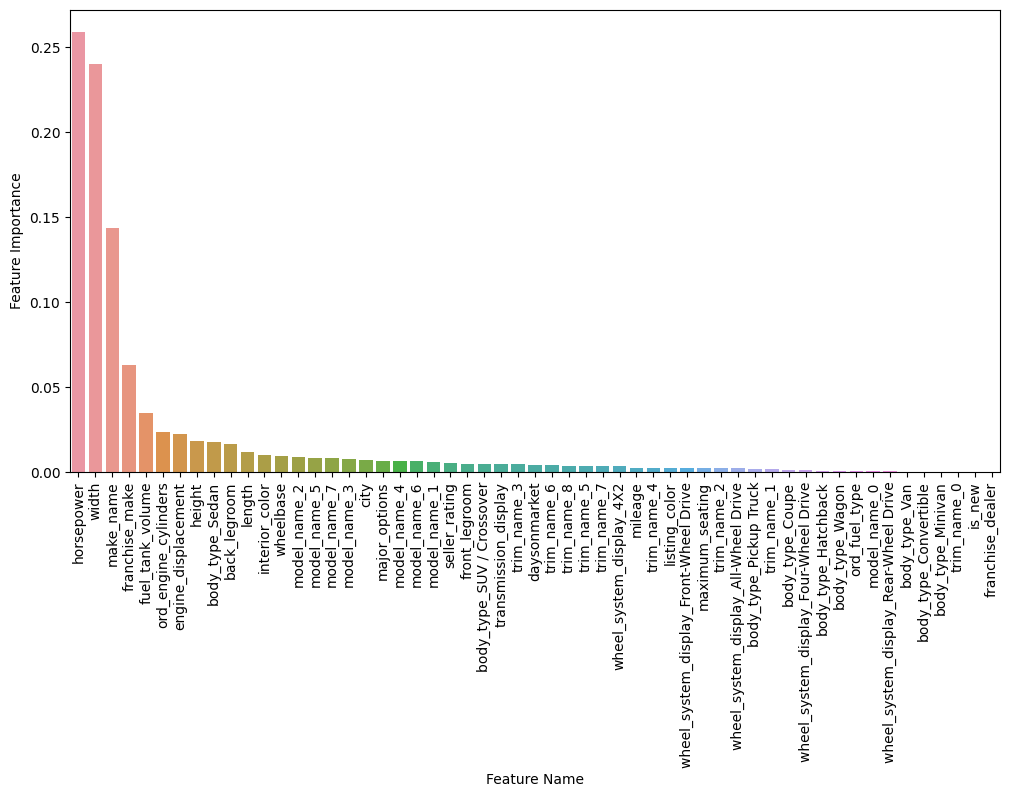

In [ ]:
plt.figure(figsize=(12, 6))
feature_names = X_dev.columns.tolist()
feat_imps = zip(feature_names, best_rf_model.feature_importances_)
feats, imps = zip(*(sorted(list(filter(lambda x: x[1] != 0, feat_imps)), key=lambda x: x[1], reverse=True)))
ax = sns.barplot(x= list(feats), y=list(imps))
ax.tick_params(axis='x', rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Feature Importance")

* best_rf Regression R2 score on the test dataset:  0.9814
* best_rf Regression RMSE loss on the test dataset:  97.7504
* best_rf Regression MAE loss on the test dataset:  1307.1058
* best_rf Regression MAPE loss on the test dataset:  0.0293
* best_rf Regression RMSLE loss on the test dataset:  0.0549

### 5.6.1 Adaboost Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

# default adaboost
abr = AdaBoostRegressor(random_state = 42)
abr.fit(X_dev_scaled, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = abr.predict(X_dev_scaled)
y_test_pred_log = abr.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_abr_r2_score = r2_score(y_dev, y_dev_pred_log)
test_abr_r2_score = r2_score(y_test, y_test_pred_log)

abr_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
abr_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
abr_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
abr_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Adaboost Regression R2 score on the dev dataset: ", round(dev_abr_r2_score, 4))
print("Adaboost Regression R2 score on the test dataset: ", round(test_abr_r2_score, 4))

print("Adaboost Regression RMSE loss on the test dataset: ", round(abr_rmse_test, 4))
print("Adaboost Regression MAE loss on the test dataset: ", round(abr_mae_test, 4))
print("Adaboost Regression MAPE loss on the test dataset: ", round(abr_mape_test, 4))
print("Adaboost Regression RMSLE loss on the test dataset: ", round(abr_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_abr_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Adaboost Regression ranking ability (regression ROC): ", round(test_abr_roc_score, 4))

Adaboost Regression R2 score on the dev dataset:  0.7015
Adaboost Regression R2 score on the test dataset:  0.6952
Adaboost Regression RMSE loss on the test dataset:  14144.588
Adaboost Regression MAE loss on the test dataset:  6601.133
Adaboost Regression MAPE loss on the test dataset:  0.1811
Adaboost Regression RMSLE loss on the test dataset:  0.2219
Adaboost Regression ranking ability (regression ROC):  0.8316


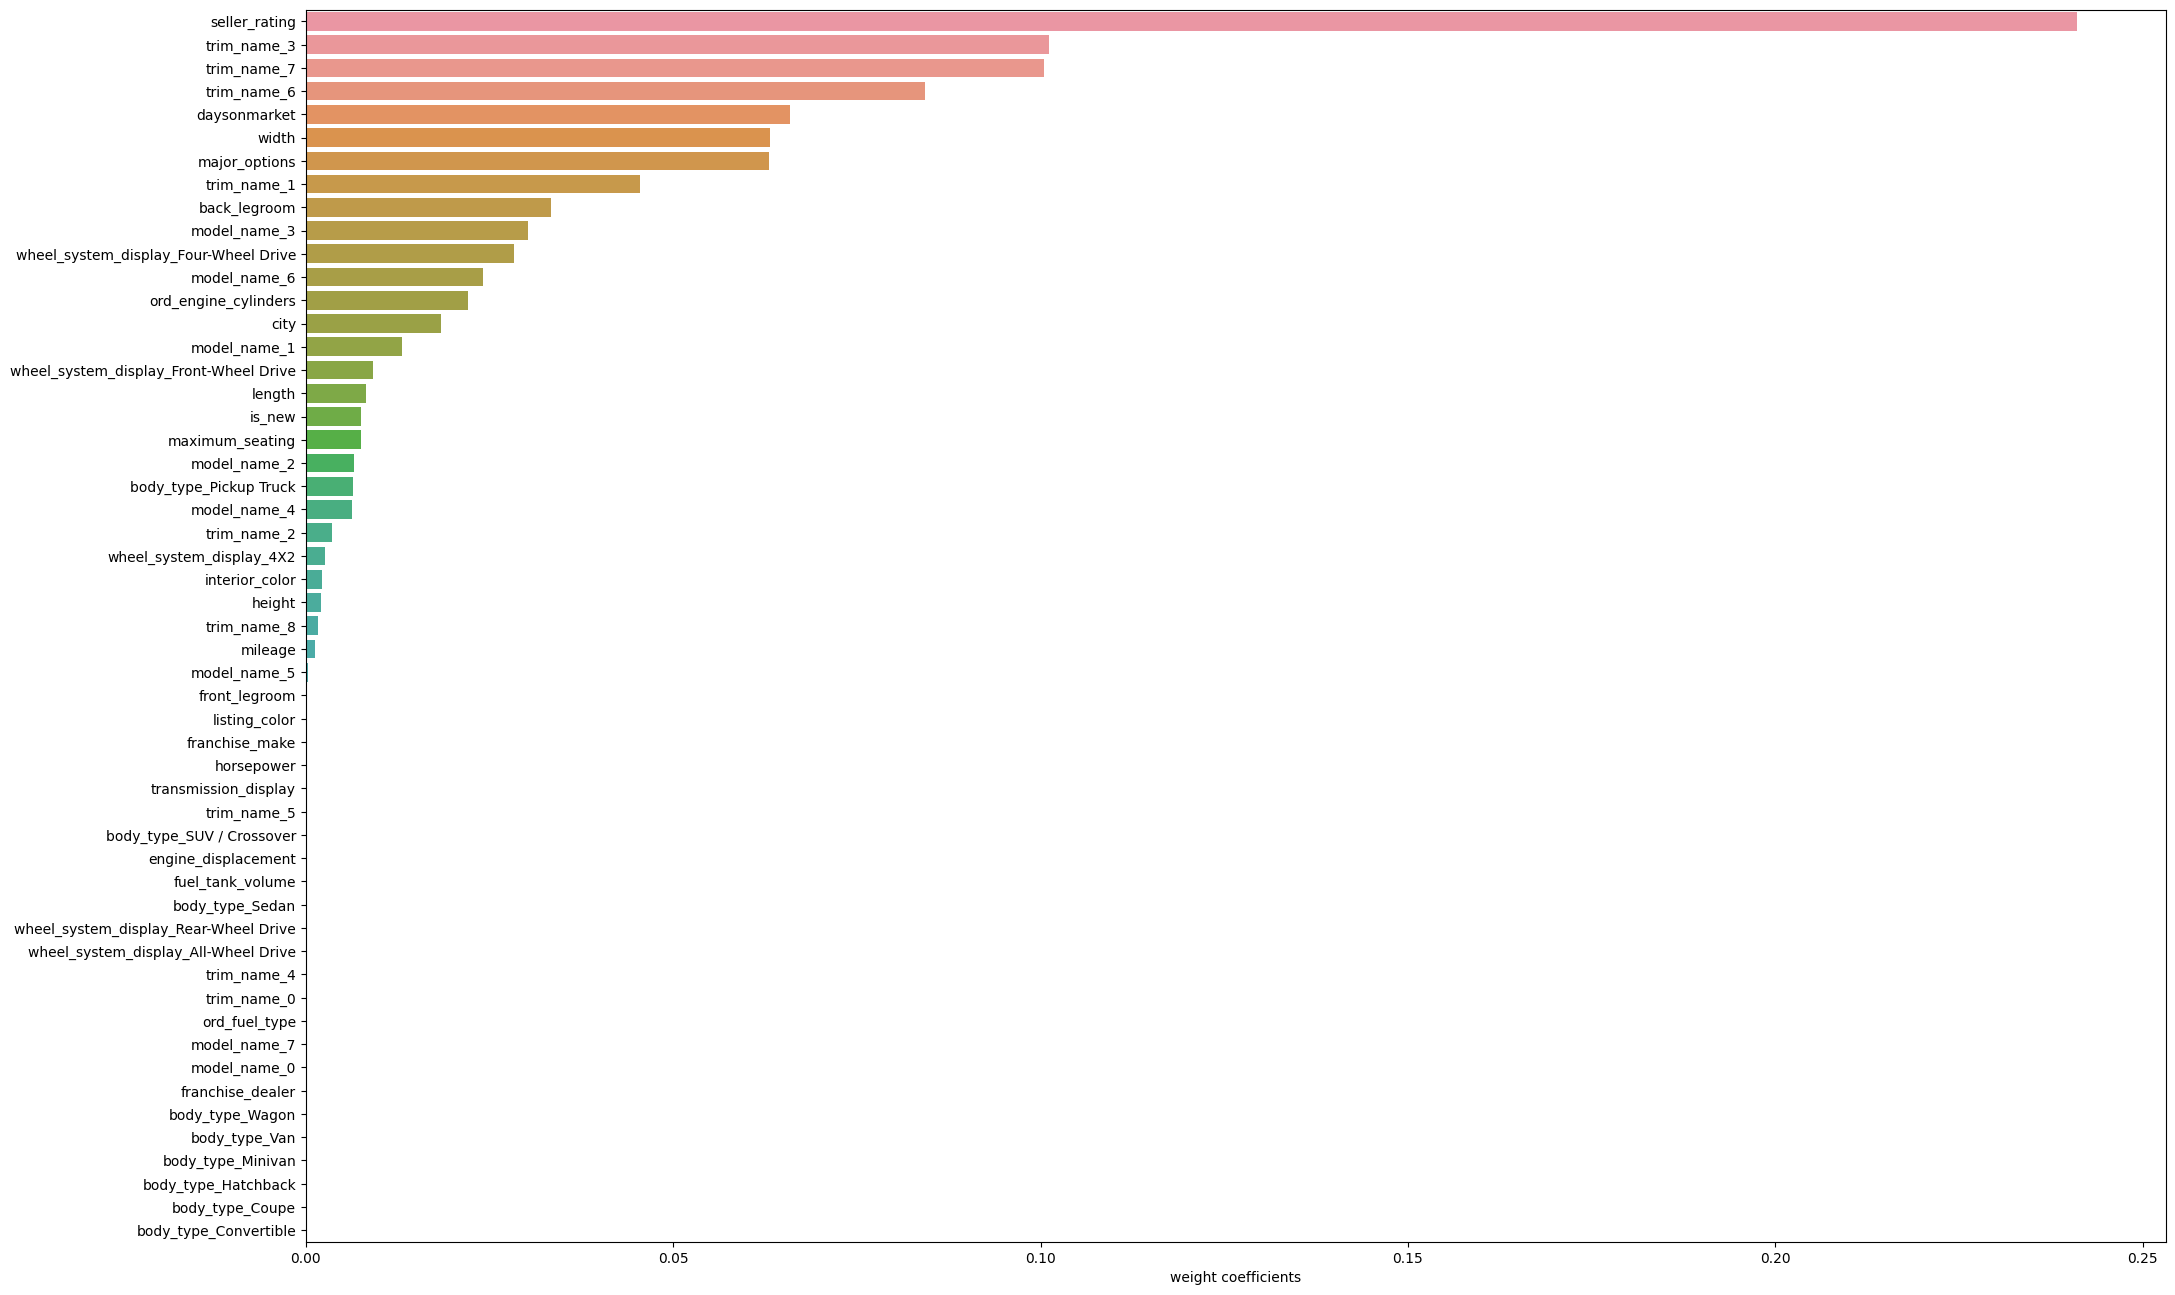

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (24, 16))

feat_imps = zip(feature_names, abr.feature_importances_)
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

#### Hyperparameter tuning using grid search

In [ ]:
param_grid = {
    "n_estimators" : [50,100,150],
    "learning_rate" : [0.0001, 0.01, 1],
    "loss" : ['linear', 'square', 'exponential']
}

best_abr_regressor = GridSearchCV(estimator = AdaBoostRegressor(), cv = pds, param_grid = param_grid, 
                   scoring = 'r2', n_jobs = -1)

# Fit with all data
best_abr_regressor.fit(X_dev_scaled, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = best_abr_regressor.predict(X_dev_scaled)
y_test_pred_log = best_abr_regressor.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_abr_r2_score = r2_score(y_dev, y_dev_pred_log)
test_abr_r2_score = r2_score(y_test, y_test_pred_log)

abr_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
abr_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
abr_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
abr_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Adaboost Regression R2 score on the dev dataset: ", round(dev_abr_r2_score, 4))
print("Adaboost Regression R2 score on the test dataset: ", round(test_abr_r2_score, 4))

print("Adaboost Regression RMSE loss on the test dataset: ", round(abr_rmse_test, 4))
print("Adaboost Regression MAE loss on the test dataset: ", round(abr_mae_test, 4))
print("Adaboost Regression MAPE loss on the test dataset: ", round(abr_mape_test, 4))
print("Adaboost Regression RMSLE loss on the test dataset: ", round(abr_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_abr_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Adaboost Regression ranking ability (regression ROC): ", round(test_abr_roc_score, 4))

Adaboost Regression R2 score on the dev dataset:  0.7439
Adaboost Regression R2 score on the test dataset:  0.7361
Adaboost Regression RMSE loss on the test dataset:  15300.2986
Adaboost Regression MAE loss on the test dataset:  6021.9322
Adaboost Regression MAPE loss on the test dataset:  0.1495
Adaboost Regression RMSLE loss on the test dataset:  0.2065
Adaboost Regression ranking ability (regression ROC):  0.8294


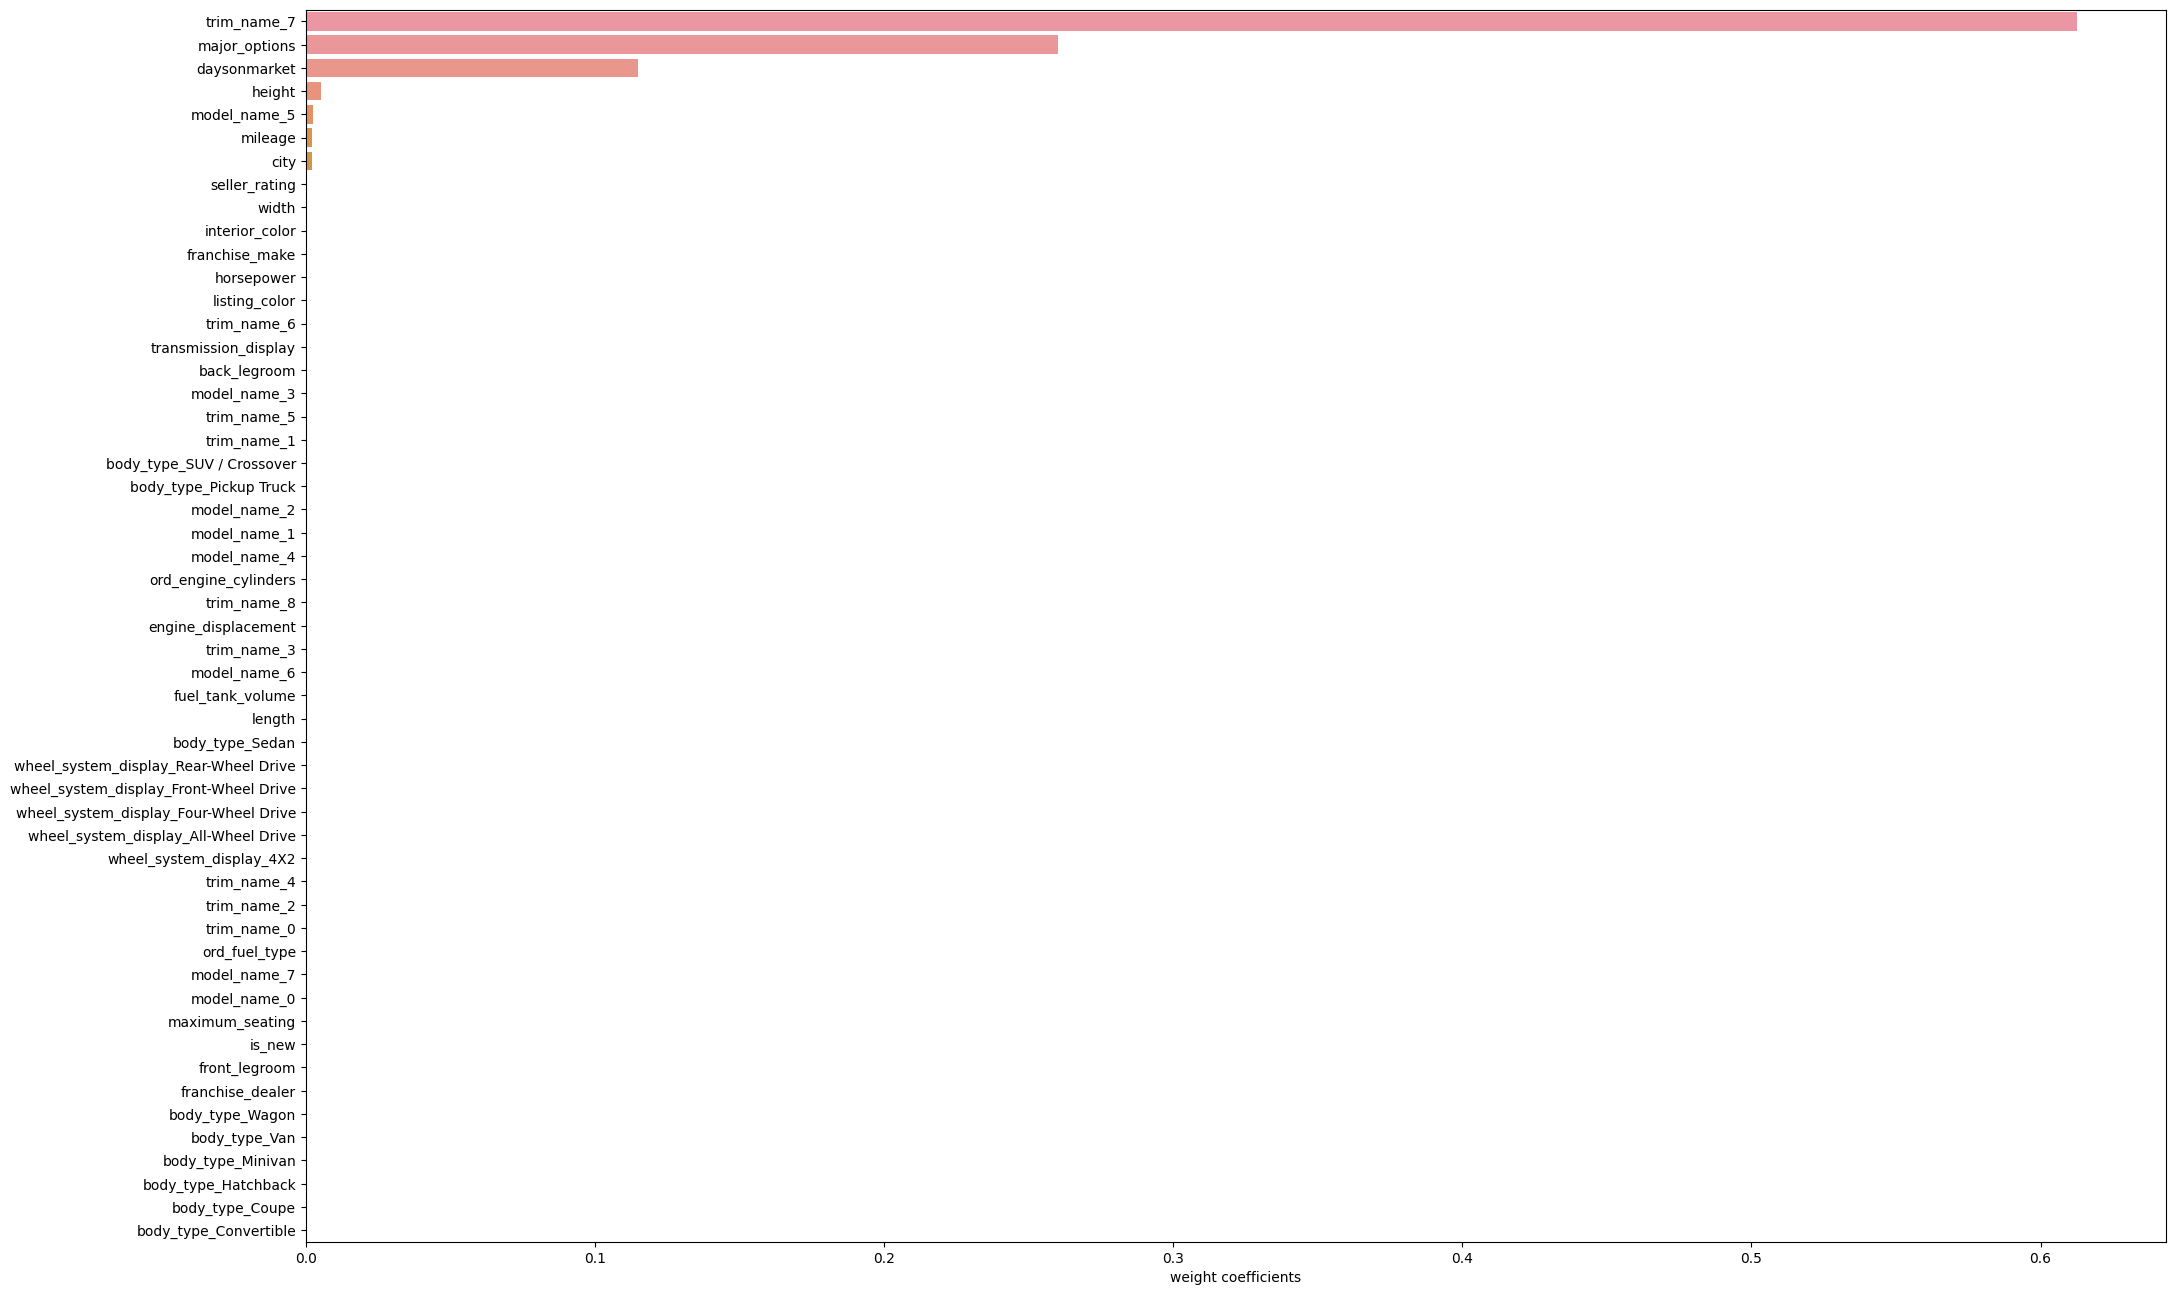

In [ ]:
# plot the weight coefficients of each feature
plt.figure(figsize = (24, 16))

feat_imps = zip(feature_names, best_abr_regressor.best_estimator_.feature_importances_)
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

### 5.6.2 XGBoost

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline

In [ ]:
estimator = XGBRegressor(random_state=42)
estimator.fit(X_dev_scaled, y_dev)

y_dev_pred_log = estimator.predict(X_dev_scaled)
y_test_pred_log = estimator.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

xgb_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
xgb_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
xgb_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
xgb_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

dev_xgb_r2_score = r2_score(y_dev, y_dev_pred_log)
test_xgb_r2_score = r2_score(y_test, y_test_pred_log)

print("XGB Regression R2 score on the dev dataset: ", round(dev_xgb_r2_score, 4))
print("XGB Regression R2 score on the test dataset: ", round(test_xgb_r2_score, 4))

print("XGB Regression RMSE loss on the test dataset: ", round(xgb_rmse_test, 4))
print("XGB Regression MAE loss on the test dataset: ", round(xgb_mae_test, 4))
print("XGB Regression MAPE loss on the test dataset: ", round(xgb_mape_test, 4))
print("XGB Regression RMSLE loss on the test dataset: ", round(xgb_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_xgb_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("XGB Regression ranking ability (regression ROC): ", round(test_xgb_roc_score, 4))

XGB Regression R2 score on the dev dataset:  0.977
XGB Regression R2 score on the test dataset:  0.9706
XGB Regression RMSE loss on the test dataset:  10046.2625
XGB Regression MAE loss on the test dataset:  1842.5663
XGB Regression MAPE loss on the test dataset:  0.0442
XGB Regression RMSLE loss on the test dataset:  0.0689
XGB Regression ranking ability (regression ROC):  0.9503


- Accuracy of the XGBoost model is: 0.9706
- Root Mean squared errors of the XGBoost: 10046.2625
- Mean absolute errors of the XGBoost: 1842.5663

#### Feature importance

In [ ]:
feature_names = list(X_dev.columns)
print(f"Feature names: {feature_names}")
importances = best_xgb_regressor.feature_importances_

feature_importances = pd.Series(importances, index=feature_names)

zipped_lists = zip(importances, feature_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
importances, feature_names = [ list(tuple) for tuple in  tuples]

importances = importances[::-1]
feature_names = feature_names[::-1]

Feature names: ['back_legroom', 'city', 'daysonmarket', 'engine_displacement', 'franchise_dealer', 'franchise_make', 'front_legroom', 'fuel_tank_volume', 'height', 'horsepower', 'interior_color', 'is_new', 'length', 'listing_color', 'major_options', 'maximum_seating', 'mileage', 'model_name_0', 'model_name_1', 'model_name_2', 'model_name_3', 'model_name_4', 'model_name_5', 'model_name_6', 'model_name_7', 'seller_rating', 'transmission_display', 'trim_name_0', 'trim_name_1', 'trim_name_2', 'trim_name_3', 'trim_name_4', 'trim_name_5', 'trim_name_6', 'trim_name_7', 'trim_name_8', 'width', 'ord_fuel_type', 'ord_engine_cylinders', 'body_type_Convertible', 'body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon', 'wheel_system_display_4X2', 'wheel_system_display_All-Wheel Drive', 'wheel_system_display_Four-Wheel Drive', 'wheel_system_display_Front-Wheel Drive', 'wheel_system_dis

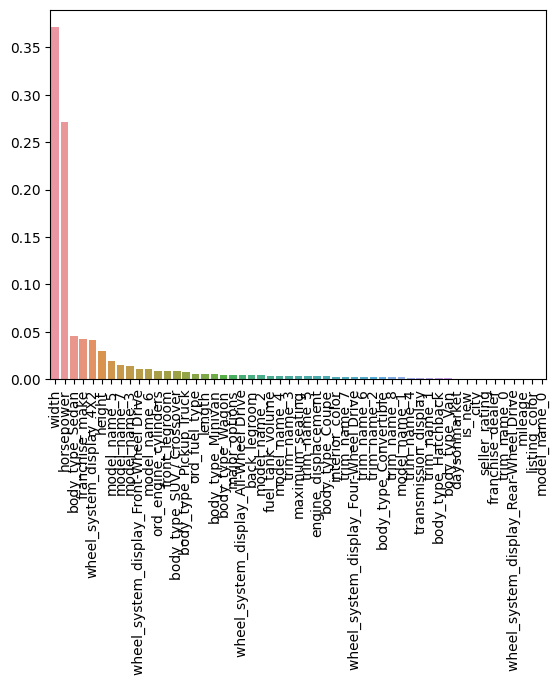

In [ ]:
ax = sns.barplot(x=feature_names, y=importances)
ax.tick_params(axis='x', rotation=90)

#### Hyperparameter tuning for XGBoost

In [ ]:
param_grid = {
    "learning_rate" : [0.3, 0.01, 0.1],
    "max_depth" : [3, 6, 9],
    "min_child_weight" : [1.0, 3, 6]
}

best_xgb_regressor = GridSearchCV(estimator = XGBRegressor(), cv = pds, param_grid = param_grid, 
                   scoring = 'r2', n_jobs = -1)

best_xgb_regressor.fit(X_dev_scaled, y_dev)

# Best hyperparameters
print("Best hyperparameters: ", best_xgb_regressor.best_params_)

y_dev_pred_log = best_xgb_regressor.predict(X_dev_scaled)
y_test_pred_log = best_xgb_regressor.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

xgb_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
xgb_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
xgb_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
xgb_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

dev_xgb_r2_score = r2_score(y_dev, y_dev_pred_log)
test_xgb_r2_score = r2_score(y_test, y_test_pred_log)

print("XGB Regression R2 score on the dev dataset: ", round(dev_xgb_r2_score, 4))
print("XGB Regression R2 score on the test dataset: ", round(test_xgb_r2_score, 4))

print("XGB Regression RMSE loss on the test dataset: ", round(xgb_rmse_test, 4))
print("XGB Regression MAE loss on the test dataset: ", round(xgb_mae_test, 4))
print("XGB Regression MAPE loss on the test dataset: ", round(xgb_mape_test, 4))
print("XGB Regression RMSLE loss on the test dataset: ", round(xgb_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_xgb_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("XGB Regression ranking ability (regression ROC): ", round(test_xgb_roc_score, 4))

Best hyperparameters:  {'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1.0}
XGB Regression R2 score on the dev dataset:  0.9889
XGB Regression R2 score on the test dataset:  0.9779
XGB Regression RMSE loss on the test dataset:  9042.074
XGB Regression MAE loss on the test dataset:  1483.3672
XGB Regression MAPE loss on the test dataset:  0.0345
XGB Regression RMSLE loss on the test dataset:  0.0597
XGB Regression ranking ability (regression ROC):  0.9611


#### Feature importance with the best hyperparameters


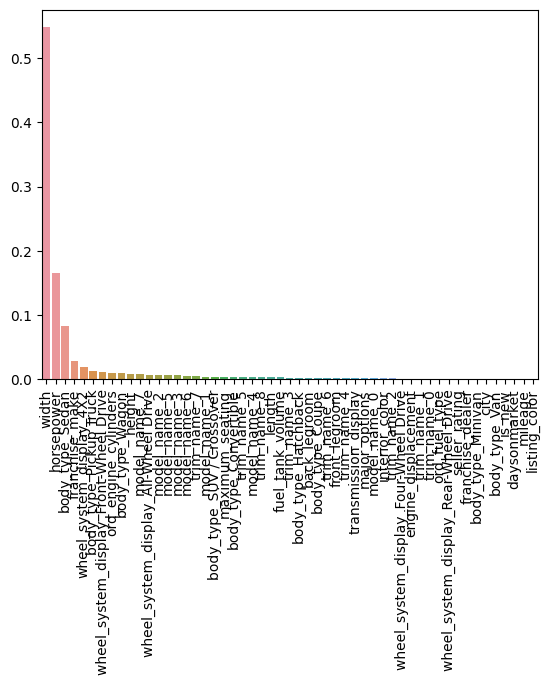

In [ ]:
# feature_names = list(X_dev.columns)
# print(f"Feature names: {feature_names}")
importances = best_xgb_regressor.best_estimator_.feature_importances_

feature_importances = pd.Series(importances, index=feature_names)

zipped_lists = zip(importances, feature_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
importances, feature_names = [ list(tuple) for tuple in  tuples]

importances = importances[::-1]
feature_names = feature_names[::-1]

ax = sns.barplot(x=feature_names, y=importances)
ax.tick_params(axis='x', rotation=90)

### 5.6.3 Hist Gradient Boost

In [ ]:
hist_grad = HistGradientBoostingRegressor(random_state = 42)
hist_grad.fit(X_dev_scaled, y_dev.ravel())

y_dev_pred_log = hist_grad.predict(X_dev_scaled)
y_test_pred_log = hist_grad.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

hgb_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
hgb_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
hgb_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
hgb_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

dev_hgb_r2_score = r2_score(y_dev, y_dev_pred_log)
test_hgb_r2_score = r2_score(y_test, y_test_pred_log)

print("HGB Regression R2 score on the dev dataset: ", round(dev_hgb_r2_score, 4))
print("HGB Regression R2 score on the test dataset: ", round(test_hgb_r2_score, 4))

print("HGB Regression RMSE loss on the test dataset: ", round(hgb_rmse_test, 4))
print("HGB Regression MAE loss on the test dataset: ", round(hgb_mae_test, 4))
print("HGB Regression MAPE loss on the test dataset: ", round(hgb_mape_test, 4))
print("HGB Regression RMSLE loss on the test dataset: ", round(hgb_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_hgb_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("HGB Regression ranking ability (regression ROC): ", round(test_hgb_roc_score, 4))

HGB Regression R2 score on the dev dataset:  0.967
HGB Regression R2 score on the test dataset:  0.96
HGB Regression RMSE loss on the test dataset:  11968.1903
HGB Regression MAE loss on the test dataset:  2122.7495
HGB Regression MAPE loss on the test dataset:  0.0513
HGB Regression RMSLE loss on the test dataset:  0.0803
HGB Regression ranking ability (regression ROC):  0.9423


#### Hyperparameter tuning

In [ ]:
param_grid = {
    "max_iter" : [50, 100, 150],
    "learning_rate" : [0.001, 0.01, 1],
    "loss" : ['absolute_error', 'squared_error', 'poisson']
}

best_hgb_regressor = GridSearchCV(estimator = HistGradientBoostingRegressor(), cv = pds, param_grid = param_grid, 
                   scoring = 'r2', n_jobs = -1)

best_hgb_regressor.fit(X_dev_scaled, y_dev.ravel())

y_dev_pred_log = best_hgb_regressor.predict(X_dev_scaled)
y_test_pred_log = best_hgb_regressor.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

hgb_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
hgb_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
hgb_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
hgb_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

dev_hgb_r2_score = r2_score(y_dev, y_dev_pred_log)
test_hgb_r2_score = r2_score(y_test, y_test_pred_log)

print("HGB Regression R2 score on the dev dataset: ", round(dev_hgb_r2_score, 4))
print("HGB Regression R2 score on the test dataset: ", round(test_hgb_r2_score, 4))

print("HGB Regression RMSE loss on the test dataset: ", round(hgb_rmse_test, 4))
print("HGB Regression MAE loss on the test dataset: ", round(hgb_mae_test, 4))
print("HGB Regression MAPE loss on the test dataset: ", round(hgb_mape_test, 4))
print("HGB Regression RMSLE loss on the test dataset: ", round(hgb_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_hgb_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("HGB Regression ranking ability (regression ROC): ", round(test_hgb_roc_score, 4))

HGB Regression R2 score on the dev dataset:  0.9812
HGB Regression R2 score on the test dataset:  0.9725
HGB Regression RMSE loss on the test dataset:  8447.4983
HGB Regression MAE loss on the test dataset:  1755.3013
HGB Regression MAPE loss on the test dataset:  0.0418
HGB Regression RMSLE loss on the test dataset:  0.0666
HGB Regression ranking ability (regression ROC):  0.9526


### 5.6.4 LightGBM

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_dev_scaled, y_dev)


y_dev_pred_log = lgbm.predict(X_dev_scaled)
y_test_pred_log = lgbm.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)


lgbm_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
lgbm_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
lgbm_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
lgbm_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

dev_lgbm_r2_score = r2_score(y_dev, y_dev_pred_log)
test_lgbm_r2_score = r2_score(y_test, y_test_pred_log)

print("LGBMRegressor R2 score on the dev dataset: ", round(dev_lgbm_r2_score, 4))
print("LGBMRegressor R2 score on the test dataset: ", round(test_lgbm_r2_score, 4))

print("LGBMRegressor RMSE loss on the test dataset: ", round(lgbm_rmse_test, 4))
print("LGBMRegressor MAE loss on the test dataset: ", round(lgbm_mae_test, 4))
print("LGBMRegressor MAPE loss on the test dataset: ", round(lgbm_mape_test, 4))
print("LGBMRegressor RMSLE loss on the test dataset: ", round(lgbm_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_lgbm_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("LGBMRegressor ranking ability (regression ROC): ", round(test_lgbm_roc_score, 4))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor R2 score on the dev dataset:  0.965
LGBMRegressor R2 score on the test dataset:  0.9632
LGBMRegressor RMSE loss on the test dataset:  2621.0908
LGBMRegressor MAE loss on the test dataset:  1770.5853
LGBMRegressor MAPE loss on the test dataset:  0.05
LGBMRegressor RMSLE loss on the test dataset:  0.0685
LGBMRegressor ranking ability (regression ROC):  0.939


- Accuracy of the LightGBM model is: 0.9632182590295575
- Mean absolute errors of the LightGBM: 35169.00064448829
- Mean squared errors of the LightGBM: 37560.34886032484


#### Feature importance

In [ ]:
feature_names = list(X_dev.columns)
print(f"Feature names: {feature_names}")
importances = lgbm.feature_importances_

feature_importances = pd.Series(importances, index=feature_names)

zipped_lists = zip(importances, feature_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
importances, feature_names = [ list(tuple) for tuple in  tuples]

importances = importances[::-1]
feature_names = feature_names[::-1]

Feature names: ['back_legroom', 'city', 'daysonmarket', 'engine_displacement', 'franchise_dealer', 'franchise_make', 'front_legroom', 'fuel_tank_volume', 'height', 'horsepower', 'interior_color', 'is_new', 'length', 'listing_color', 'major_options', 'maximum_seating', 'mileage', 'model_name_0', 'model_name_1', 'model_name_2', 'model_name_3', 'model_name_4', 'model_name_5', 'model_name_6', 'model_name_7', 'seller_rating', 'transmission_display', 'trim_name_0', 'trim_name_1', 'trim_name_2', 'trim_name_3', 'trim_name_4', 'trim_name_5', 'trim_name_6', 'trim_name_7', 'trim_name_8', 'width', 'ord_fuel_type', 'ord_engine_cylinders', 'body_type_Convertible', 'body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon', 'wheel_system_display_4X2', 'wheel_system_display_All-Wheel Drive', 'wheel_system_display_Four-Wheel Drive', 'wheel_system_display_Front-Wheel Drive', 'wheel_system_dis

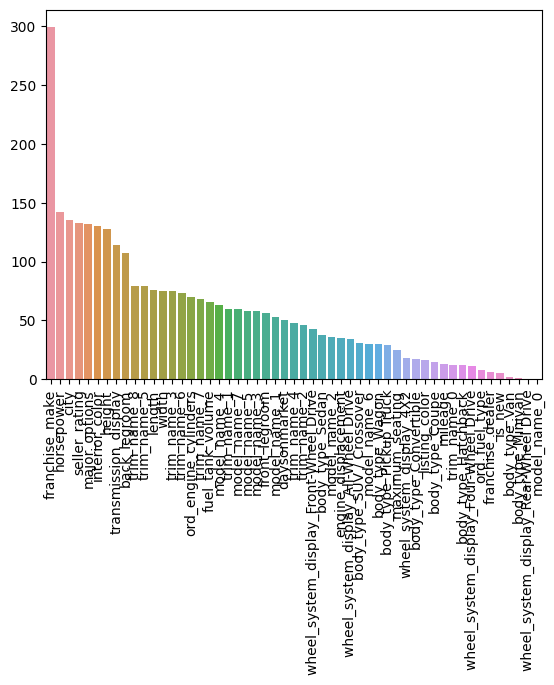

In [ ]:
ax = sns.barplot(x=feature_names, y=importances)
ax.tick_params(axis='x', rotation=90)

#### Hyperparameter tuning for LightGBM

In [ ]:
params = {"learning_rate":[0.001,0.01,0.1],
          "max_depth":[3, 6, 9],
          "min_child_weight":[1.0, 3, 6]}

best_score = -float('inf')
best_hyperparameters = None

for lr in params['learning_rate']:
    for depth in params['max_depth']:
        for weight in params['min_child_weight']:
            lbgm = LGBMRegressor(learning_rate=lr, max_depth=depth, 
                                                  min_child_weight=weight)
            lbgm.fit(X_train_scaled, y_train)
            y_val_pred_log = lbgm.predict(X_val_scaled)
            y_val_pred = np.exp(y_val_pred_log)

            val_score = r2_score(y_val, y_val_pred_log)
            if val_score > best_score:
                best_score = val_score
                best_hyperparameters = {'learning_rate': lr, 'max_depth': depth, 
                                        'min_child_weight': weight}



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [ ]:
print("Best hyperparameters: ", best_hyperparameters)


Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1.0}


In [ ]:
best_lbgm_regressor = LGBMRegressor(learning_rate=best_hyperparameters['learning_rate'], 
                                           max_depth=best_hyperparameters['max_depth'], 
                                           min_child_weight=best_hyperparameters['min_child_weight'])
best_lbgm_regressor.fit(X_dev_scaled, y_dev)

# Compute the R2 score for dev and test datasets
y_dev_pred_log = best_lbgm_regressor.predict(X_dev_scaled)
y_test_pred_log = best_lbgm_regressor.predict(X_test_scaled)

y_dev_pred = np.exp(y_dev_pred_log)
y_test_pred = np.exp(y_test_pred_log)

dev_lbgm_r2_score = r2_score(y_dev, y_dev_pred_log)
test_lbgm_r2_score = r2_score(y_test, y_test_pred_log)

lbgm_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
lbgm_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
lbgm_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
lbgm_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("LGBMRegressor R2 score on the dev dataset: ", round(dev_lbgm_r2_score, 4))
print("LGBMRegressor R2 score on the test dataset: ", round(test_lbgm_r2_score, 4))

print("LGBMRegressor RMSE loss on the test dataset: ", round(lbgm_rmse_test, 4))
print("LGBMRegressor MAE loss on the test dataset: ", round(lbgm_mae_test, 4))
print("LGBMRegressor MAPE loss on the test dataset: ", round(lbgm_mape_test, 4))
print("LGBMRegressor RMSLE loss on the test dataset: ", round(lbgm_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_lbgm_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("LGBMRegressor ranking ability (regression ROC): ", round(test_lbgm_roc_score, 4))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor R2 score on the dev dataset:  0.9644
LGBMRegressor R2 score on the test dataset:  0.9627
LGBMRegressor RMSE loss on the test dataset:  2632.4449
LGBMRegressor MAE loss on the test dataset:  1782.999
LGBMRegressor MAPE loss on the test dataset:  0.0503
LGBMRegressor RMSLE loss on the test dataset:  0.069
LGBMRegressor ranking ability (regression ROC):  0.9385


#### Feature importance with the best hyperparameters 

In [ ]:
feature_names = list(X_dev.columns)
print(f"Feature names: {feature_names}")
importances = best_lbgm_regressor.feature_importances_

feature_importances = pd.Series(importances, index=feature_names)

zipped_lists = zip(importances, feature_names)
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
importances, feature_names = [ list(tuple) for tuple in  tuples]

importances = importances[::-1]
feature_names = feature_names[::-1]

Feature names: ['back_legroom', 'city', 'daysonmarket', 'engine_displacement', 'franchise_dealer', 'franchise_make', 'front_legroom', 'fuel_tank_volume', 'height', 'horsepower', 'interior_color', 'is_new', 'length', 'listing_color', 'major_options', 'maximum_seating', 'mileage', 'model_name_0', 'model_name_1', 'model_name_2', 'model_name_3', 'model_name_4', 'model_name_5', 'model_name_6', 'model_name_7', 'seller_rating', 'transmission_display', 'trim_name_0', 'trim_name_1', 'trim_name_2', 'trim_name_3', 'trim_name_4', 'trim_name_5', 'trim_name_6', 'trim_name_7', 'trim_name_8', 'width', 'ord_fuel_type', 'ord_engine_cylinders', 'body_type_Convertible', 'body_type_Coupe', 'body_type_Hatchback', 'body_type_Minivan', 'body_type_Pickup Truck', 'body_type_SUV / Crossover', 'body_type_Sedan', 'body_type_Van', 'body_type_Wagon', 'wheel_system_display_4X2', 'wheel_system_display_All-Wheel Drive', 'wheel_system_display_Four-Wheel Drive', 'wheel_system_display_Front-Wheel Drive', 'wheel_system_dis

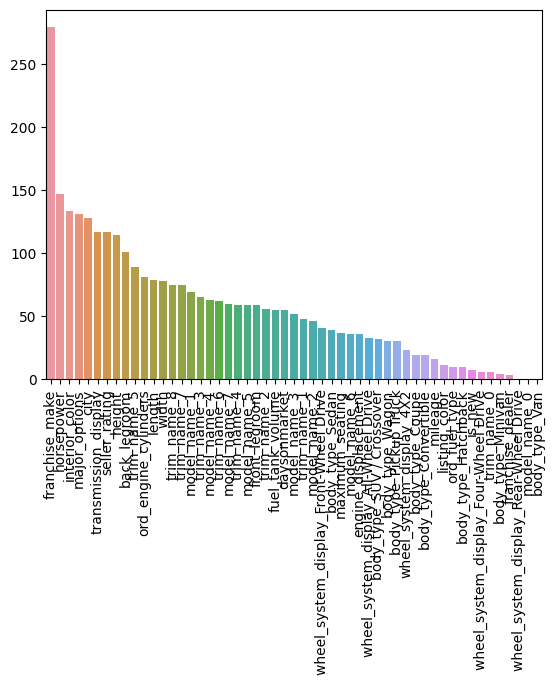

In [ ]:
ax = sns.barplot(x=feature_names, y=importances)
ax.tick_params(axis='x', rotation=90)

## 5.7 Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import clone_model

In [ ]:
# 4 different models each with 3 different trainings
lr_rates = [1e-3, 5e-3, 1e-2]

In [ ]:
# 4 different models
orig_models = []
orig_models.append(Sequential([
  Dense(128, input_shape = (X_dev_scaled.shape[1], ), activation= 'relu'),
  Dropout(0.4),
  Dense(32, activation = 'relu'),
  Dense(1, activation = 'linear')
]))

orig_models.append(Sequential([
  Dense(64, input_shape = (X_dev_scaled.shape[1], ), activation= 'tanh'),
  Dropout(0.2),
  Dense(32, activation = 'tanh'),
  Dense(1, activation = 'linear')
]))

orig_models.append(Sequential([
  Dense(256, input_shape = (X_dev_scaled.shape[1], ), activation= 'leaky_relu'),
  Dropout(0.4),
  Dense(128, input_shape = (X_dev_scaled.shape[1], ), activation= 'relu'),
  Dropout(0.2),
  Dense(64, input_shape = (X_dev_scaled.shape[1], ), activation= 'leaky_relu'),
  Dense(32, activation = 'relu'),
  Dense(1, activation = 'linear')
]))

orig_models.append(Sequential([
  Dense(256, input_shape = (X_dev_scaled.shape[1], ), activation= 'tanh'),
  Dropout(0.3),
  Dense(128, input_shape = (X_dev_scaled.shape[1], ), activation= 'tanh'),
  Dropout(0.2),
  Dense(64, input_shape = (X_dev_scaled.shape[1], ), activation= 'leaky_relu'),
  Dropout(0.1),
  Dense(16, activation = 'tanh'),
  Dense(1, activation = 'linear')
]))

In [ ]:
print(orig_models[0].summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               6912      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 11,073
Trainable params: 11,073
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(orig_models[1].summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                3456      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,569
Trainable params: 5,569
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(orig_models[2].summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               13824     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 1)                

In [ ]:
print(orig_models[3].summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               13824     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 16)               

In [ ]:
# Record all the training logs
training_histories = []

# Maintain separate models for each training
models = []

In [ ]:
# train each model for 15 epochs
for model_idx, model in enumerate(orig_models):
  for idx, lr_rate in enumerate(lr_rates):
    curr_idx = model_idx * len(lr_rates) + idx
    print(f"Model {model_idx + 1} with learning rate: ", lr_rate)

    # clone the model
    models.append(clone_model(model))

    models[curr_idx].compile(
        optimizer = Adam(learning_rate = lr_rate),
        loss = "mse",
        metrics = [tf.keras.metrics.RootMeanSquaredError(), "mae"]
    )

    # save the weights of model with best validation RMSE performance
    # load these weights during the test data prediction
    callbacks = ModelCheckpoint(
        filepath = f'model_{curr_idx}_best_weights.h5', 
        save_freq = 'epoch', verbose = 0, monitor = 'val_root_mean_squared_error', 
        save_weights_only = True, save_best_only = True
    )

    train_history = models[curr_idx].fit(
      X_train_scaled,
      y_train,
      batch_size = 64,
      epochs = 15,
      verbose = 1,
      validation_data = (X_val_scaled, y_val),
      callbacks = [callbacks],
      shuffle = True
    )

    training_histories.append(train_history)

Model 1 with learning rate:  0.001
Epoch 1/15
1618/1618 [==============================] - 11s 5ms/step - loss: 3.1200 - root_mean_squared_error: 1.7663 - mae: 1.1685 - val_loss: 0.1298 - val_root_mean_squared_error: 0.3603 - val_mae: 0.2967
Epoch 2/15
1618/1618 [==============================] - 7s 4ms/step - loss: 0.4498 - root_mean_squared_error: 0.6707 - mae: 0.5160 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2427 - val_mae: 0.1912
Epoch 3/15
1618/1618 [==============================] - 7s 4ms/step - loss: 0.0646 - root_mean_squared_error: 0.2541 - mae: 0.1898 - val_loss: 0.0205 - val_root_mean_squared_error: 0.1433 - val_mae: 0.1024
Epoch 4/15
1618/1618 [==============================] - 6s 4ms/step - loss: 0.0324 - root_mean_squared_error: 0.1801 - mae: 0.1328 - val_loss: 0.0172 - val_root_mean_squared_error: 0.1313 - val_mae: 0.0948
Epoch 5/15
1618/1618 [==============================] - 7s 5ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - mae: 0.1146 - val_los

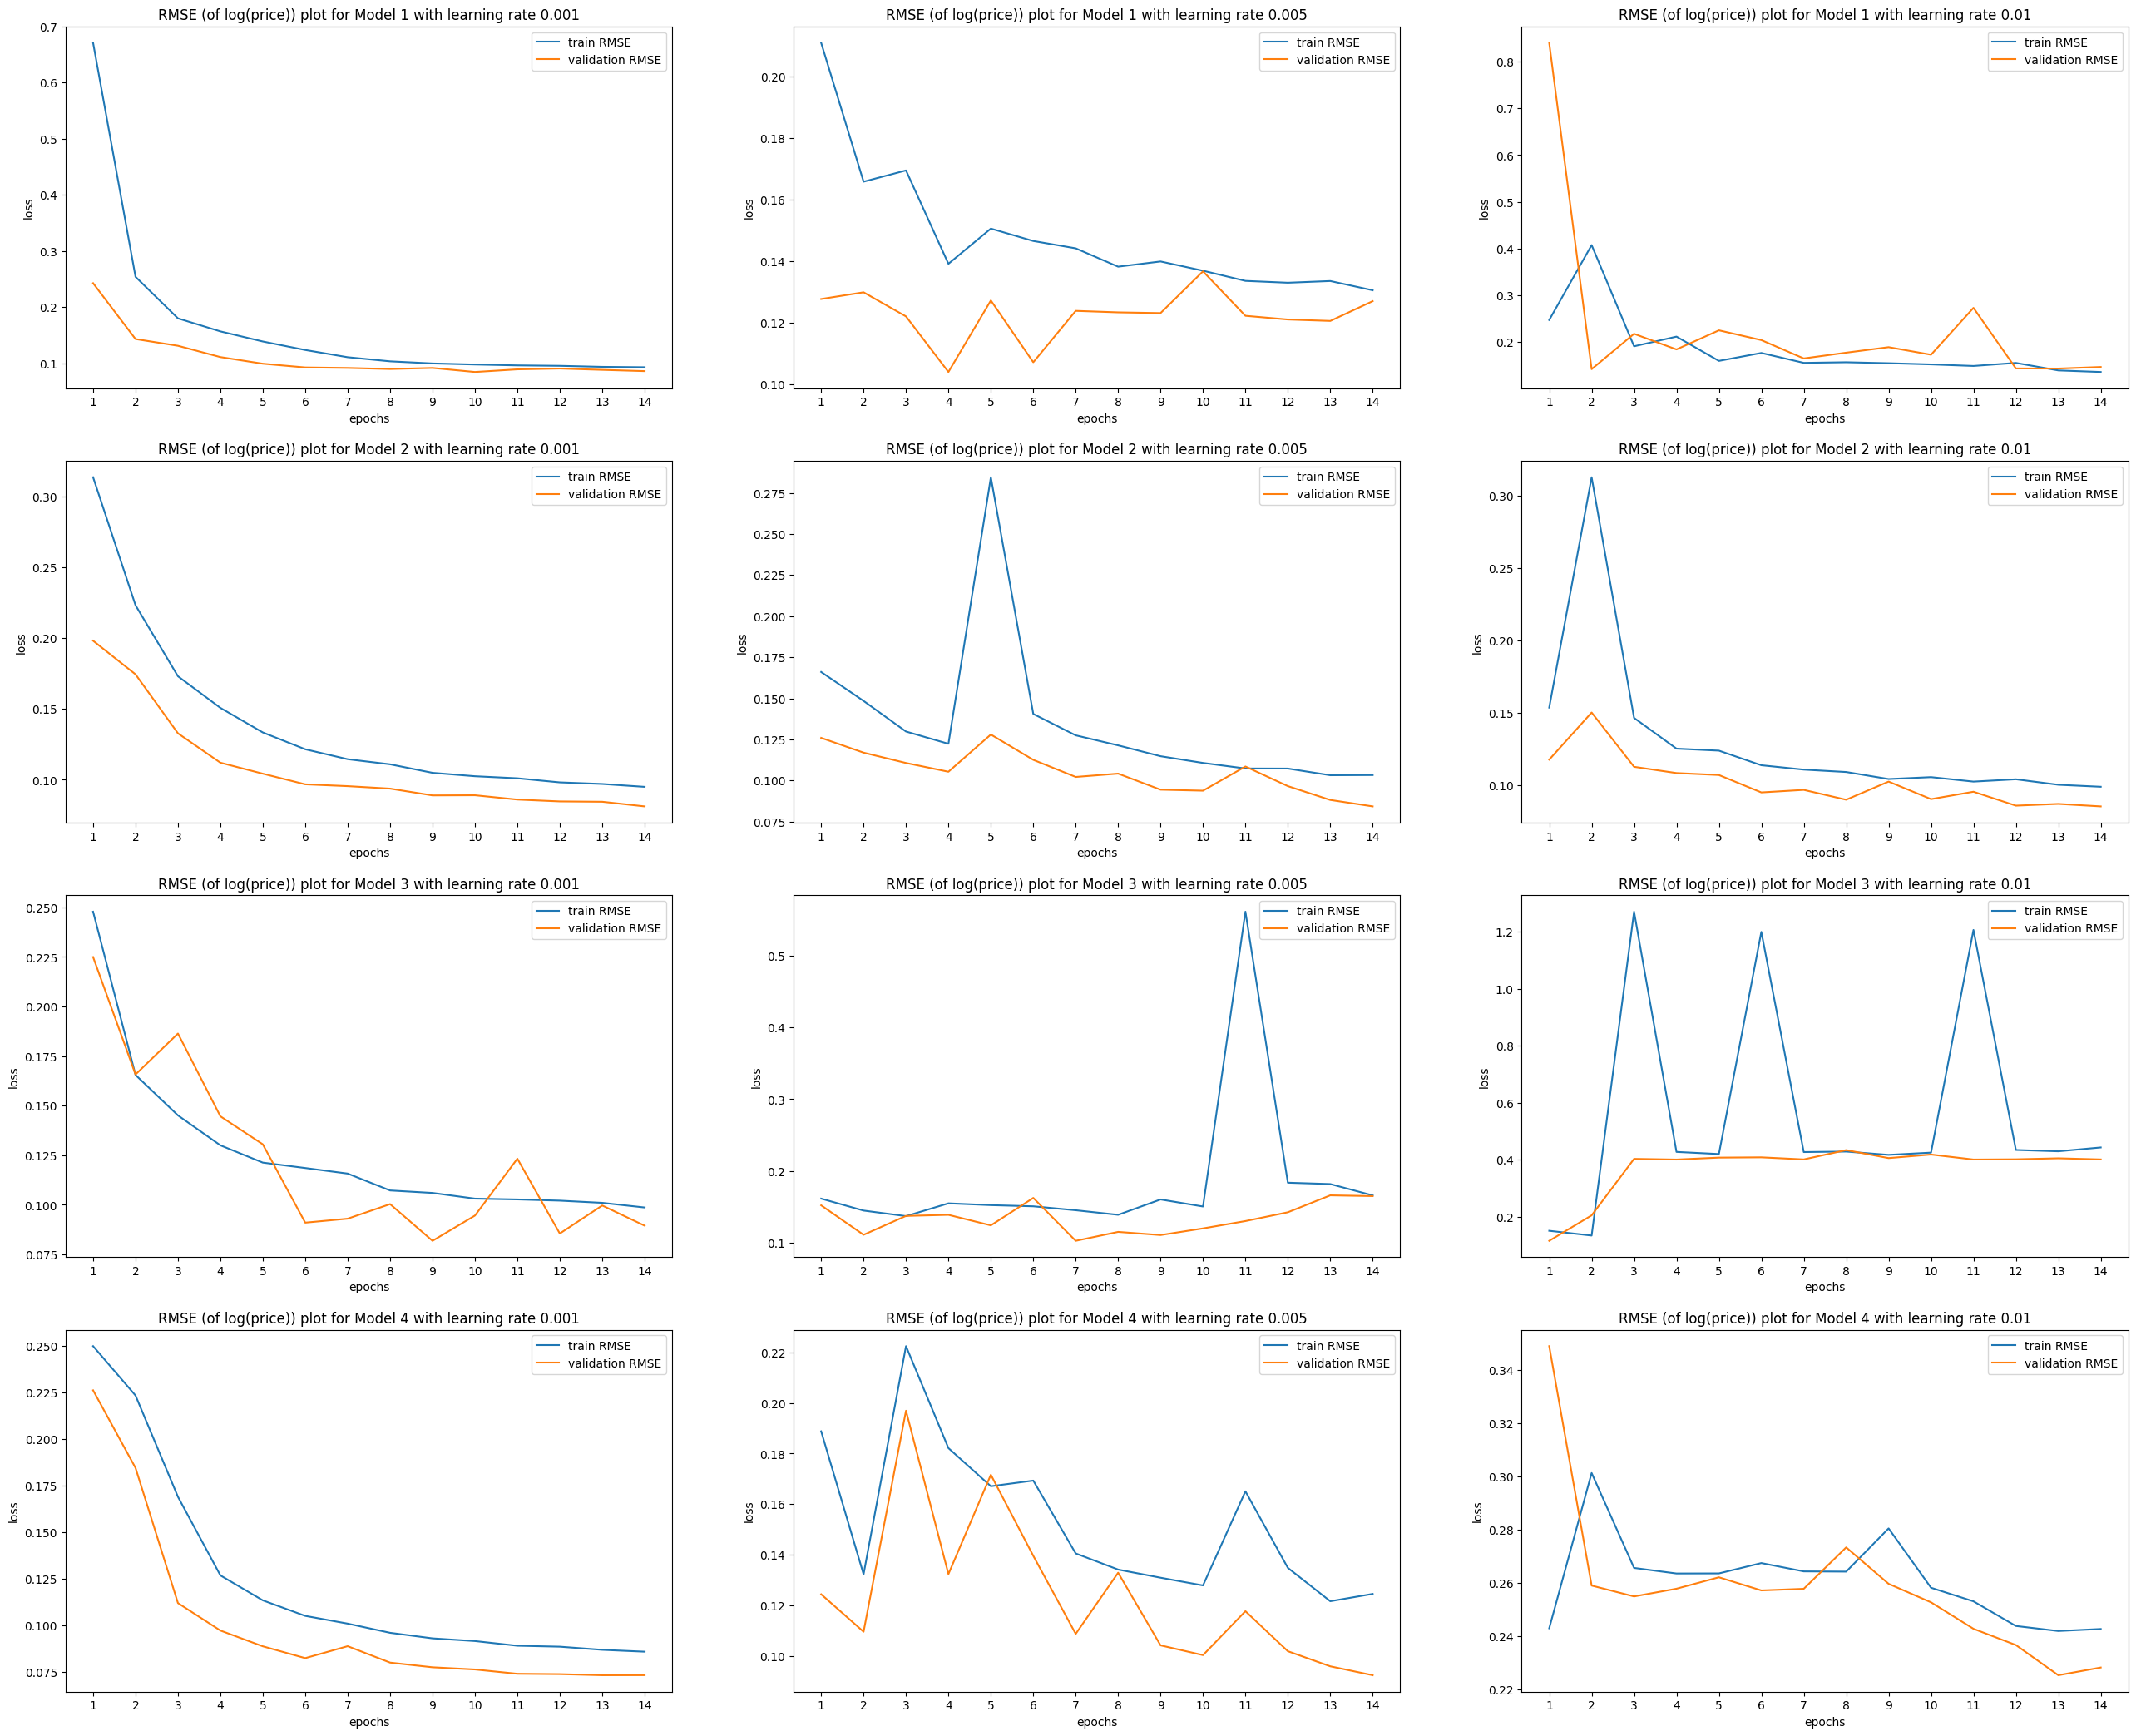

In [ ]:
fig, axs = plt.subplots(4, 3, figsize = (32, 26))

# Select the model with best validation RMSE performance
best_val_rmsle_score = 100
best_model_idx = -1

for idx, train_history in enumerate(training_histories):
  history = pd.DataFrame(train_history.history)

  i = idx//3
  j = idx%3

  curr_best_val_rmsle_score = np.min(history['val_root_mean_squared_error'][1:])

  if best_val_rmsle_score > curr_best_val_rmsle_score:
    best_val_rmsle_score = curr_best_val_rmsle_score
    best_model_idx = idx

  # ignore the first epoch in plots to make validation scores more visible
  axs[i][j].plot(history.index[1:], history['root_mean_squared_error'][1:], label = 'train RMSE')
  axs[i][j].plot(history.index[1:], history['val_root_mean_squared_error'][1:], label = 'validation RMSE')
  axs[i][j].set_xticks(np.arange(1, 15, 1))
  axs[i][j].set_xlabel('epochs') 
  axs[i][j].set_ylabel('loss')
  axs[i][j].legend(loc = "upper right")
  axs[i][j].set_title(f"RMSE (of log(price)) plot for Model {i + 1} with learning rate {lr_rates[j]}")

# plt.savefig("nn_trainings.png", format = 'png', dpi = 800)

In [ ]:
print(f"Model with best validation performance: model {best_model_idx//3 + 1} with learning_rate = {lr_rates[best_model_idx%3]}")

# load the best saved weights of the model
models[best_model_idx].load_weights(f'model_{best_model_idx}_best_weights.h5')

# Make predictions on the test dataset
y_test_pred_log = models[best_model_idx].predict(X_test_scaled, verbose = 0)
y_test_pred = np.exp(y_test_pred_log)

test_nn_r2_score = r2_score(y_test, y_test_pred_log)

nn_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
nn_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
nn_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
nn_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Neural Network R2 score on the test dataset: ", round(test_nn_r2_score, 4))

print("Neural Network RMSE loss on the test dataset: ", round(nn_rmse_test, 4))
print("Neural Network MAE loss on the test dataset: ", round(nn_mae_test, 4))
print("Neural Network MAPE loss on the test dataset: ", round(nn_mape_test, 4))
print("Neural Network RMSLE loss on the test dataset: ", round(nn_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_nn_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Neural Network ranking ability (regression ROC): ", round(test_nn_roc_score, 4))

Model with best validation performance: model 4 with learning_rate = 0.001
Neural Network R2 score on the test dataset:  0.9604
Neural Network RMSE loss on the test dataset:  12191.8439
Neural Network MAE loss on the test dataset:  2125.8829
Neural Network MAPE loss on the test dataset:  0.0505
Neural Network RMSLE loss on the test dataset:  0.08
Neural Network ranking ability (regression ROC):  0.9446


## 5.8 Deep Learning model: TabNet

In [ ]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 979.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 101.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all t

In [ ]:
import torch
from pytorch_tabnet.tab_model import TabNetRegressor

In [ ]:
tabnet_model = TabNetRegressor(
    verbose = 1, 
    optimizer_fn = torch.optim.Adam,
    optimizer_params = dict(lr = 2e-3),
    device_name = 'cuda',
    seed = 42)

tabnet_model.fit(
    X_train = X_train_scaled, y_train = y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    eval_name=['train','val'],
    eval_metric=['rmse', 'mae'],
    max_epochs = 25,
    patience= 5,
    batch_size = 64,
    drop_last = False,
) 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.70354 | train_rmse: 0.26023 | train_mae: 0.16764 | val_rmse: 0.27746 | val_mae: 0.16871 |  0:01:15s
epoch 1  | loss: 0.05111 | train_rmse: 0.17604 | train_mae: 0.12614 | val_rmse: 0.23536 | val_mae: 0.1272  |  0:02:15s
epoch 2  | loss: 0.03368 | train_rmse: 0.15023 | train_mae: 0.09877 | val_rmse: 0.15053 | val_mae: 0.09916 |  0:03:11s
epoch 3  | loss: 0.02555 | train_rmse: 0.16941 | train_mae: 0.09156 | val_rmse: 0.18656 | val_mae: 0.09247 |  0:04:17s
epoch 4  | loss: 0.02155 | train_rmse: 0.11958 | train_mae: 0.08586 | val_rmse: 0.11894 | val_mae: 0.08626 |  0:05:15s
epoch 5  | loss: 0.01896 | train_rmse: 0.11763 | train_mae: 0.08587 | val_rmse: 0.11697 | val_mae: 0.08588 |  0:06:12s
epoch 6  | loss: 0.01691 | train_rmse: 0.11425 | train_mae: 0.08083 | val_rmse: 0.1127  | val_mae: 0.08063 |  0:07:08s
epoch 7  | loss: 0.01531 | train_rmse: 0.10443 | train_mae: 0.07376 | val_rmse: 0.10393 | val_mae: 0.07363 |  0:08:04s
epoch 8  | loss: 0.01419 | train_rmse: 0.09924 |

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


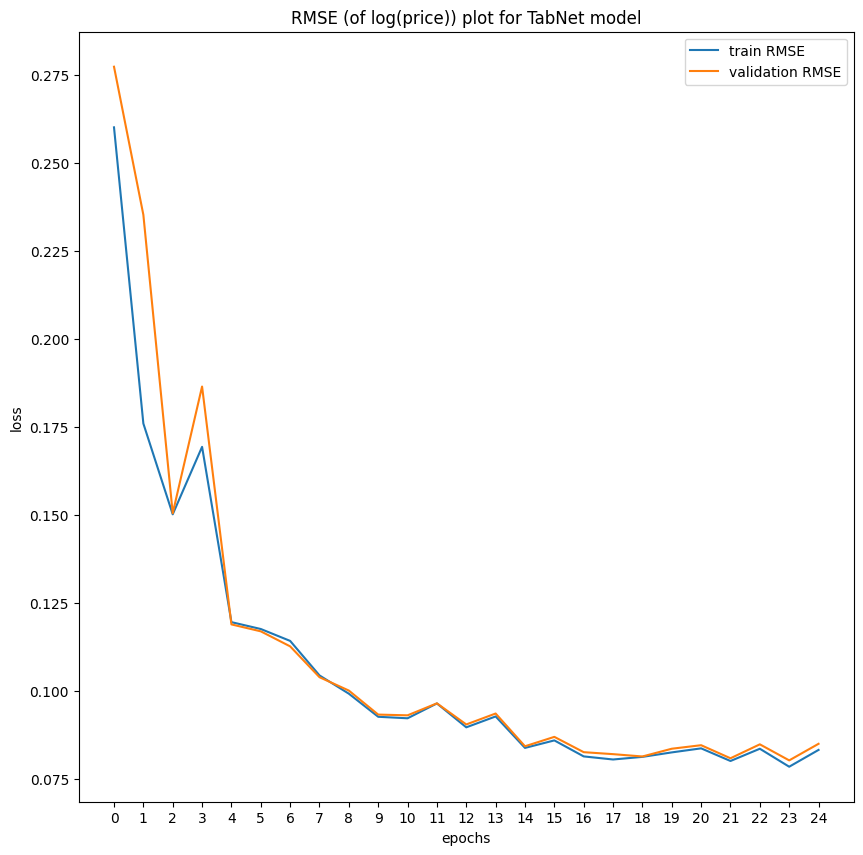

In [ ]:
plt.figure(figsize = (10, 10))
plt.plot(np.arange(0, 25, 1), tabnet_model.history['train_rmse'], label = 'train RMSE')
plt.plot(np.arange(0, 25, 1), tabnet_model.history['val_rmse'], label = 'validation RMSE')
plt.xticks(np.arange(0, 25, 1))
plt.xlabel('epochs') 
plt.ylabel('loss')
plt.legend(loc = "upper right")
plt.title("RMSE (of log(price)) plot for TabNet model")
plt.show()

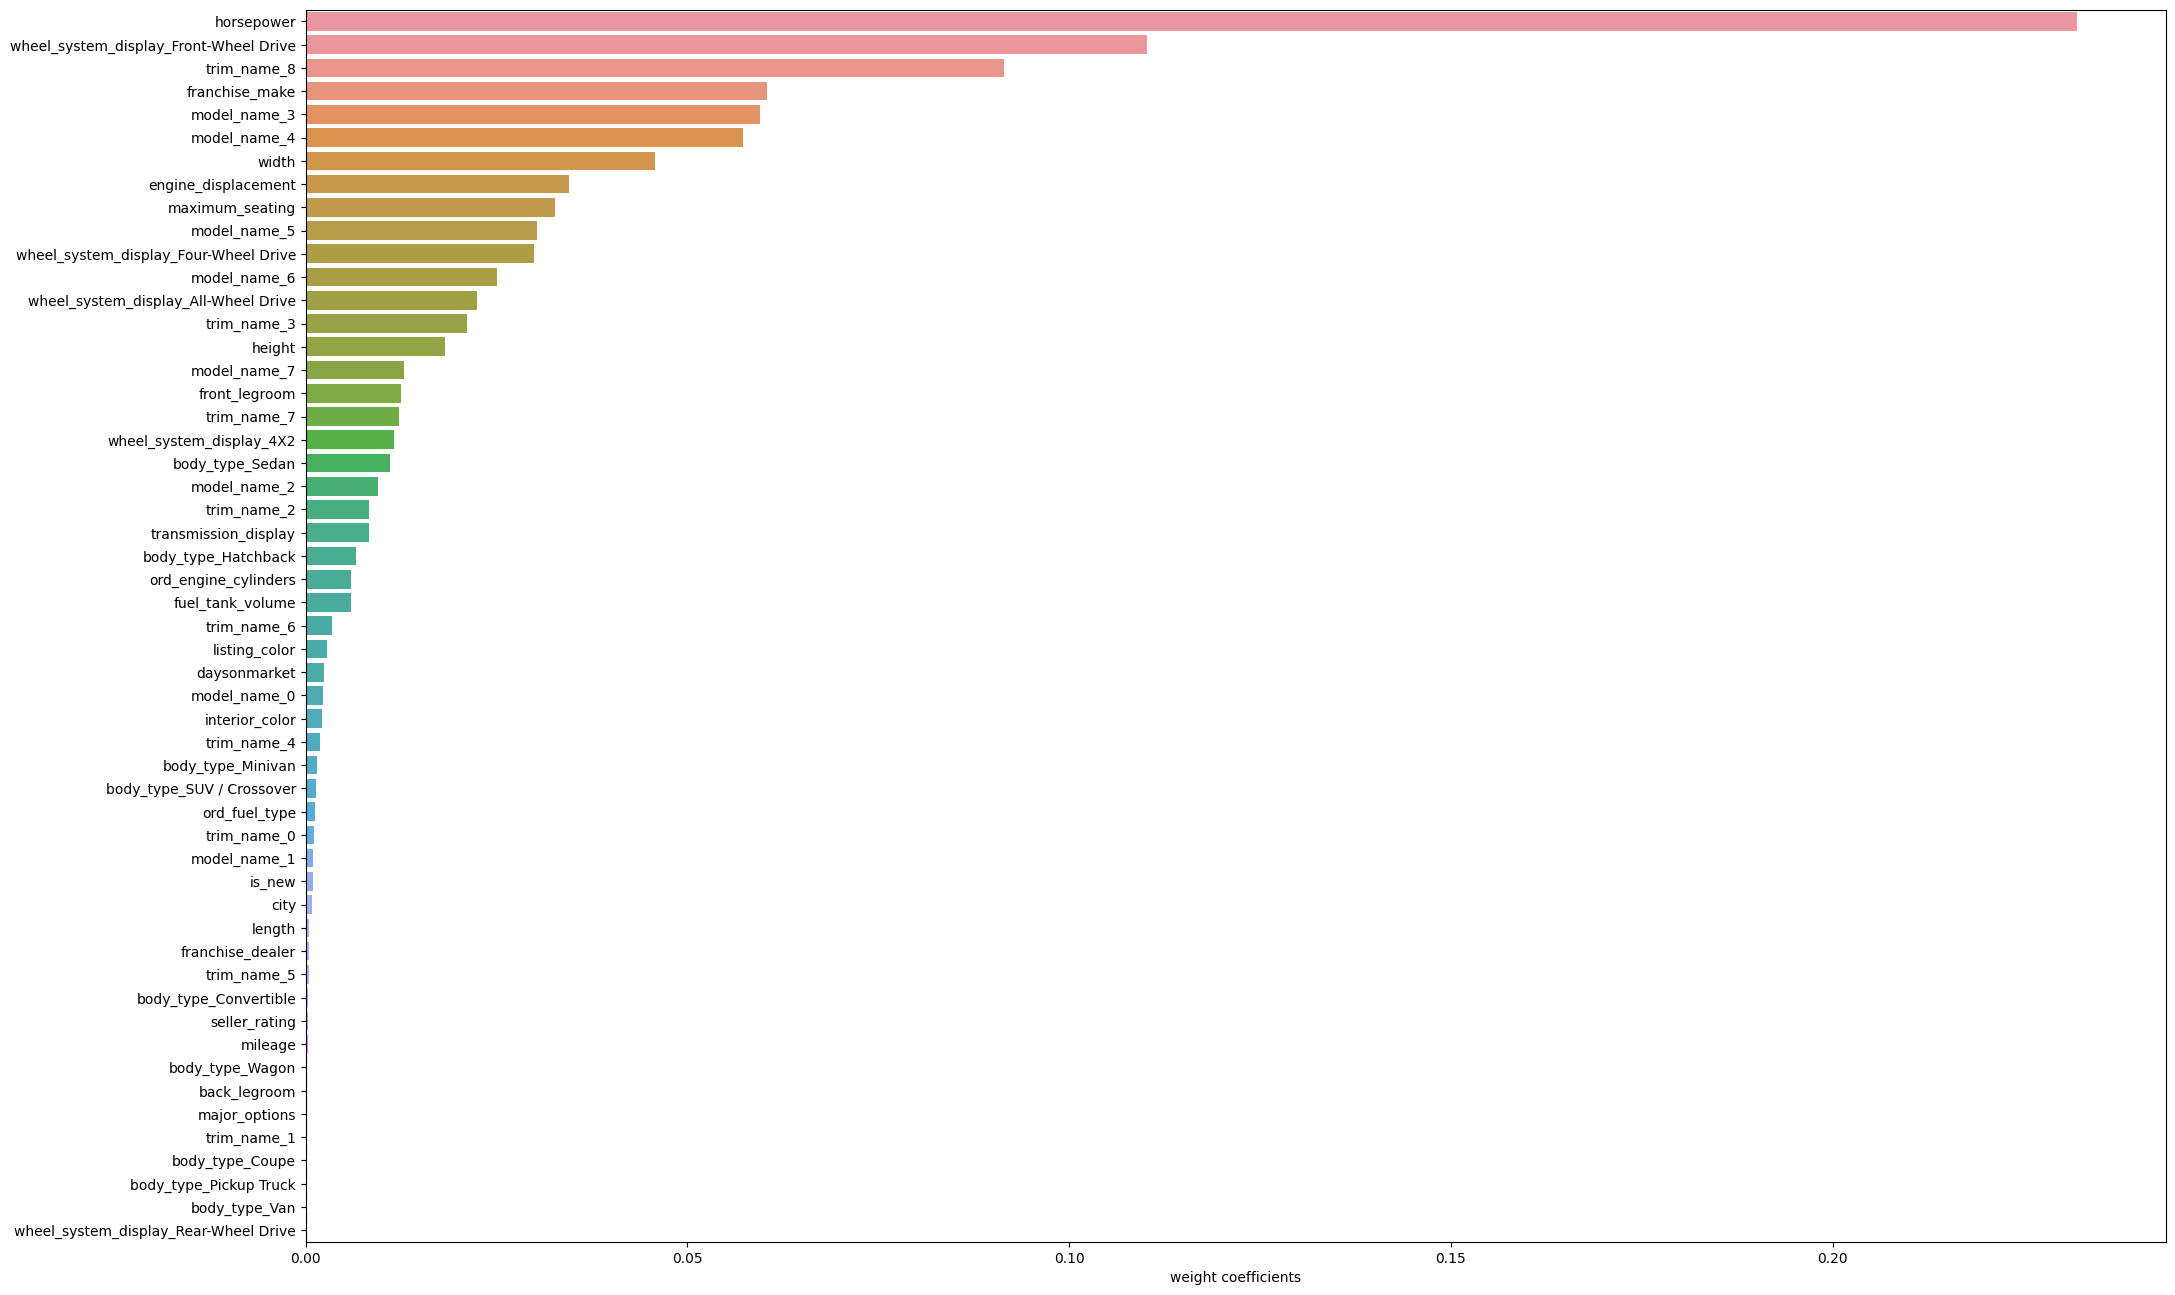

In [ ]:
# plot the importances of each feature
plt.figure(figsize = (24, 16))

feat_imps = zip(feature_names, list(tabnet_model.feature_importances_))
feats, imps = zip(*(sorted(feat_imps, key = lambda x: x[1], reverse=True)))
sns.barplot(y = list(feats), x = list(imps), orient = "h")
plt.xlabel('weight coefficients');

# plt.savefig('tabnet_weights.png', format='png', dpi = 800)

In [ ]:
# Make predictions on the test dataset
y_test_pred_log = tabnet_model.predict(X_test_scaled)
y_test_pred = np.exp(y_test_pred_log)

test_tabnet_r2_score = r2_score(y_test, y_test_pred_log)

tabnet_rmse_test = mean_squared_error(y_test_orig, y_test_pred, squared = False)
tabnet_mae_test = mean_absolute_error(y_test_orig, y_test_pred)
tabnet_mape_test = mean_absolute_percentage_error(y_test_orig, y_test_pred)
tabnet_rmsle_test = mean_squared_log_error(y_test_orig, y_test_pred, squared = False)

print("Tabnet R2 score on the test dataset: ", round(test_tabnet_r2_score, 4))

print("Tabnet RMSE loss on the test dataset: ", round(tabnet_rmse_test, 4))
print("Tabnet MAE loss on the test dataset: ", round(tabnet_mae_test, 4))
print("Tabnet MAPE loss on the test dataset: ", round(tabnet_mape_test, 4))
print("Tabnet RMSLE loss on the test dataset: ", round(tabnet_rmsle_test, 4))

# Compute the ranking ability (regression ROC) for the model
test_tabnet_roc_score = regression_roc_auc_score(y_test_orig, y_test_pred)
print("Tabnet ranking ability (regression ROC): ", round(test_tabnet_roc_score, 4))

Tabnet R2 score on the test dataset:  0.9543
Tabnet RMSE loss on the test dataset:  12186.0401
Tabnet MAE loss on the test dataset:  2250.2321
Tabnet MAPE loss on the test dataset:  0.0552
Tabnet RMSLE loss on the test dataset:  0.0859
Tabnet ranking ability (regression ROC):  0.9383
